In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from itertools import product
import random
from scipy.sparse import csr_matrix
from queue import SimpleQueue
from sys import getsizeof

In [2]:
def matrix_generator(k:int):
    n = 2 ** k
    n_2 = n ** 2
    matrix = np.zeros((n**3, n**3))
    for i in range(n**3):
        x, y, z =  i % n, (i % n_2)//n, i // n_2
        for direction, dimension in product((1, -1), (0, 1, 2)):
            dir_list = [direction if i == dimension else 0 for i in range(3)] 
            coords = [step + dir_list[idx] for idx, step in enumerate((x, y, z))]
            if all([(index > -1 and index < n) for index in coords]):
                j = i + (n ** dimension) * direction
                if matrix[i][j] == 0:
                    matrix[i][j] = random.random() 
    return matrix
                

In [3]:
def divide(A):
    X, Y = A.shape
    return A[:X//2,:Y//2],A[:X//2,Y//2:],A[X//2:,:Y//2],A[X//2:,Y//2:]

In [4]:
class MatrixTree:
    def __init__(self, matrix:np.ndarray):
        self.matrix = matrix
        self.shape = matrix.shape
        self.zeros = None
        self.A11 = None
        self.A12 = None
        self.A21 = None
        self.A22 = None
        self.u = None
        self.vT = None
    def compute(self):
        if self.matrix is not None:
            return self.matrix
        elif self.zeros is not None:
            return np.zeros(self.zeros)
        elif self.A11 is not None:
            a11, a12, a21, a22 = (i.compute() for i in (self.A11, self.A12, self.A21, self.A22))
            U = np.hstack((a11,a12))
            L = np.hstack((a21,a22))
            return np.vstack((U,L))
        else:
            return self.u @ self.vT
    def paint(self):
        if self.matrix is not None:
            image = np.zeros(self.matrix.shape)
        elif self.zeros is not None:
            image = np.ones(self.zeros)
        elif self.A11 is not None:
            a11, a12, a21, a22 = (i.paint() for i in (self.A11, self.A12, self.A21, self.A22))
            U = np.hstack((a11,a12))
            L = np.hstack((a21,a22))
            image = np.vstack((U,L))
        else:
            shape = (self.u.shape[0], self.vT.shape[1])
            image = np.ones(shape)
            image[:,:self.u.shape[1]] = np.zeros(self.u.shape)
            image[:self.vT.shape[0],:] = np.zeros(self.vT.shape)
        return image
    def draw(self):
        plt.gray()
        plt.figure(figsize=(20,10))
        plt.imshow(self.paint())
        plt.show()
    def size(self):
        return sum(item.size() if type(item) is MatrixTree else getsizeof(item) for item in self.__dict__.values())

In [5]:
def decompose(tree: MatrixTree, u: np.ndarray, d: np.ndarray, vT: np.ndarray) -> None:
    if len(d)==0:
        tree.zeros=tree.matrix.shape
        tree.matrix = None
        return
    tree.matrix = None
    d = np.diag(d) if len(d)>1 else np.array([d])
    tree.u = u @ d
    tree.vT = vT

In [6]:
def compress(tree: MatrixTree, sigma: float, b: int):
    #print(tree.matrix.shape)
    #print(max_depth)
    if not np.any(abs(tree.matrix) > 1e-4):
        #print(tree.matrix.shape)
        tree.zeros = tree.matrix.shape
        tree.matrix = None
        return
    if tree.matrix.size <= 1:
        return
    u, s, vT = np.linalg.svd(tree.matrix)
    new_rank = np.sum(np.where(s>=sigma,1,0))
    if new_rank <= b:
        u  =  u[:, :new_rank]
        vT = vT[:new_rank, :]
        decompose(tree, u, s[:new_rank], vT)
        return
    else:
        A11, A12, A21, A22 = divide(tree.matrix)
        tree.matrix = None
        tree.A11 = MatrixTree(A11)
        tree.A12 = MatrixTree(A12)
        tree.A21 = MatrixTree(A21)
        tree.A22 = MatrixTree(A22)
        compress(tree.A11, sigma, b)
        compress(tree.A12, sigma, b)
        compress(tree.A21, sigma, b)
        compress(tree.A22, sigma, b)

In [7]:
A = matrix_generator(3)

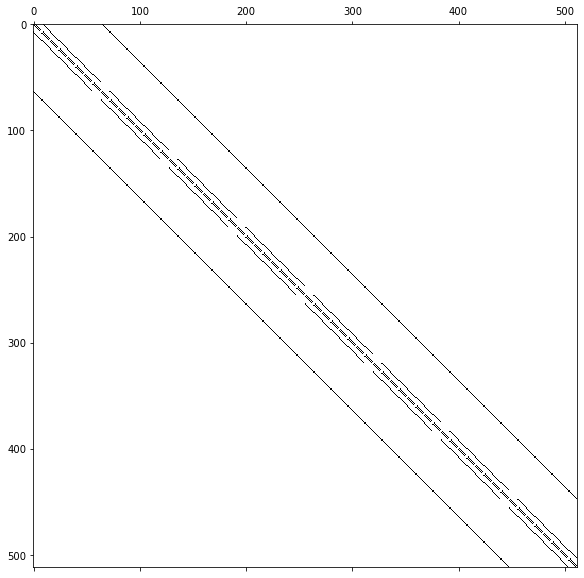

In [8]:
plt.figure(figsize=(20,10))
plt.spy(A)
plt.show()

<Figure size 432x288 with 0 Axes>

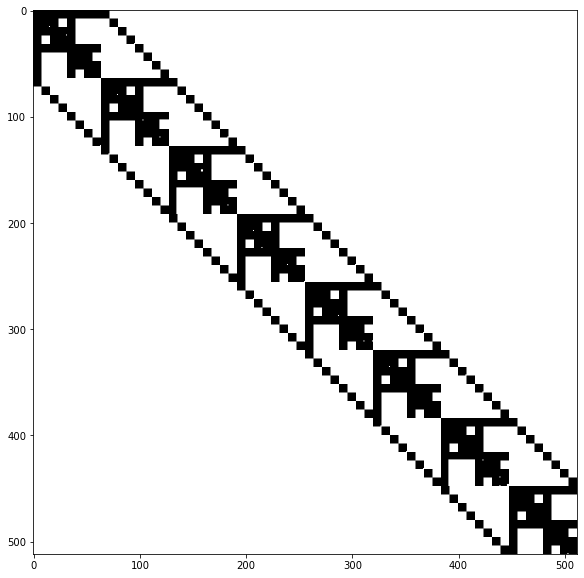

In [9]:
A_tree = MatrixTree(A)
compress(A_tree, 0.01, 8)
A_tree.draw()

In [10]:
compressed = csr_matrix(A)

print('Rozmiar oryginalny:', A.nbytes, 'B')
print('Rozmiar po kompresji:', compressed.data.nbytes + compressed.indptr.nbytes + compressed.indices.nbytes, 'B')

Rozmiar oryginalny: 2097152 B
Rozmiar po kompresji: 34308 B


In [11]:
def neighborhood_dict(matrix):#Zwraca słownik par wierzchołek -> zbiór jego sąsiadów
    m, n = matrix.shape
    return {i: set(j for j in range(n) if matrix[i][j] > 0 and i != j) for i in range(m)}

In [12]:
def apply_permutation(matrix, permutation):
    matrix = np.array([matrix[i, :] for i in permutation]) 
    return np.array([matrix[:, i] for i in permutation])    

In [13]:
def minimum_degree(matrix):
    m, n = matrix.shape
    permutation = []
    adjacency = neighborhood_dict(matrix)
    for i in range(n):
        # znajduję wierzchołek o minimalnym stopniu
        min_degree, best_vertex = min(((len(adjacent), v) for v, adjacent in adjacency.items()), key = lambda x: x[0])
        for vertex in adjacency:#usuwam wierzchołek z list sąsiadów dla każdego wierzchołka
            adjacency[vertex].discard(best_vertex)
        for neighbor in adjacency[best_vertex]:#każdemu z sąsiadów usuniętego wierzchołka dodaję nowych sąsiadów
            adjacency[neighbor].update(adjacency[best_vertex].difference(set([neighbor])))
        del adjacency[best_vertex]
        permutation.append(best_vertex)
    return apply_permutation(matrix, permutation)

In [14]:
def cuthill_mckee_bfs(adjacency, visited, vertex, permutation):
    q = SimpleQueue()
    q.put(vertex)
    while not q.empty():
        vertex = q.get()
        if not visited[vertex]:
            visited[vertex] = True
            permutation.append(vertex) 
            #sąsiedzi posortowani rosnąco według stopnia
            for neighbor in sorted(list(adjacency[vertex]), key=lambda x: len(adjacency[x])):
                if not visited[neighbor]:
                    q.put(neighbor)
def cuthill_mckee_permutation(matrix):
    m, n = matrix.shape
    adjacency = neighborhood_dict(matrix)
    sorted_vertices = sorted([(vertex, len(neighbors)) for vertex, neighbors in adjacency.items()], key=lambda x: x[1])
    permutation = []
    visited = [False for i in range(m)]
    for vertex, _ in sorted_vertices:
        if not visited[vertex]:
            cuthill_mckee_bfs(adjacency, visited, vertex, permutation)
    return permutation
def cuthill_mckee(matrix):
    return apply_permutation(matrix, cuthill_mckee_permutation(matrix))

In [15]:
def reversed_cuthill_mckee(matrix):
    return apply_permutation(matrix, cuthill_mckee_permutation(matrix)[::-1])

In [16]:
B = minimum_degree(A)
C = cuthill_mckee(A)
D = reversed_cuthill_mckee(A)

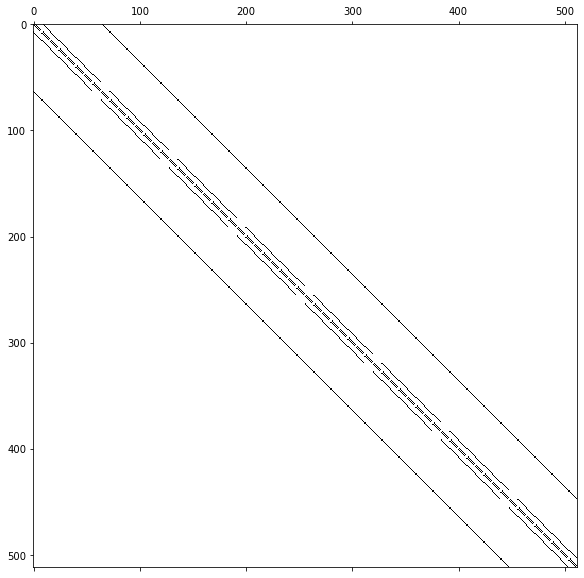

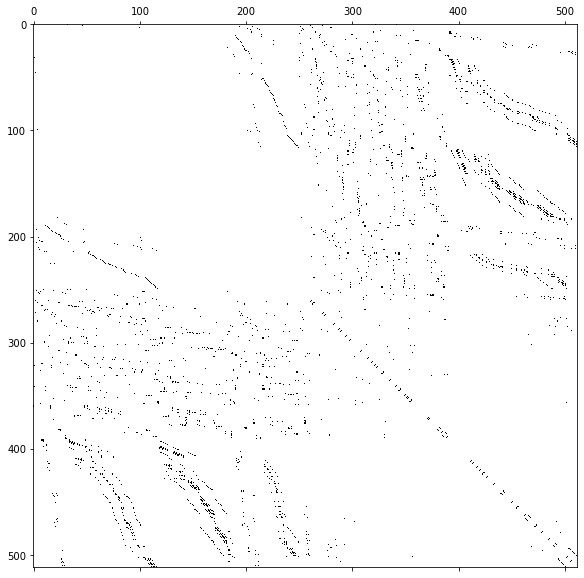

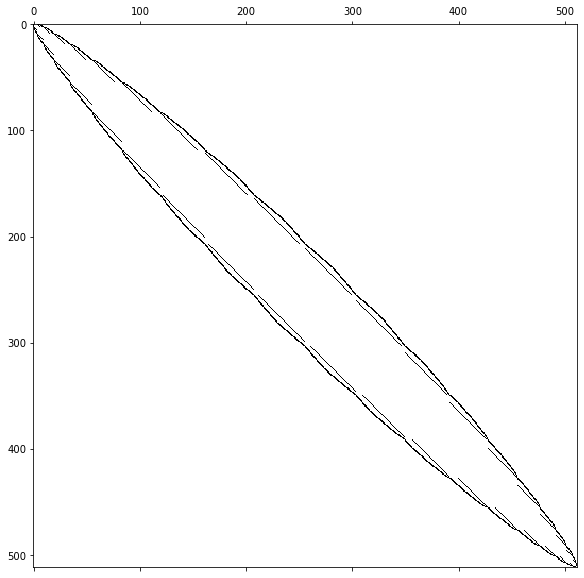

In [17]:
for x in (A, B, C):
    plt.figure(figsize=(20,10))
    plt.spy(x)
    plt.show()

<Figure size 432x288 with 0 Axes>

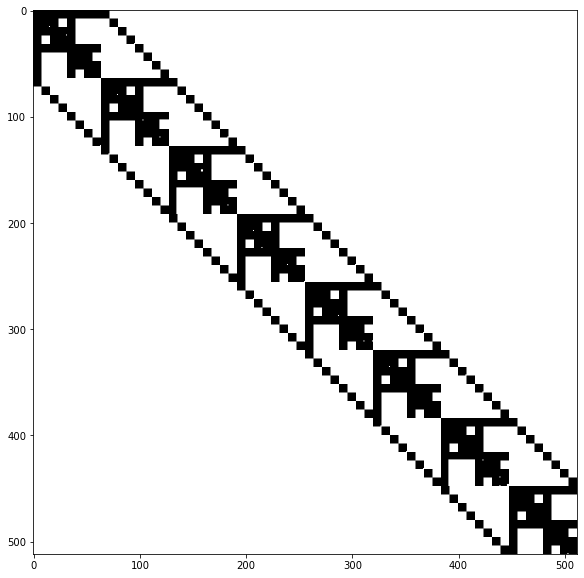

<Figure size 432x288 with 0 Axes>

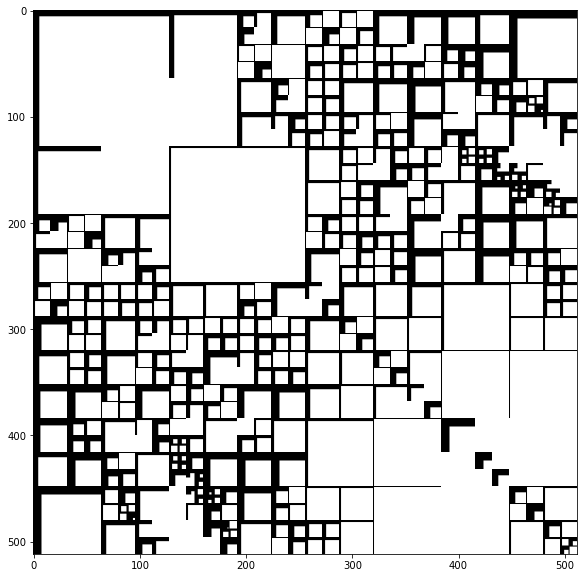

<Figure size 432x288 with 0 Axes>

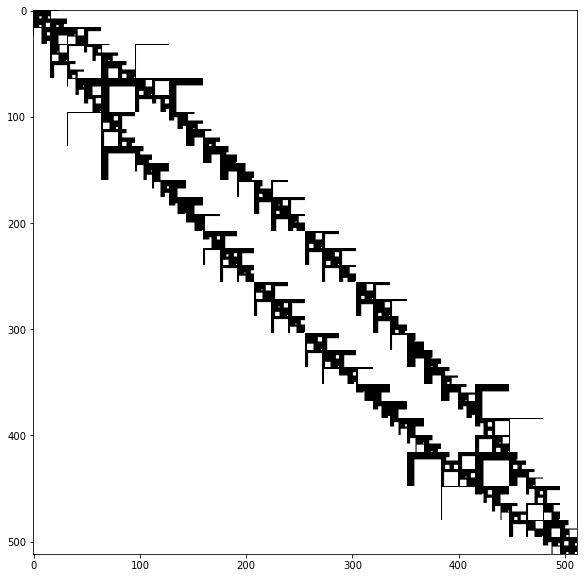

In [18]:
for x in (A, B, C):
    tree = MatrixTree(x)
    compress(tree, 0.01, 8)
    tree.draw()
    plt.show()

In [19]:
def test(sigma_div, b):
    for k in (2,3,4):
        print('k = ',k,'\n')
        matrix = matrix_generator(k)
        sparse = csr_matrix(matrix)
        print('wzorzec gęstości macierzy przed kompresją:')
        plt.figure(figsize=(20,10))
        plt.spy(matrix)
        plt.show()
        tree = MatrixTree(matrix)
        sigma = np.linalg.svd(matrix, compute_uv=False)[matrix.shape[0]//sigma_div]
        compress(tree, sigma, b)
        print(f'Rozmiar oryginalny:\t{matrix.nbytes}B')
        print(f'Rozmiar macierzy rzadkiej:\t{sparse.data.nbytes + sparse.indptr.nbytes + sparse.indices.nbytes}B')
        print(f'Rozmiar macierzy hierarchicznej bez permutacji:\t{tree.size()}B')
        print('wzorzec gęstości macierzy po kompresji bez permutacji:')
        tree.draw()
        for function in (minimum_degree, cuthill_mckee, reversed_cuthill_mckee):
            permutated = function(matrix)
            print(f'wzorzec gęstości macierzy po permutacji {function.__name__}:')
            plt.figure(figsize=(20,10))
            plt.spy(permutated)
            plt.show()
            tree = MatrixTree(permutated)
            compress(tree, sigma, b)
            name = f'Rozmiar macierzy hierarchicznej z permutacją {function.__name__}:\t'
            name = name[:-1] if len(name) == 70 else name
            print(f'{name}{tree.size()}B')
            print(f'wzorzec gęstości macierzy po kompresji z permutacją {function.__name__}:')
            tree.draw()

test for δ = size/2, b = 2
k =  2 

wzorzec gęstości macierzy przed kompresją:


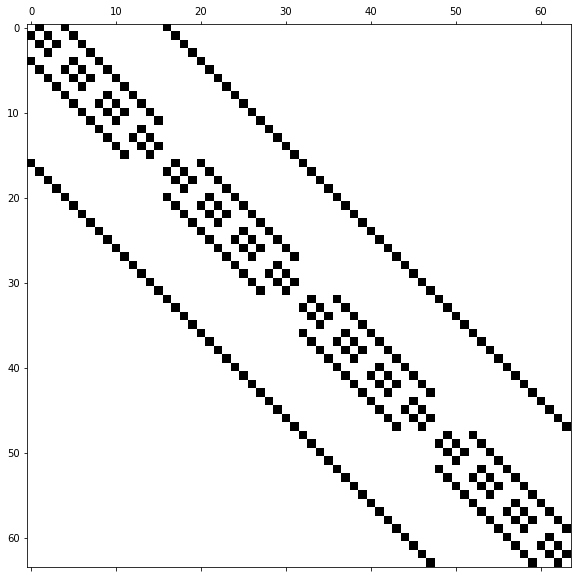

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	17760B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

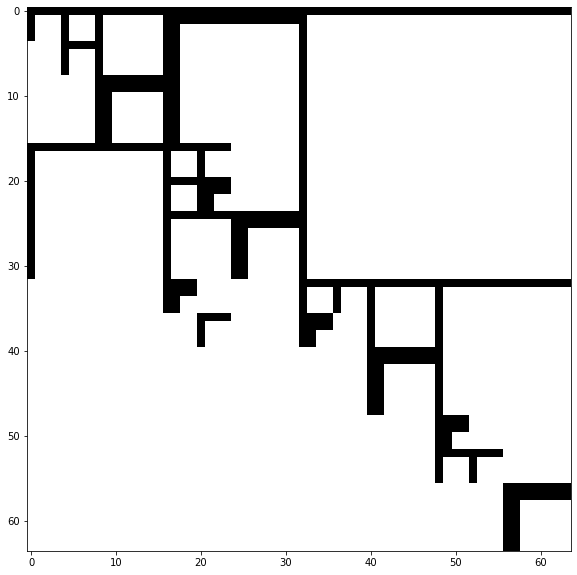

wzorzec gęstości macierzy po permutacji minimum_degree:


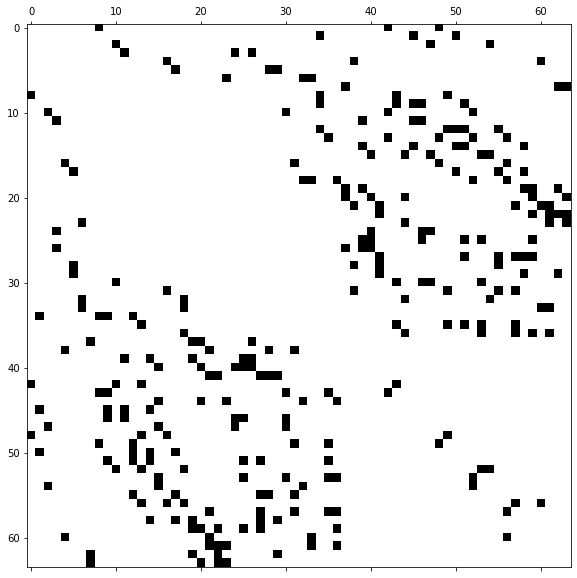

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	19872B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

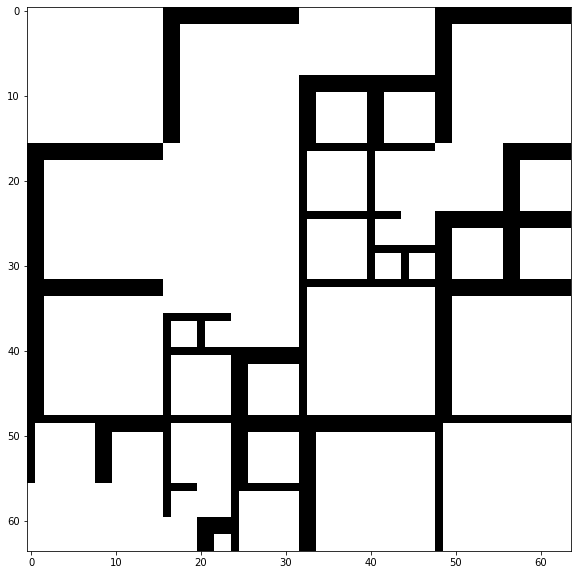

wzorzec gęstości macierzy po permutacji cuthill_mckee:


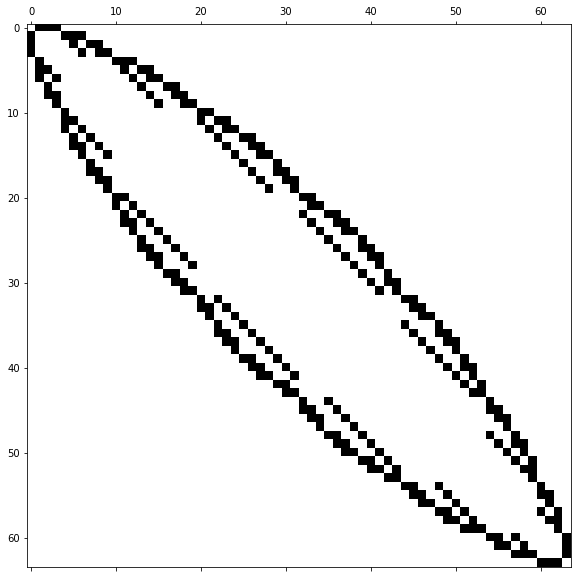

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	22936B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

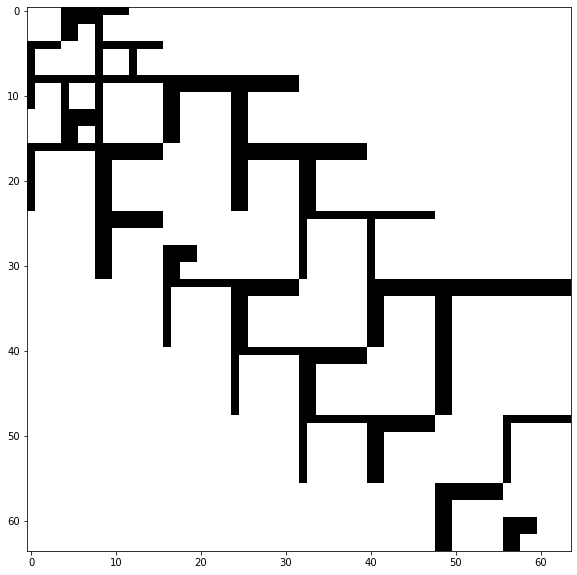

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


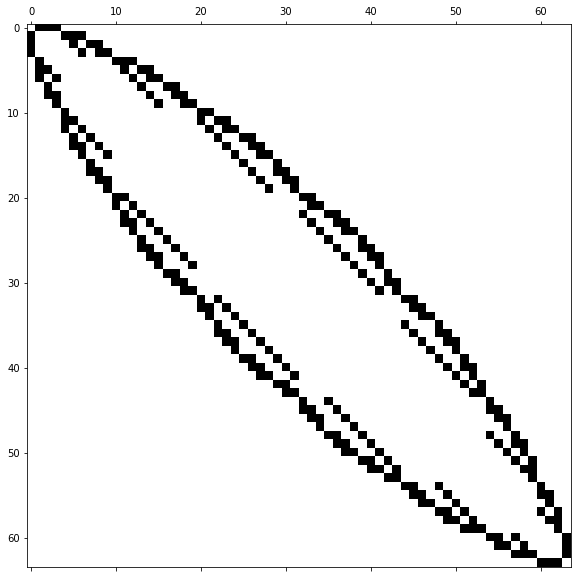

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	22936B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

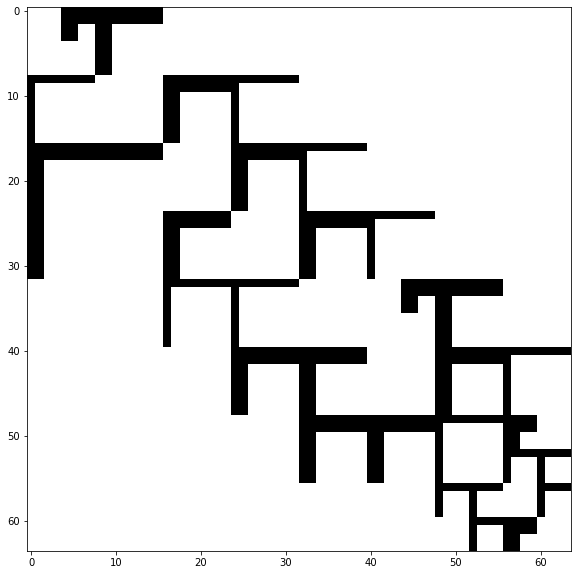

k =  3 

wzorzec gęstości macierzy przed kompresją:


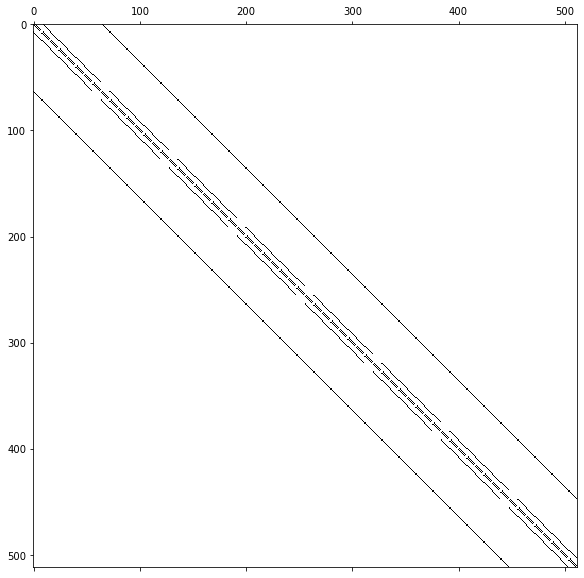

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	125256B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

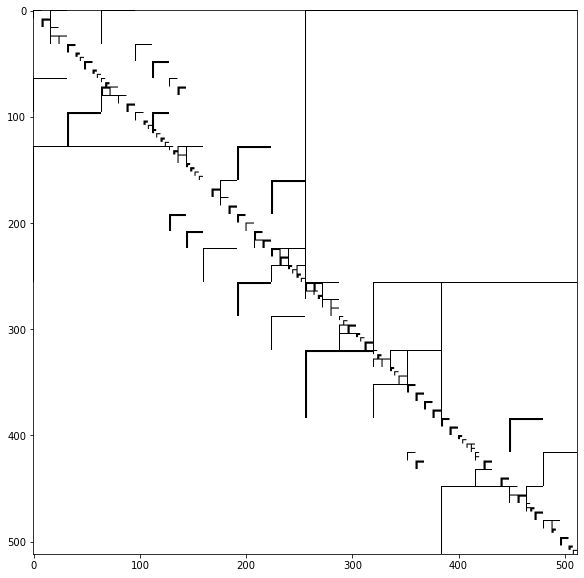

wzorzec gęstości macierzy po permutacji minimum_degree:


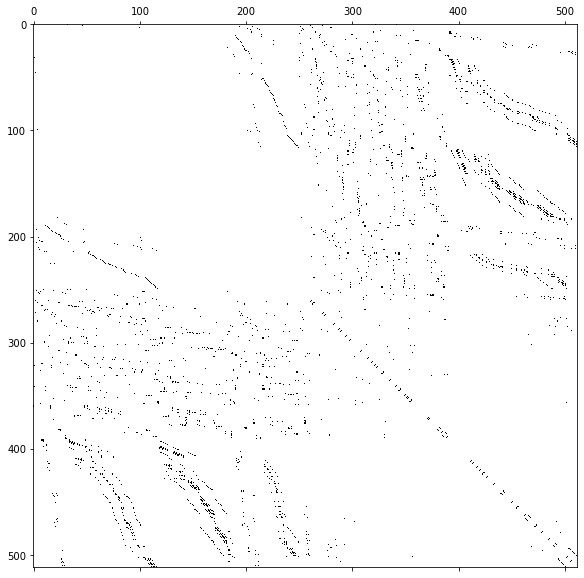

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	182920B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

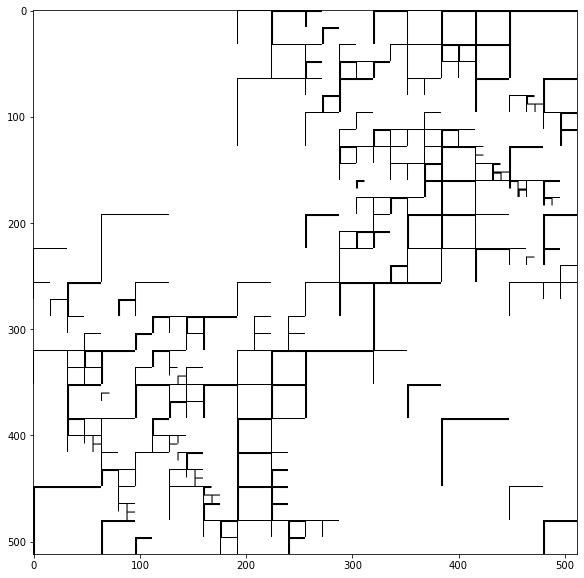

wzorzec gęstości macierzy po permutacji cuthill_mckee:


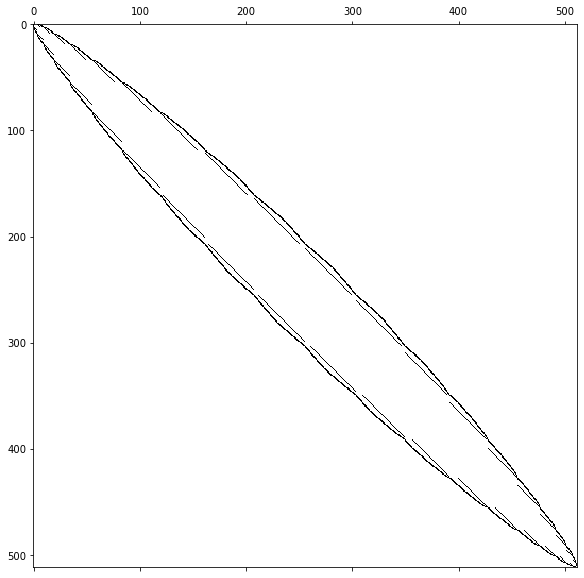

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	219872B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

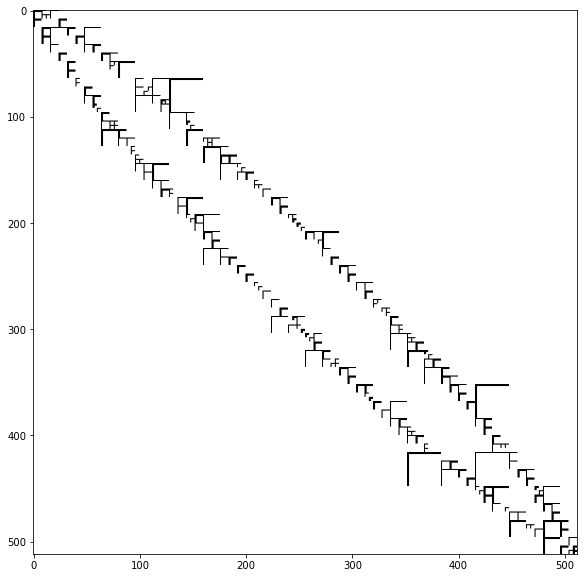

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


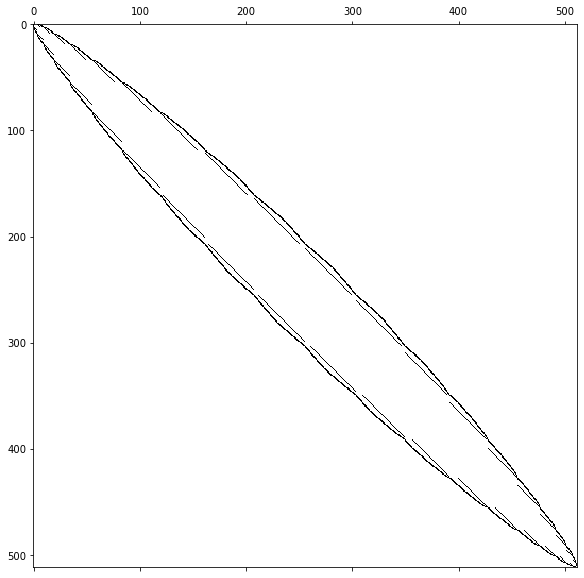

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	219872B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

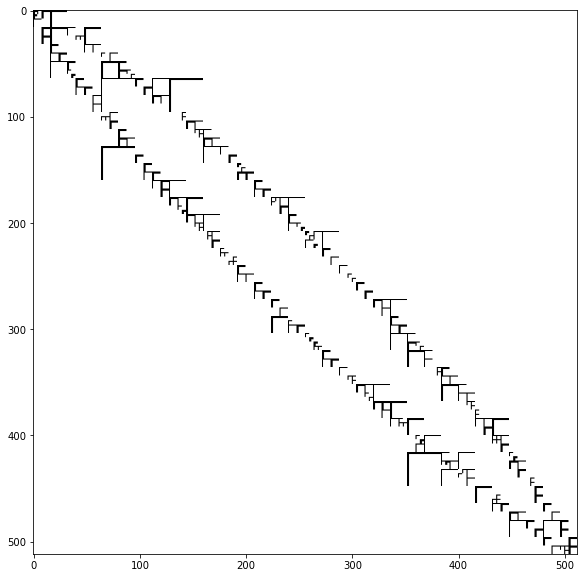

k =  4 

wzorzec gęstości macierzy przed kompresją:


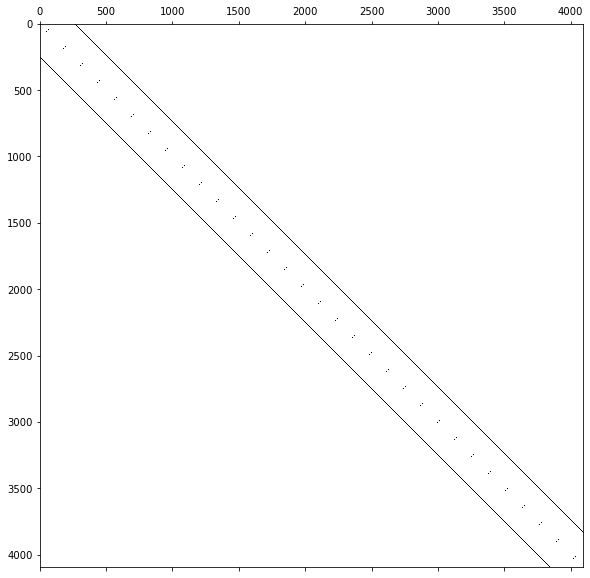

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	612616B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

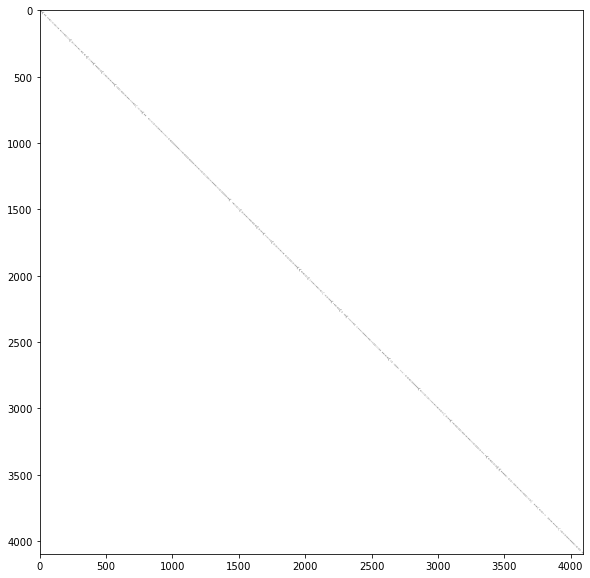

wzorzec gęstości macierzy po permutacji minimum_degree:


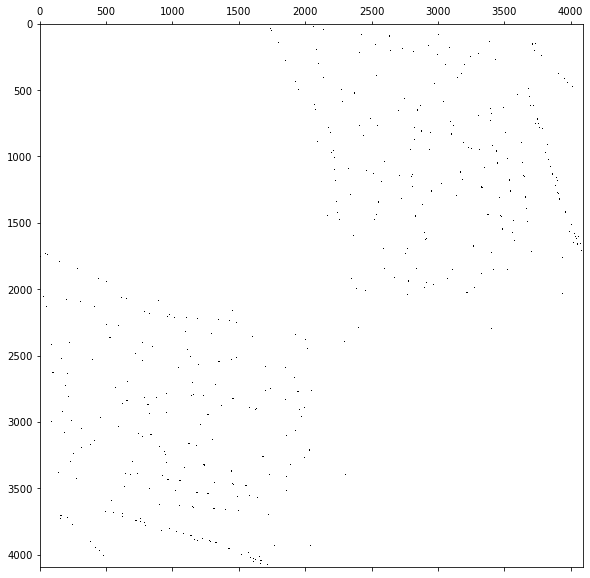

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	1942216B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

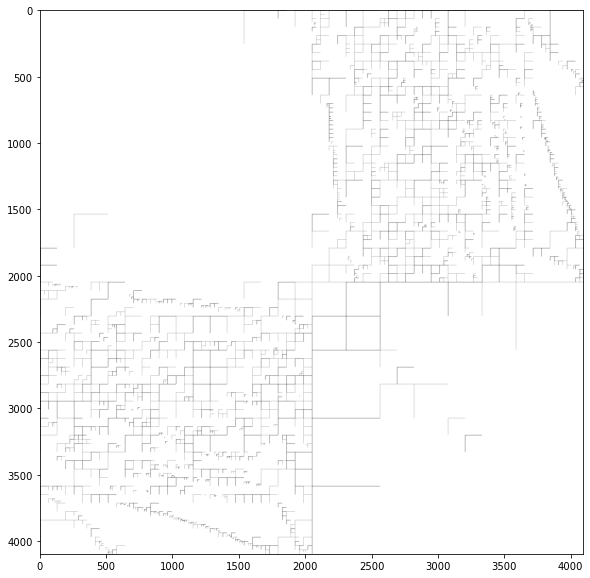

wzorzec gęstości macierzy po permutacji cuthill_mckee:


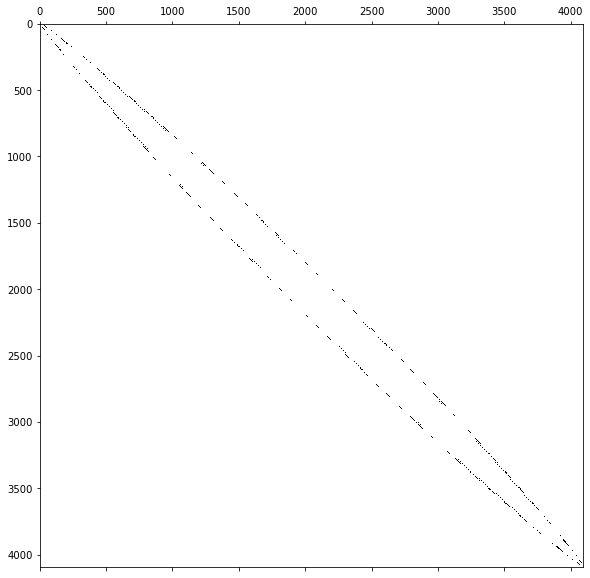

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	1521296B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

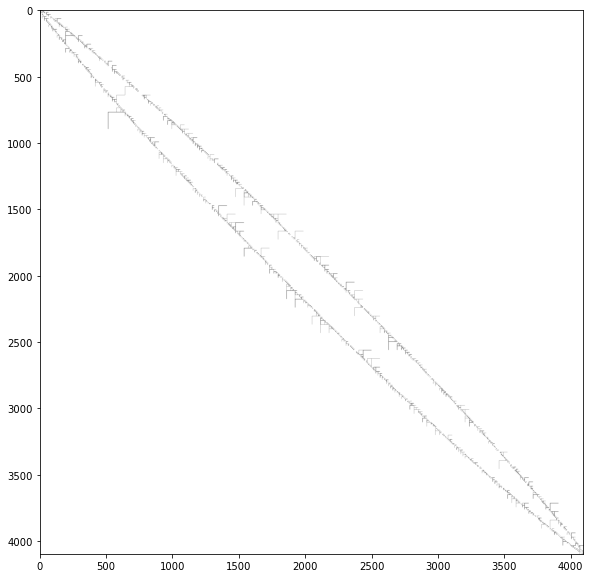

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


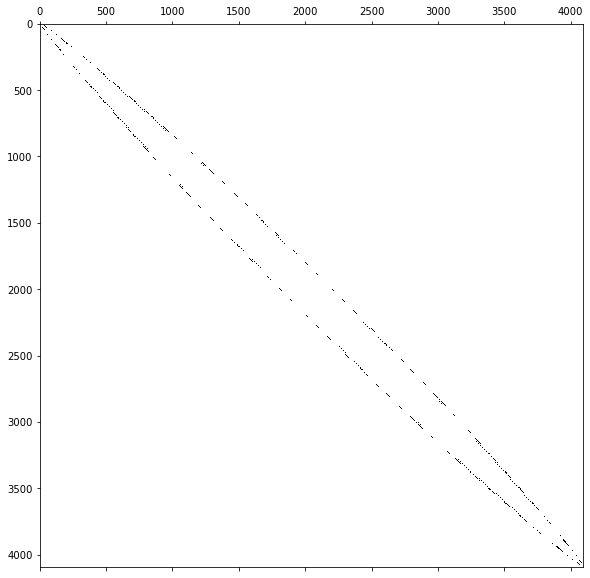

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	1521296B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

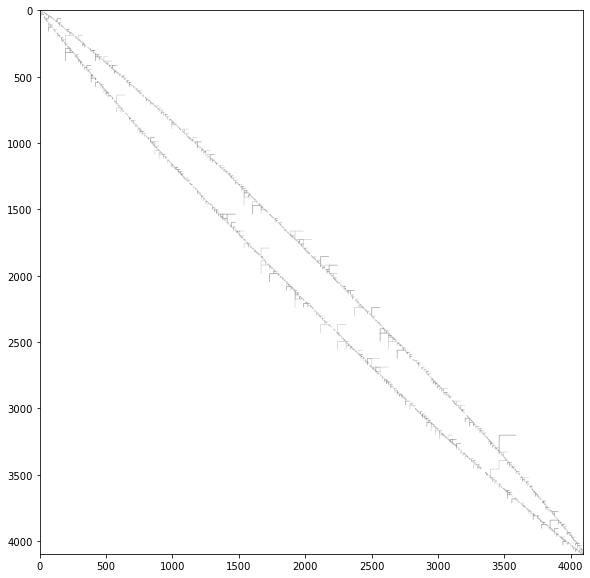

test for δ = size/2, b = 4
k =  2 

wzorzec gęstości macierzy przed kompresją:


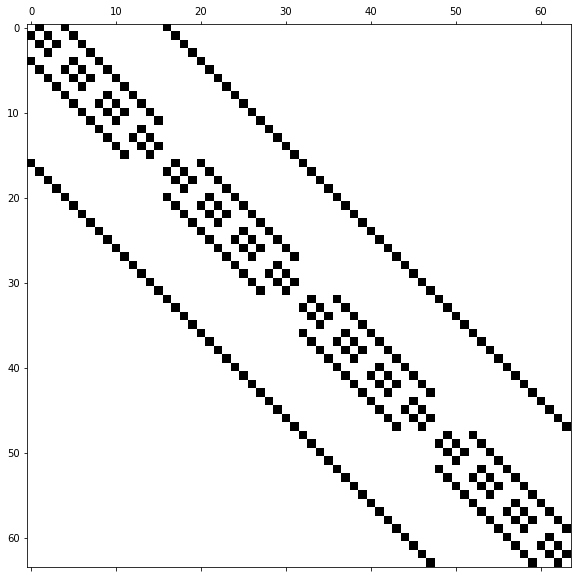

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	11744B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

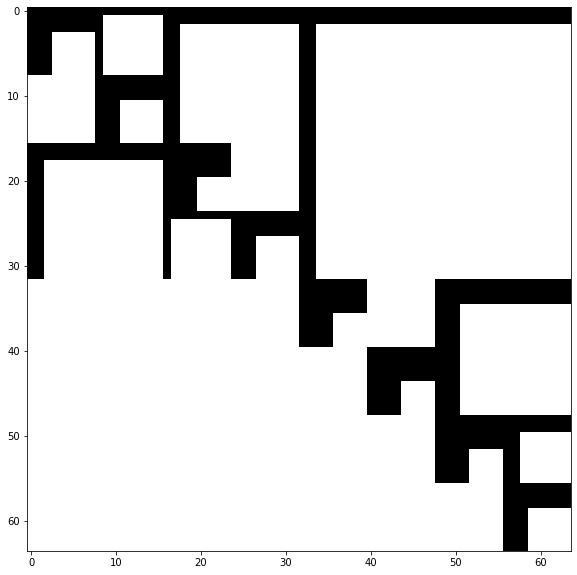

wzorzec gęstości macierzy po permutacji minimum_degree:


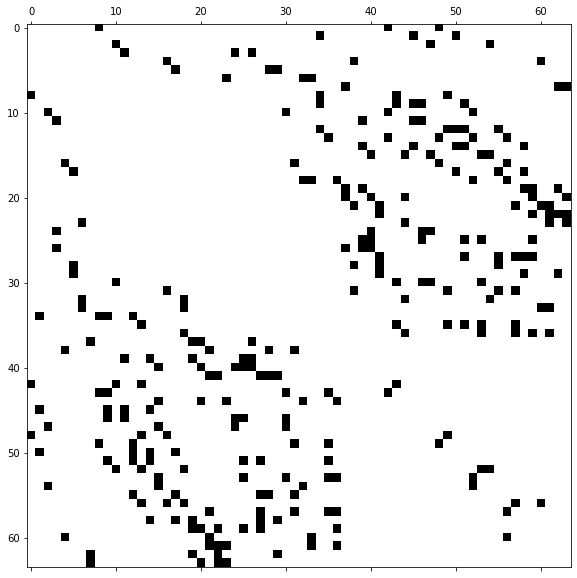

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	16056B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

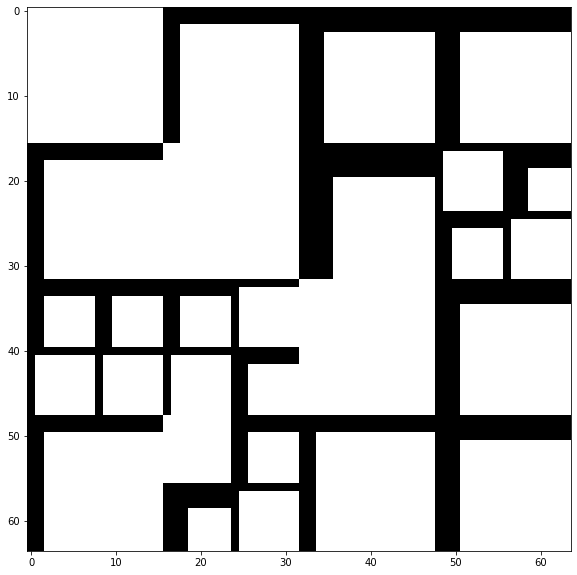

wzorzec gęstości macierzy po permutacji cuthill_mckee:


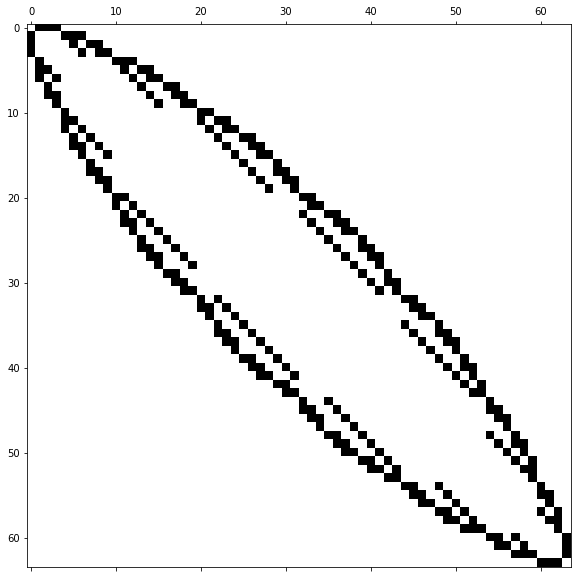

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	17048B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

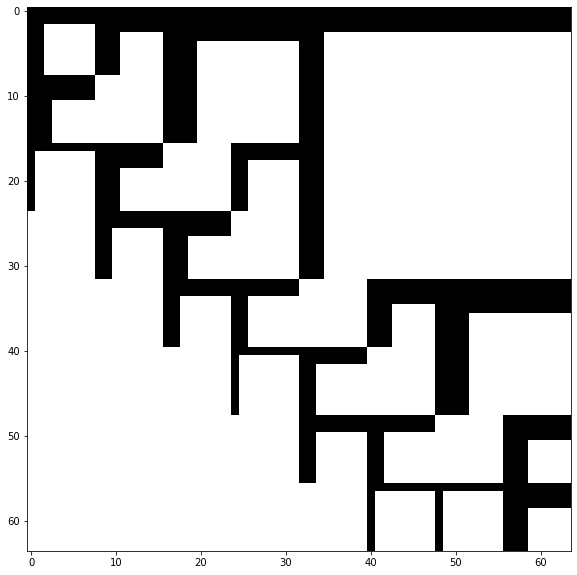

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


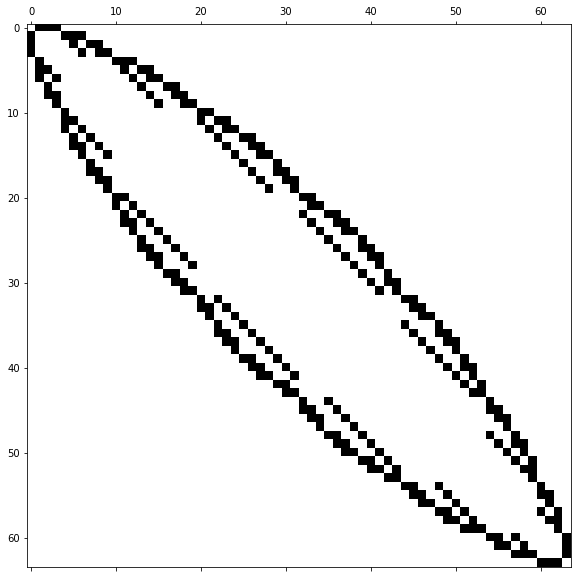

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	17048B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

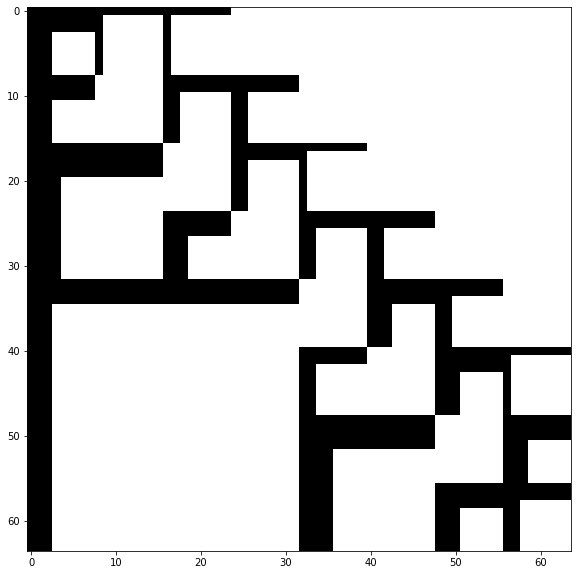

k =  3 

wzorzec gęstości macierzy przed kompresją:


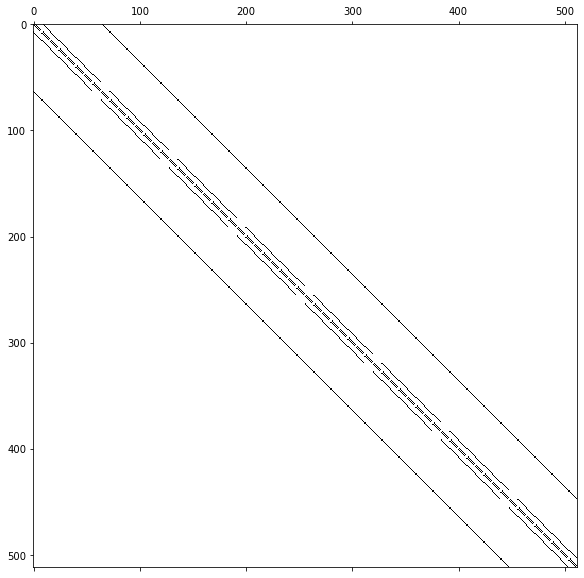

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	98568B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

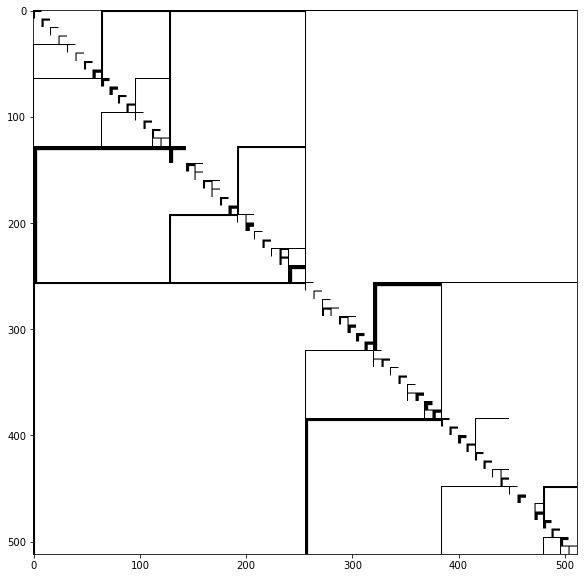

wzorzec gęstości macierzy po permutacji minimum_degree:


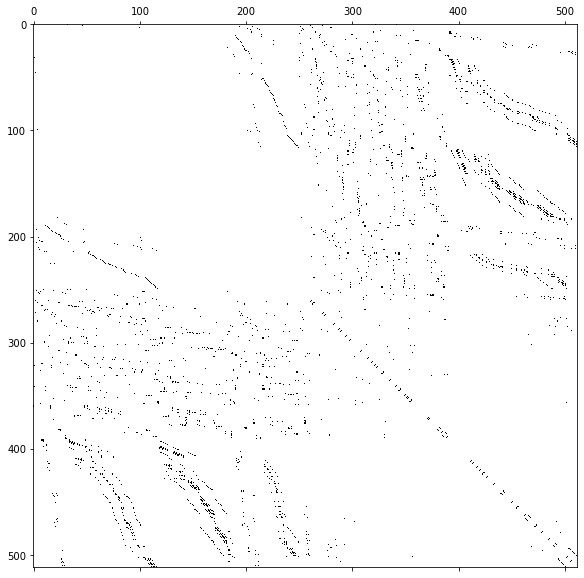

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	154608B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

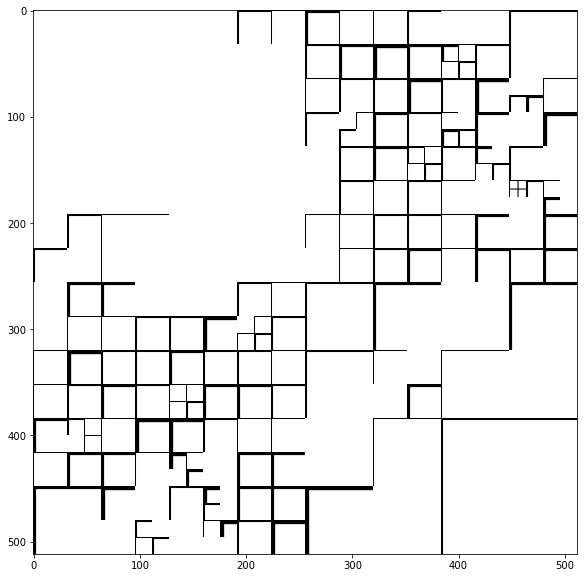

wzorzec gęstości macierzy po permutacji cuthill_mckee:


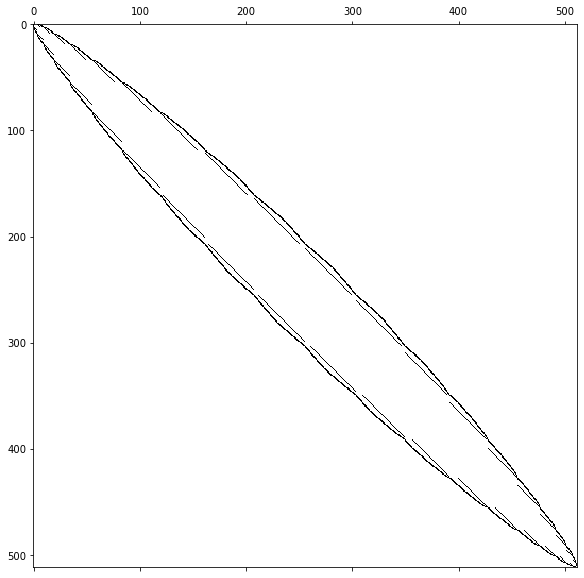

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	163856B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

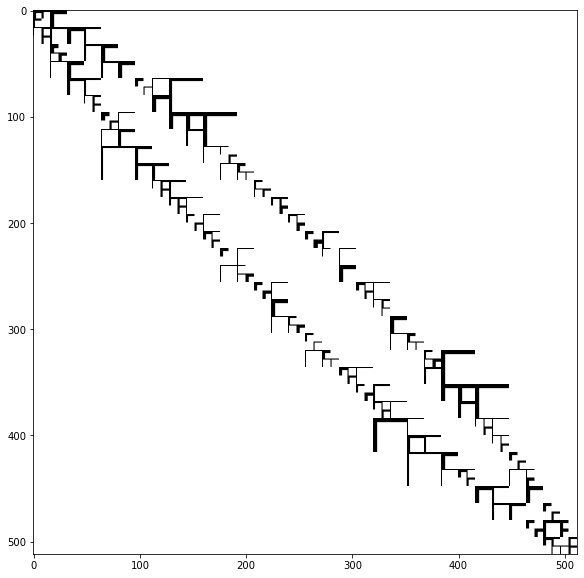

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


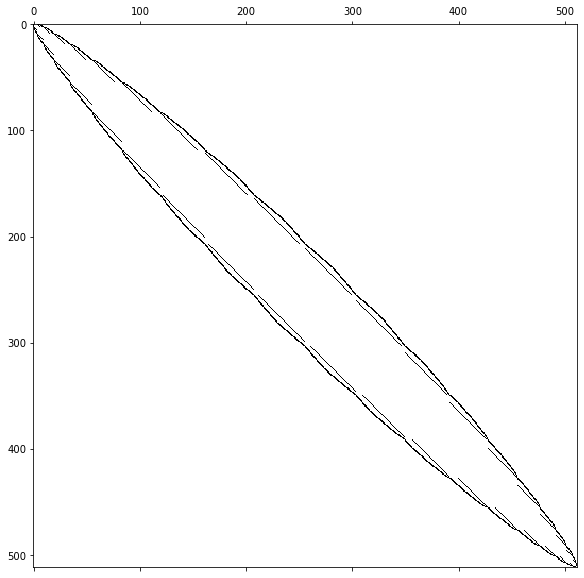

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	163856B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

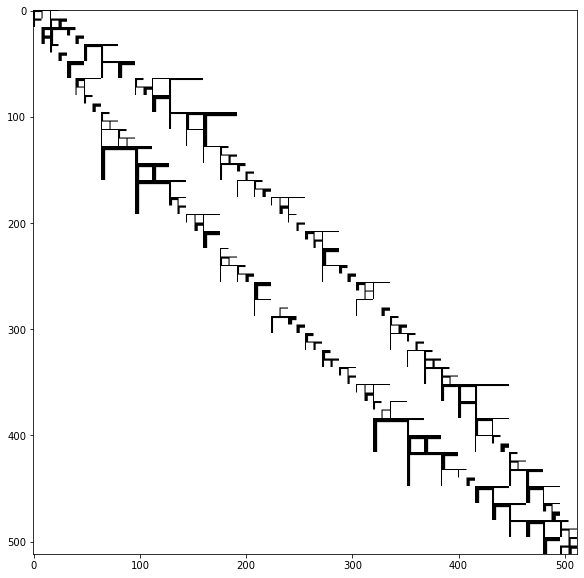

k =  4 

wzorzec gęstości macierzy przed kompresją:


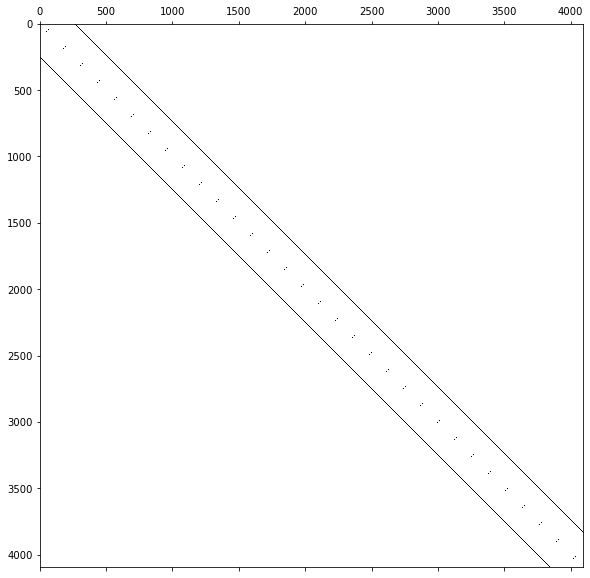

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	432672B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

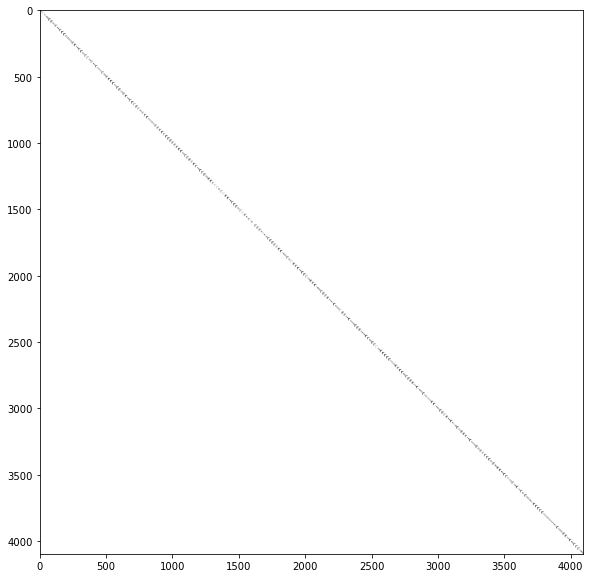

wzorzec gęstości macierzy po permutacji minimum_degree:


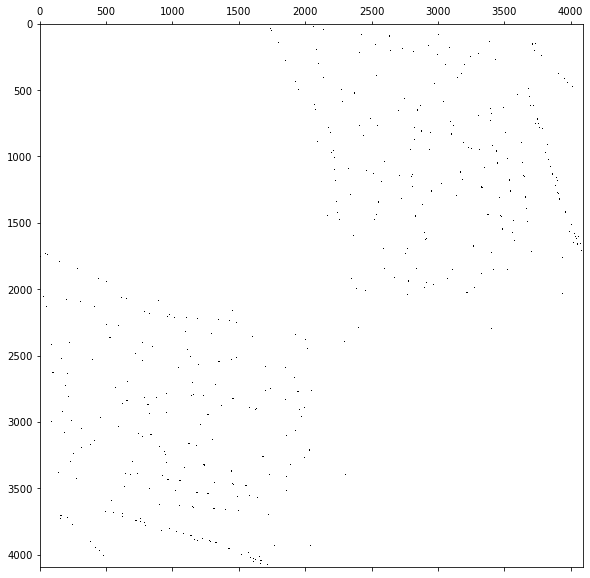

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	1977072B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

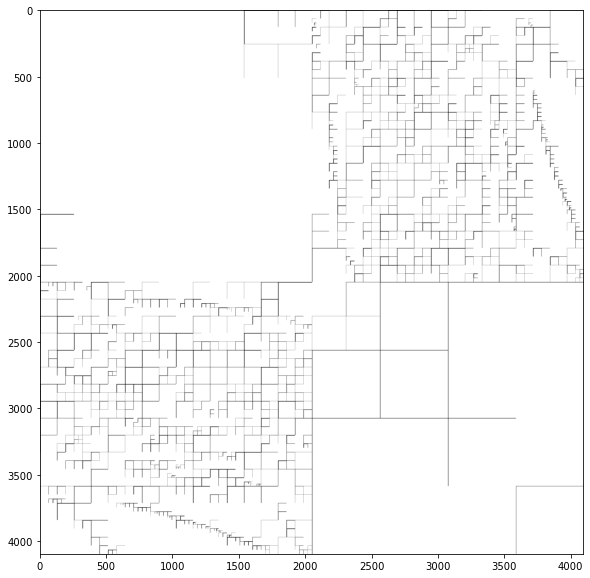

wzorzec gęstości macierzy po permutacji cuthill_mckee:


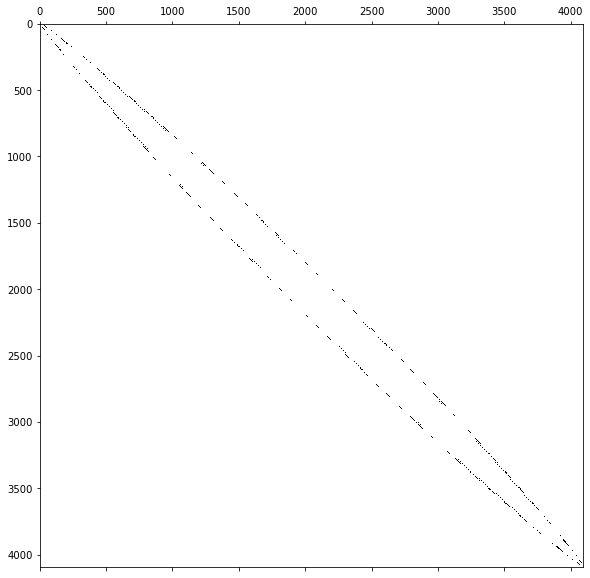

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	1196408B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

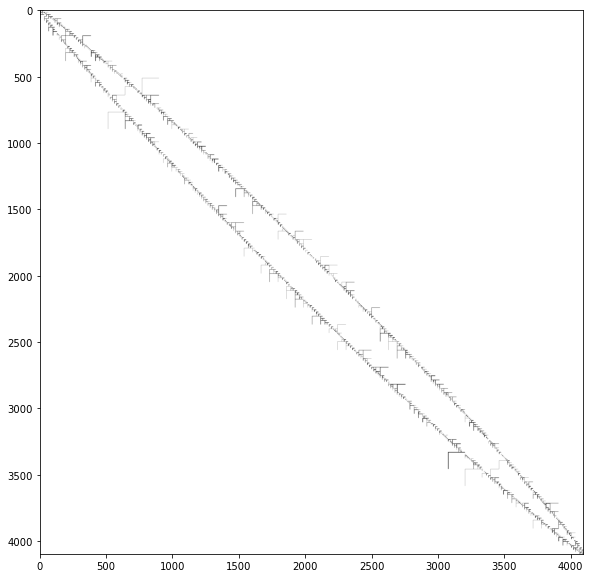

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


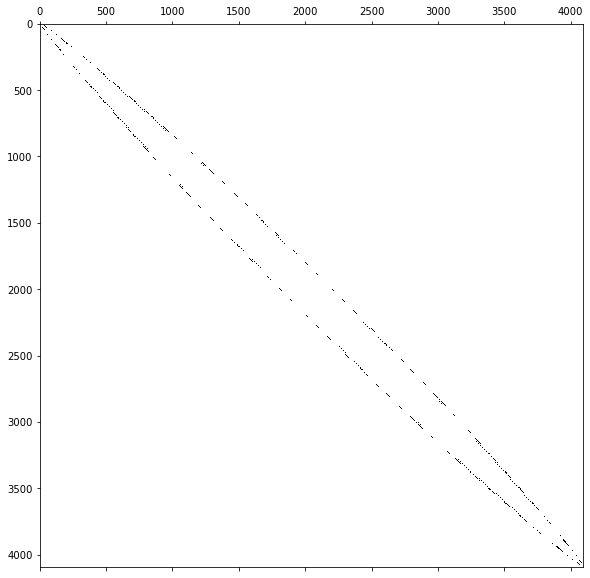

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	1196408B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

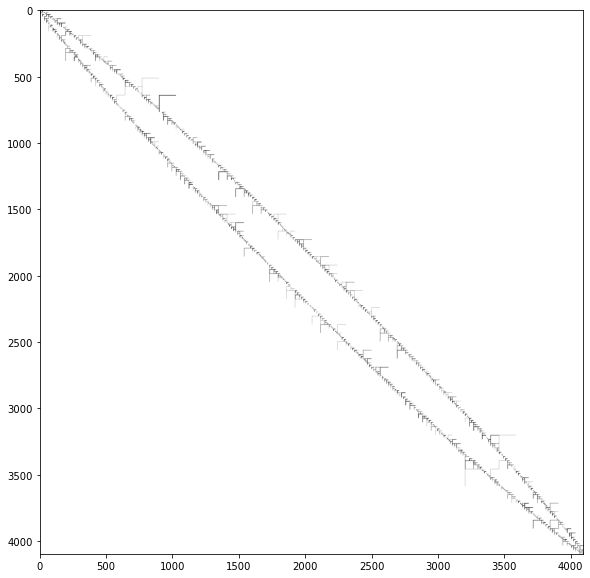

test for δ = size/2, b = 8
k =  2 

wzorzec gęstości macierzy przed kompresją:


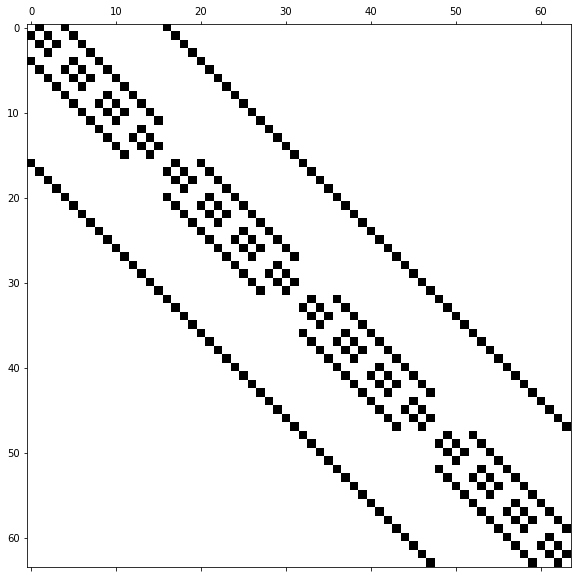

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	10808B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

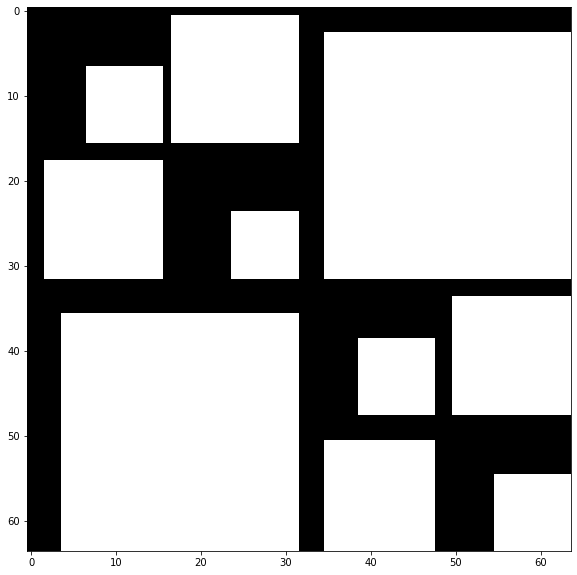

wzorzec gęstości macierzy po permutacji minimum_degree:


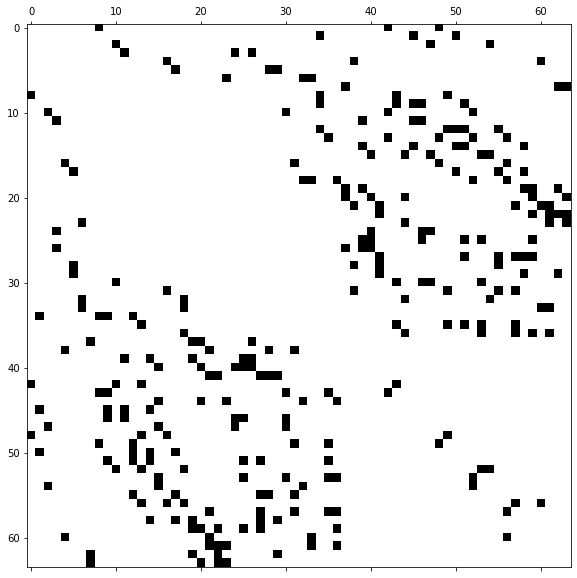

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	11960B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

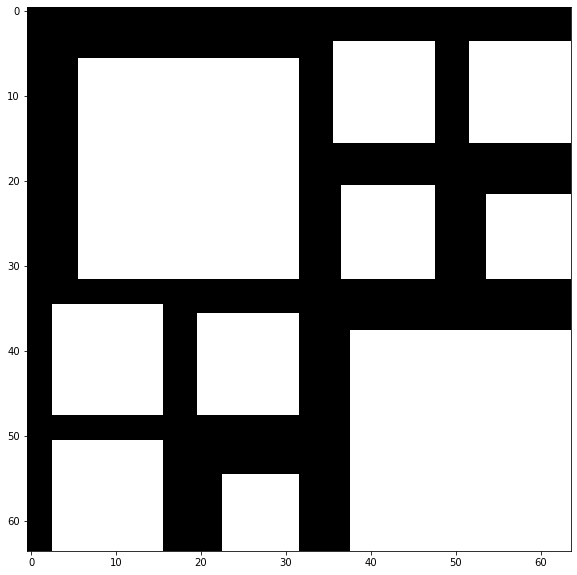

wzorzec gęstości macierzy po permutacji cuthill_mckee:


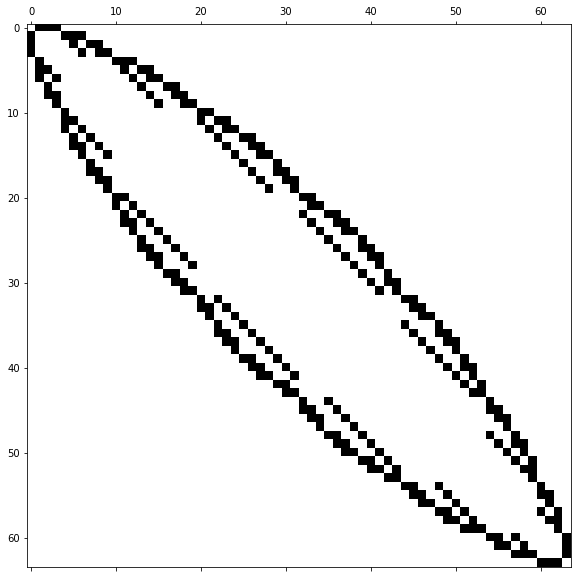

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	12216B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

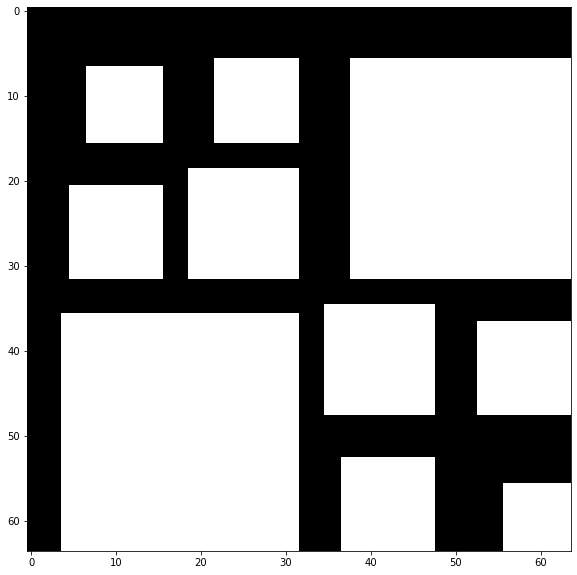

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


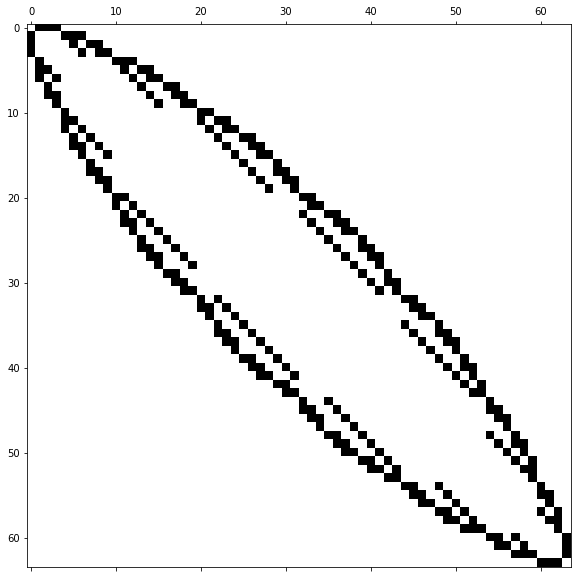

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	12216B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

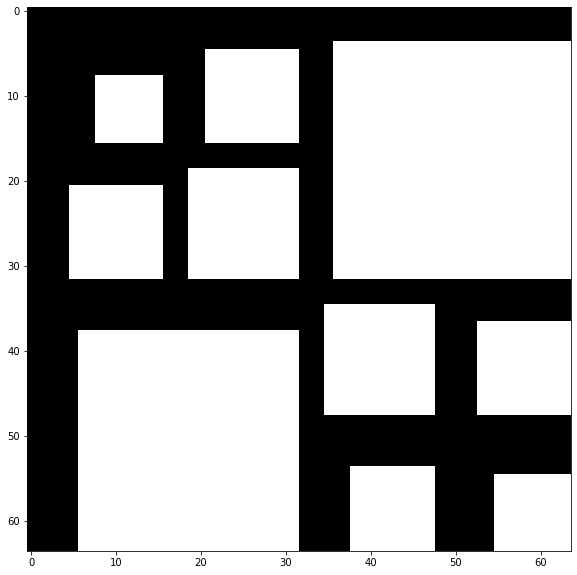

k =  3 

wzorzec gęstości macierzy przed kompresją:


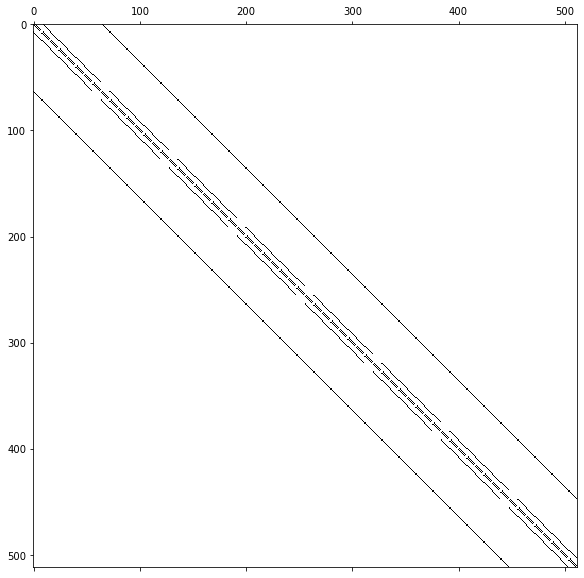

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	70392B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

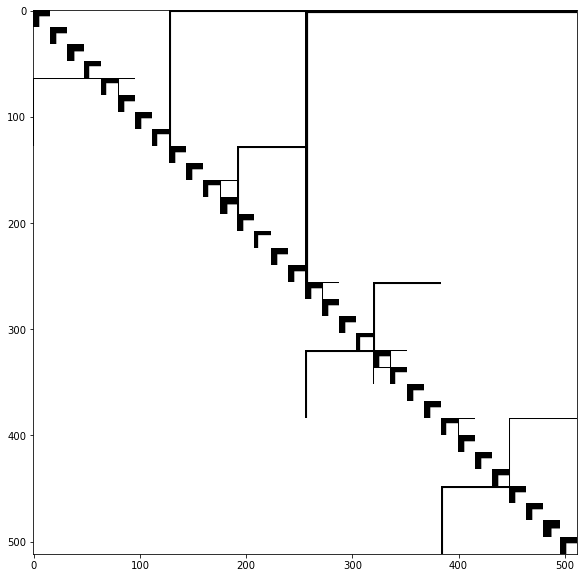

wzorzec gęstości macierzy po permutacji minimum_degree:


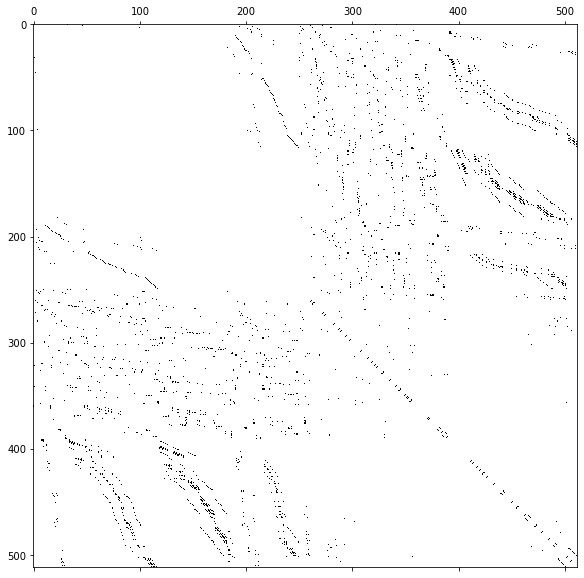

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	163200B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

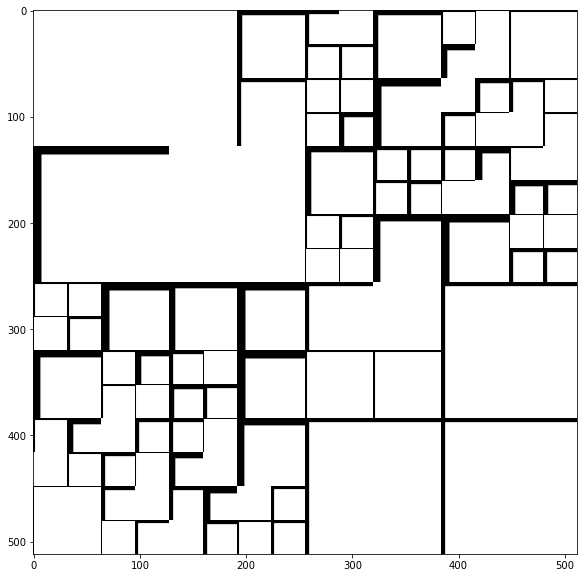

wzorzec gęstości macierzy po permutacji cuthill_mckee:


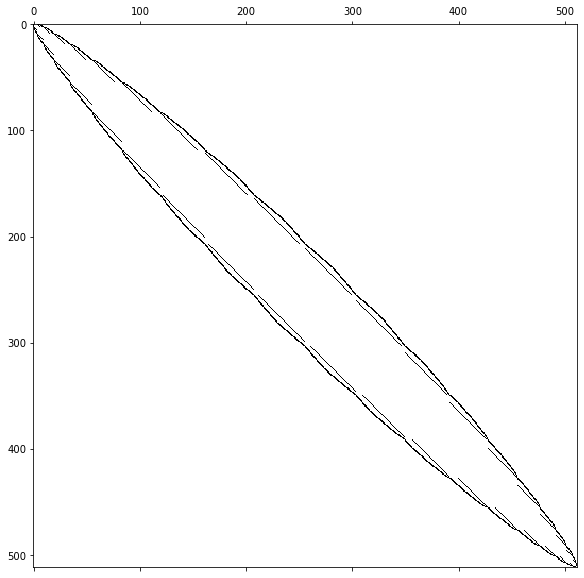

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	129144B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

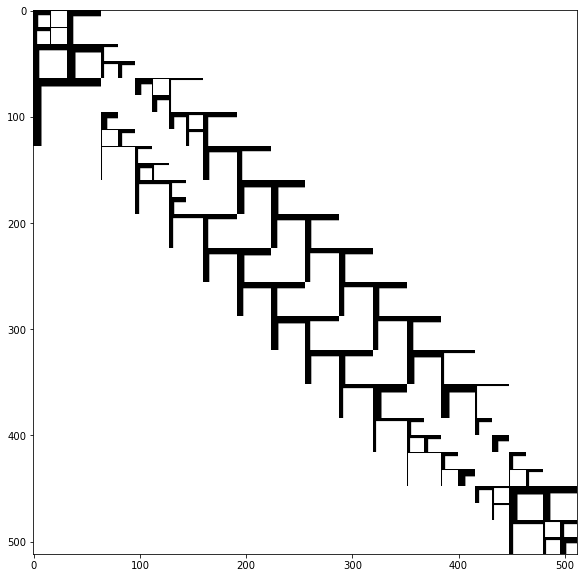

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


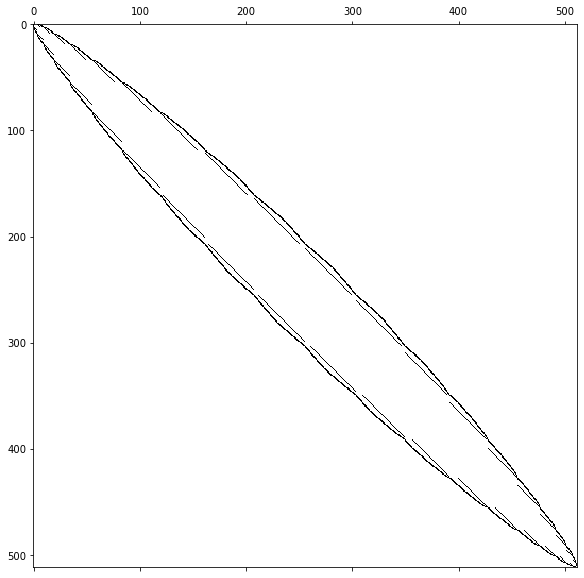

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	129144B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

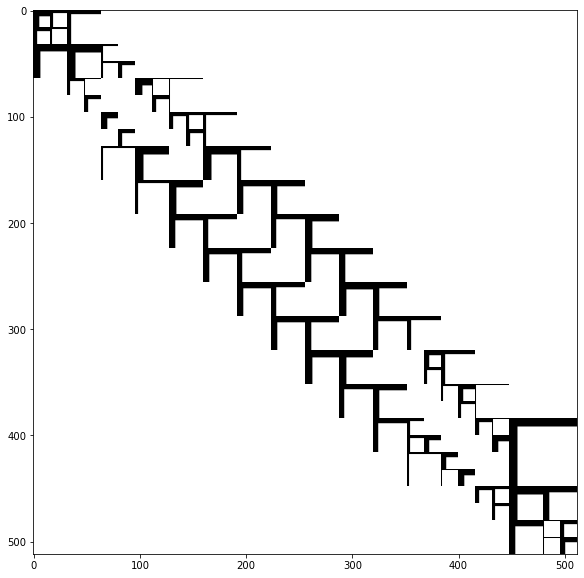

k =  4 

wzorzec gęstości macierzy przed kompresją:


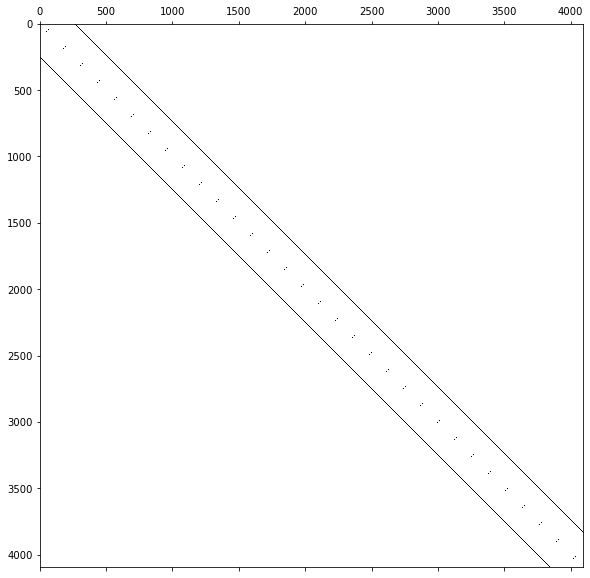

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	373728B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

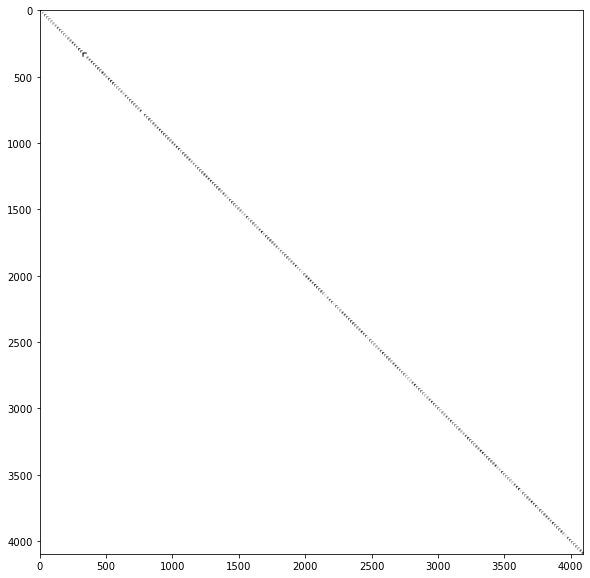

wzorzec gęstości macierzy po permutacji minimum_degree:


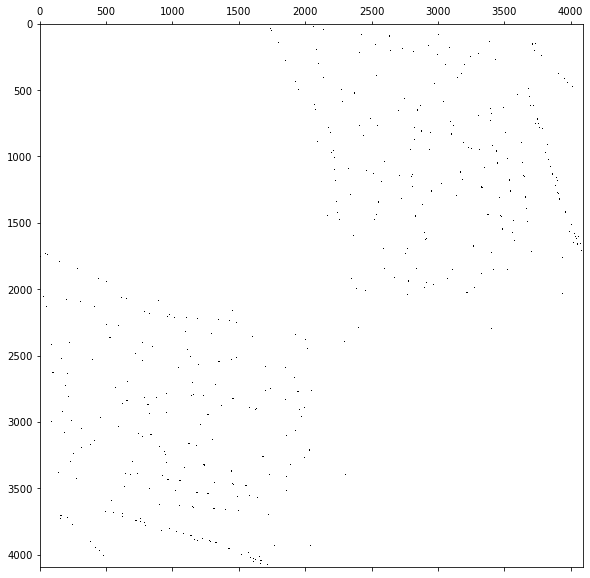

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	2538256B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

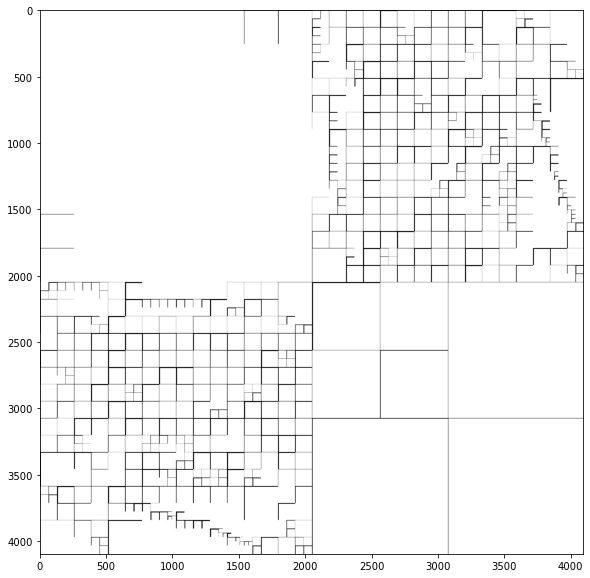

wzorzec gęstości macierzy po permutacji cuthill_mckee:


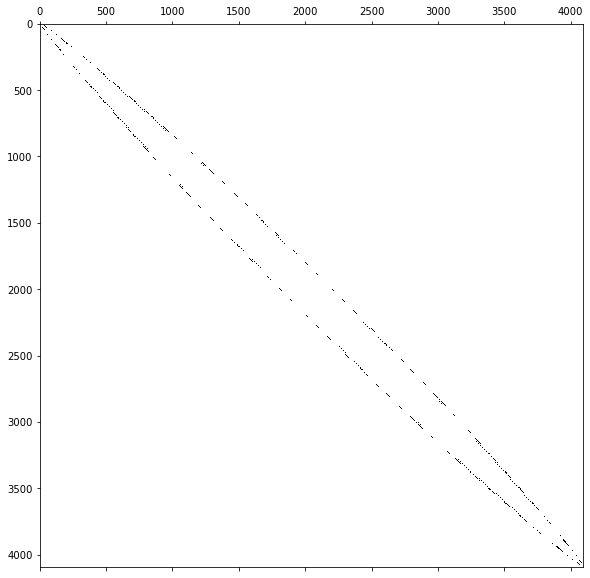

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	1123816B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

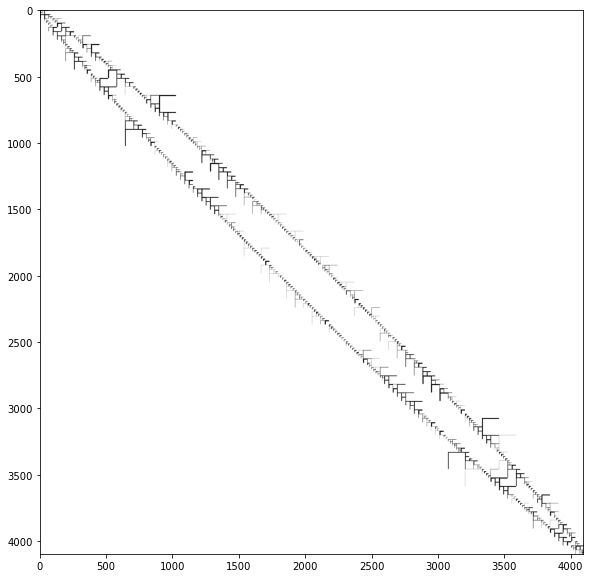

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


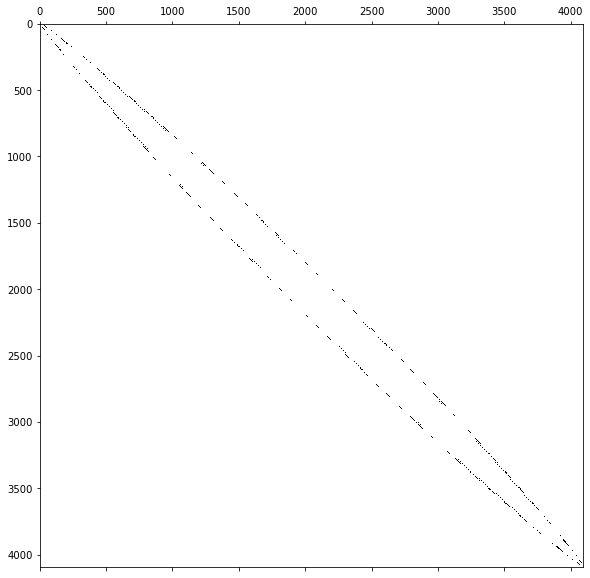

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	1123816B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

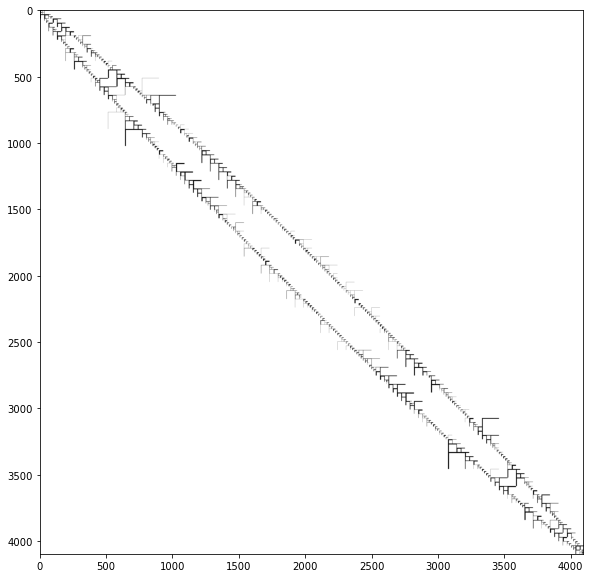

test for δ = size/3, b = 2
k =  2 

wzorzec gęstości macierzy przed kompresją:


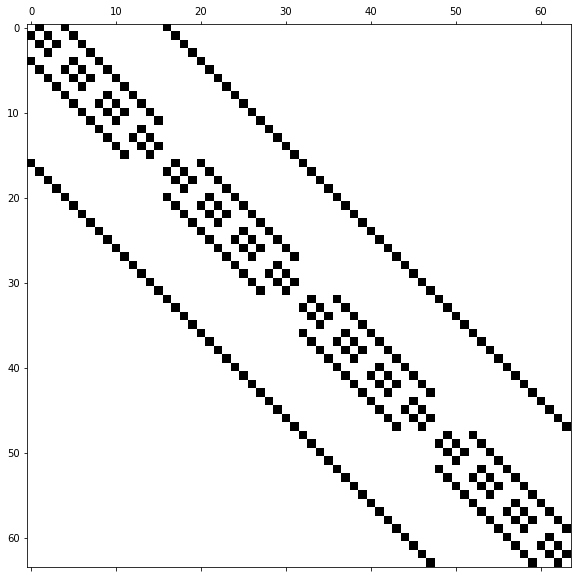

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	8072B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

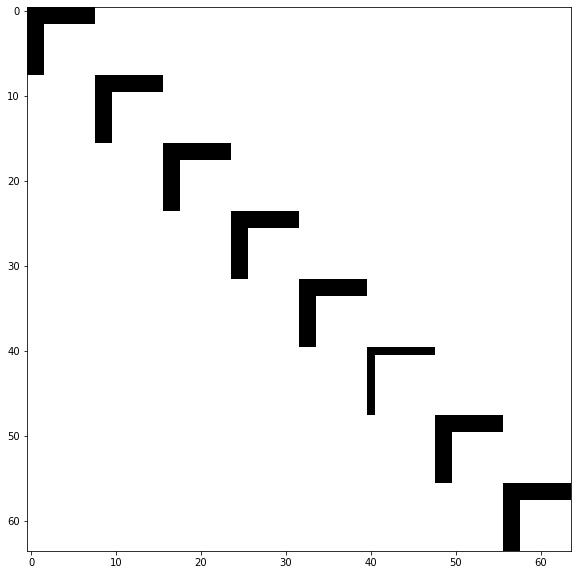

wzorzec gęstości macierzy po permutacji minimum_degree:


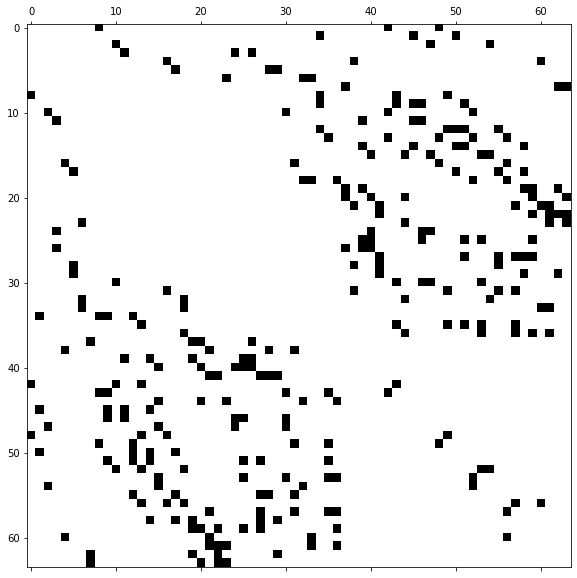

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	9080B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

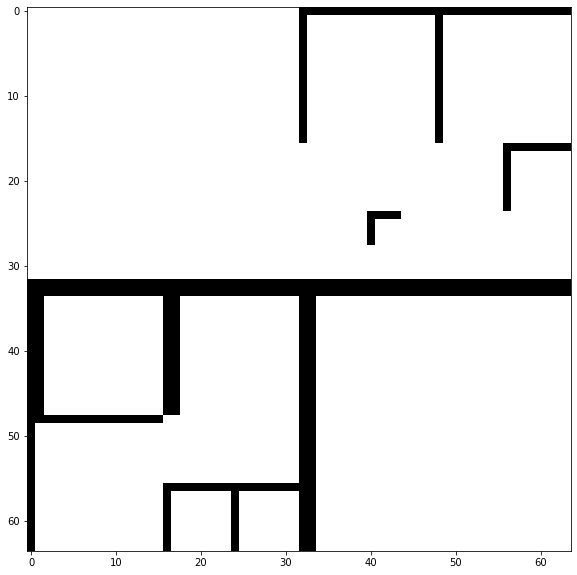

wzorzec gęstości macierzy po permutacji cuthill_mckee:


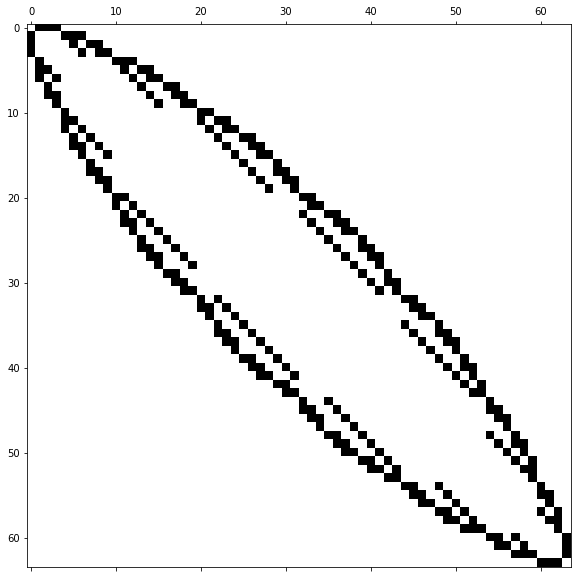

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	11200B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

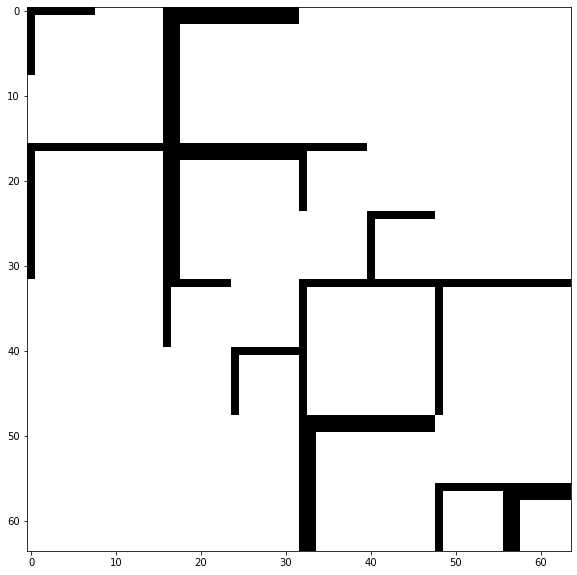

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


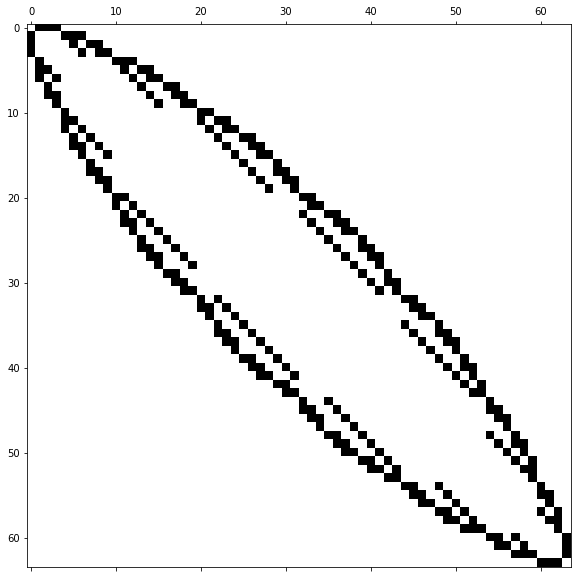

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	11200B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

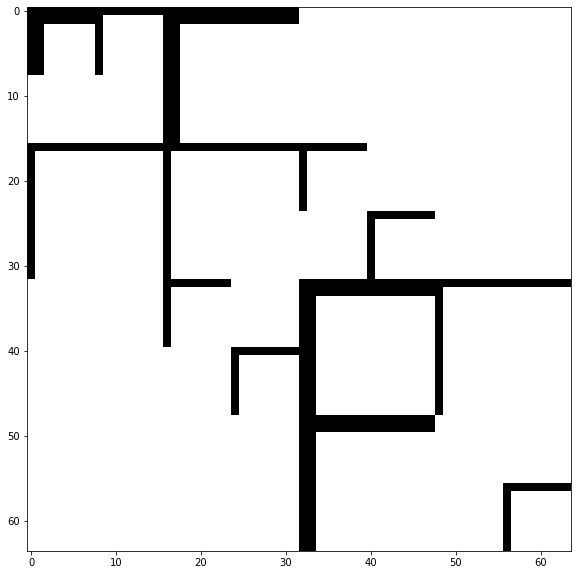

k =  3 

wzorzec gęstości macierzy przed kompresją:


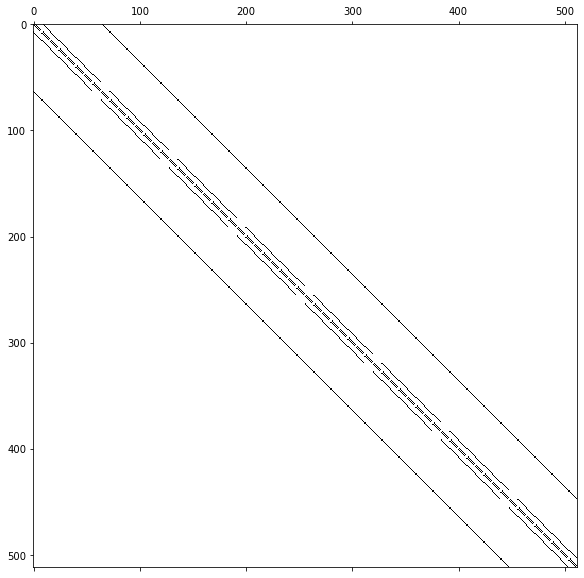

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	50104B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

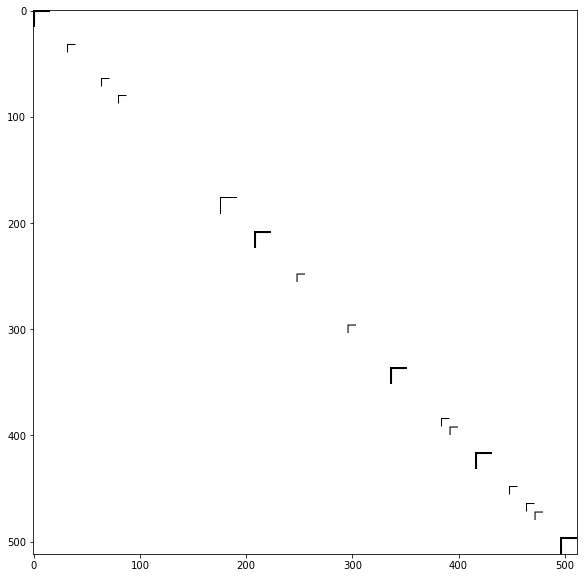

wzorzec gęstości macierzy po permutacji minimum_degree:


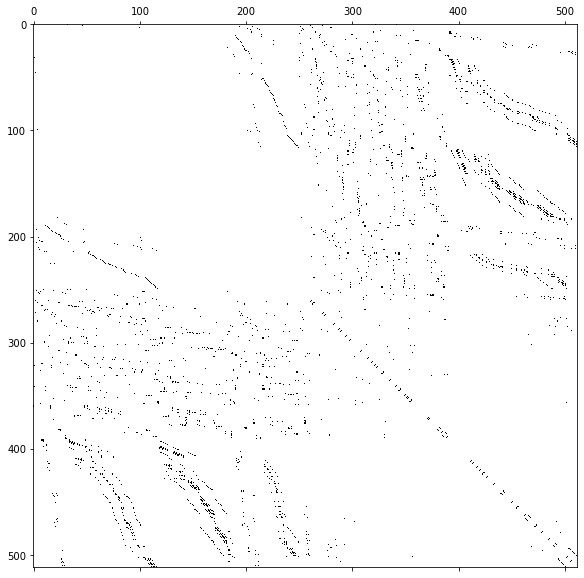

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	67232B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

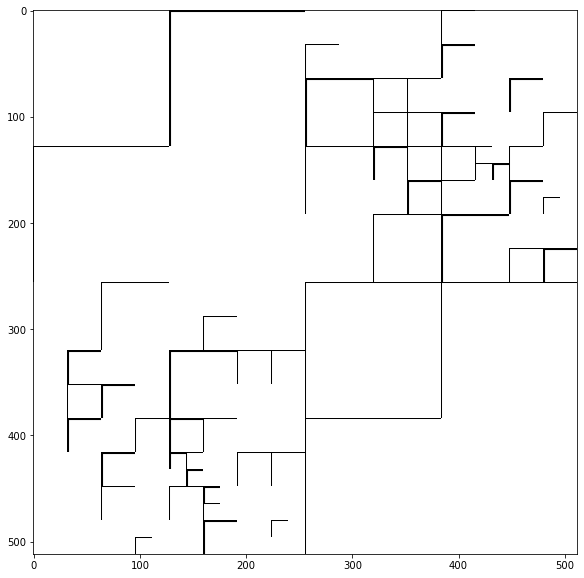

wzorzec gęstości macierzy po permutacji cuthill_mckee:


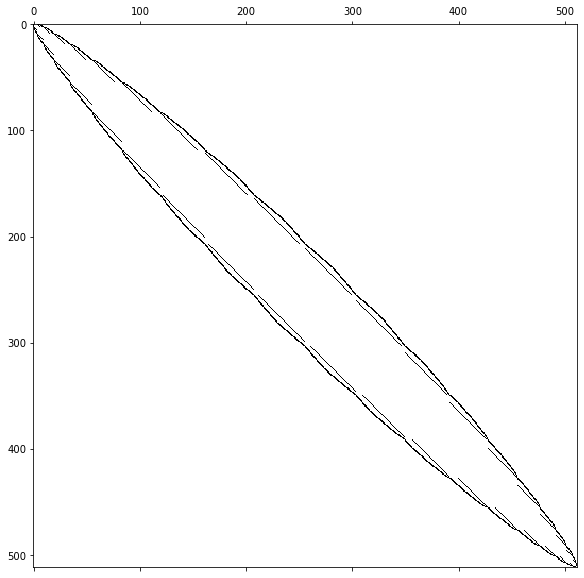

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	91464B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

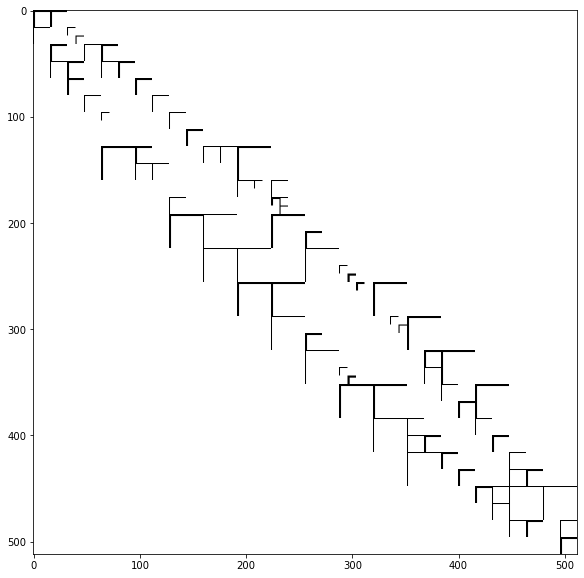

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


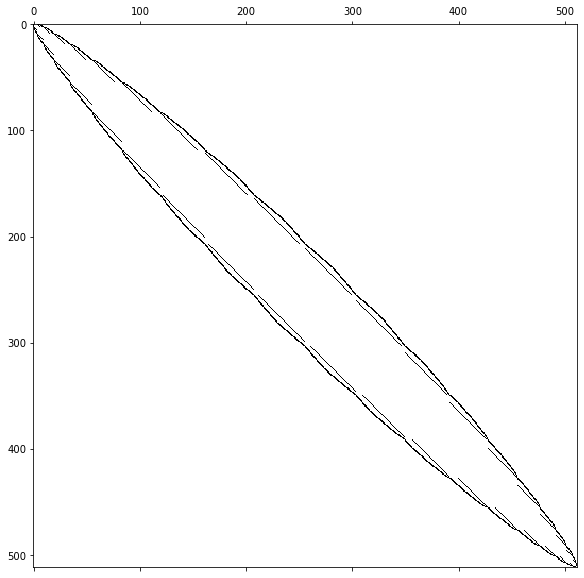

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	91464B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

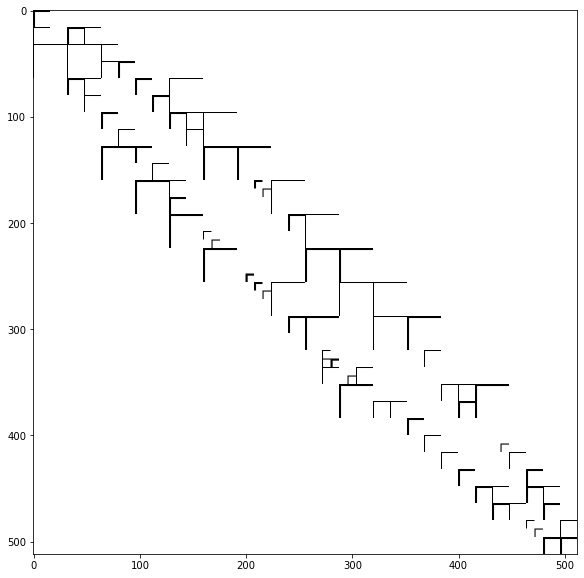

k =  4 

wzorzec gęstości macierzy przed kompresją:


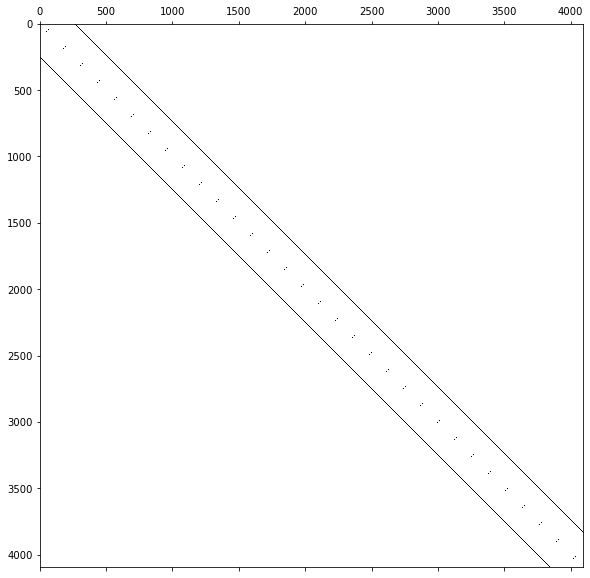

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	234168B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

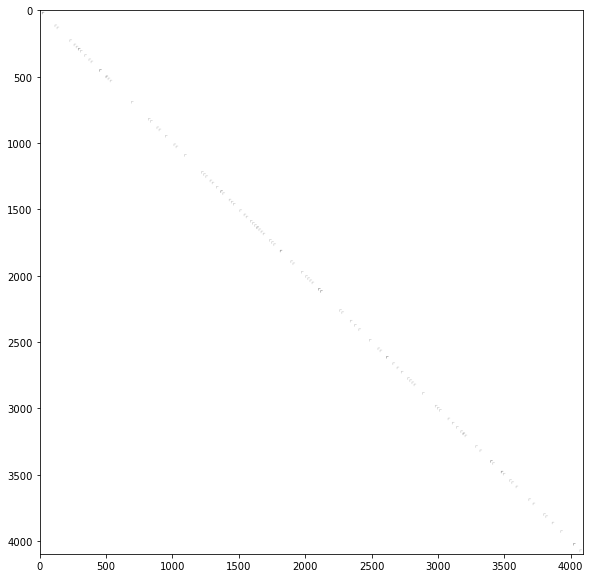

wzorzec gęstości macierzy po permutacji minimum_degree:


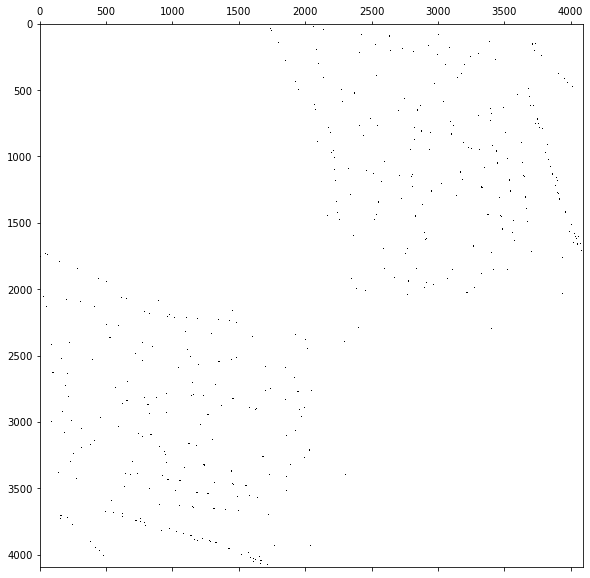

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	892368B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

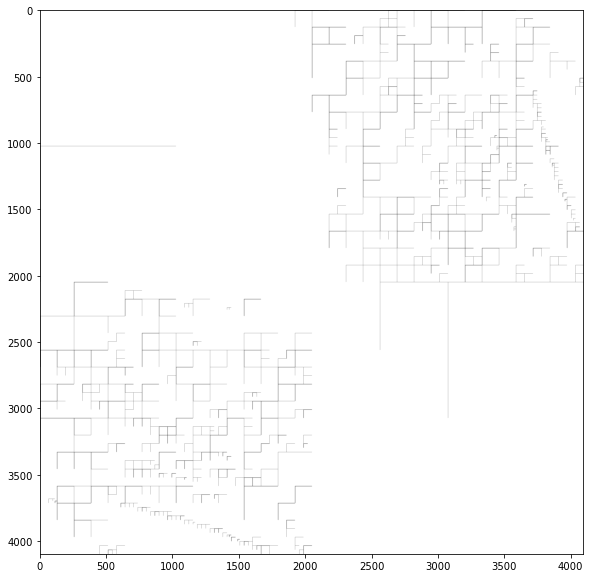

wzorzec gęstości macierzy po permutacji cuthill_mckee:


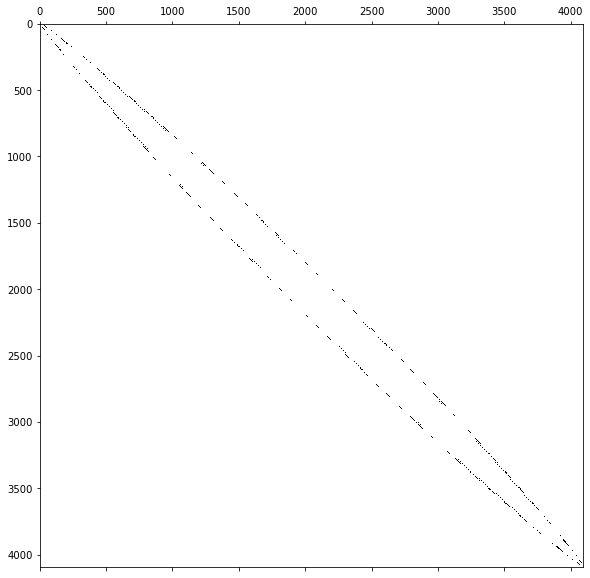

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	632736B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

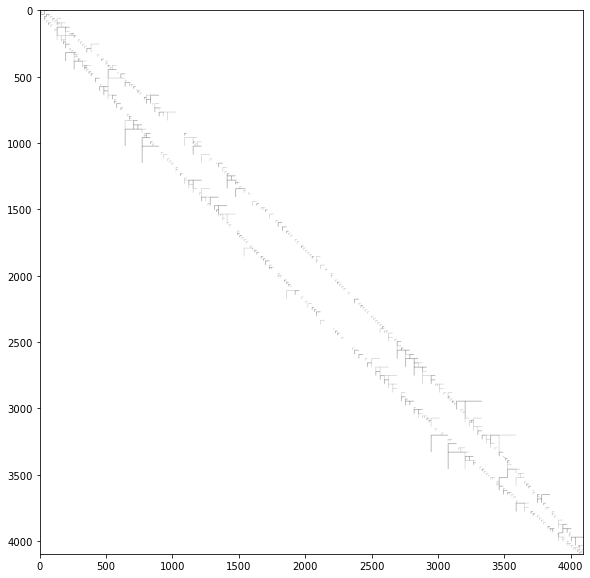

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


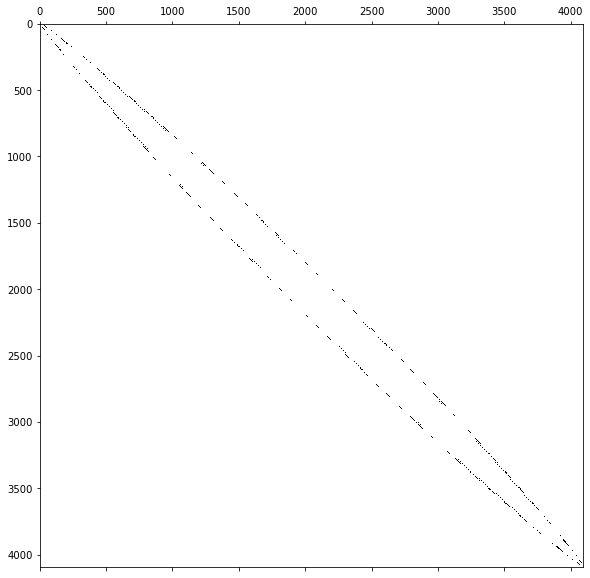

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	632736B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

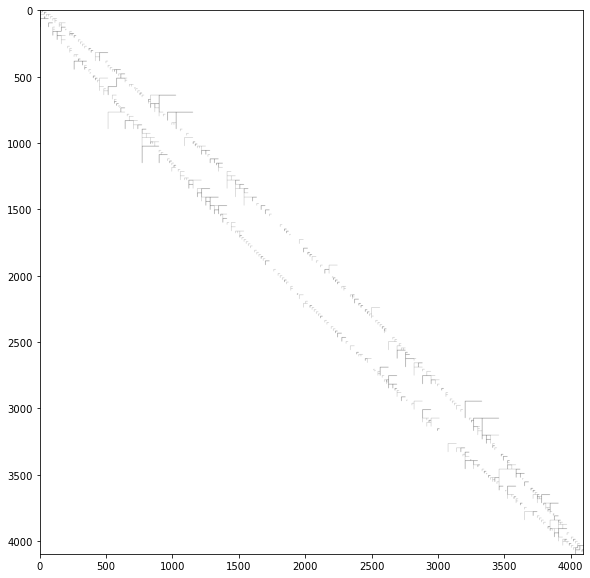

test for δ = size/3, b = 4
k =  2 

wzorzec gęstości macierzy przed kompresją:


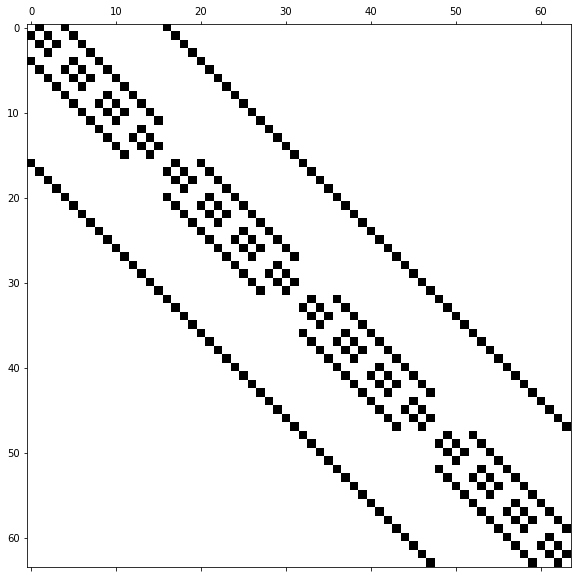

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	5832B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

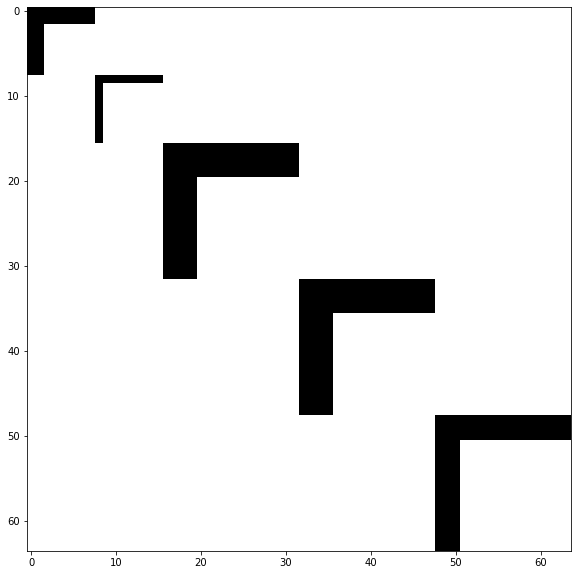

wzorzec gęstości macierzy po permutacji minimum_degree:


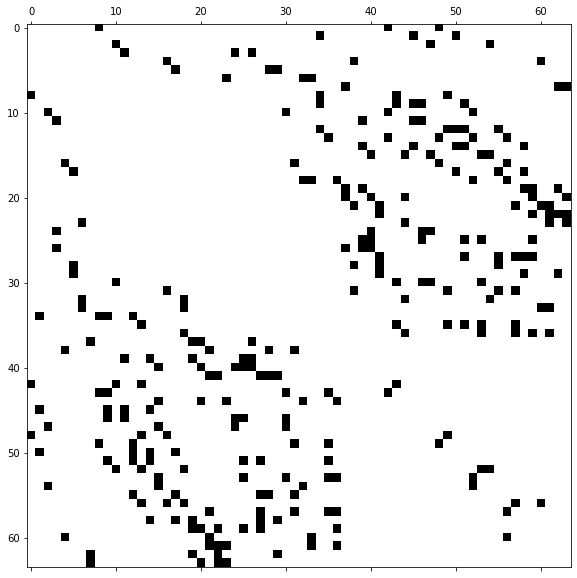

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	6160B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

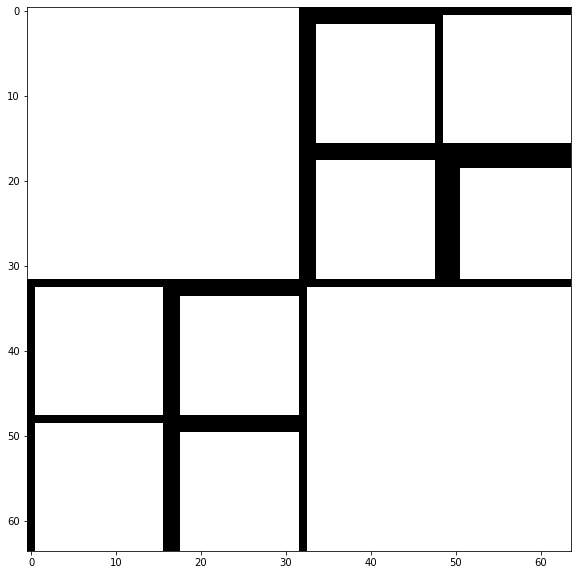

wzorzec gęstości macierzy po permutacji cuthill_mckee:


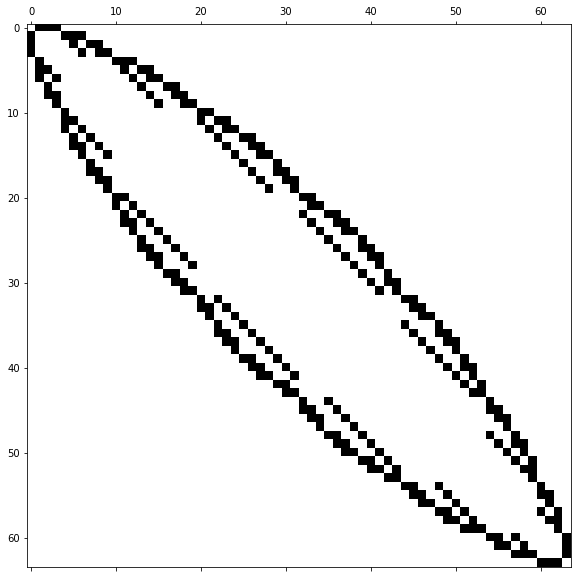

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	7440B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

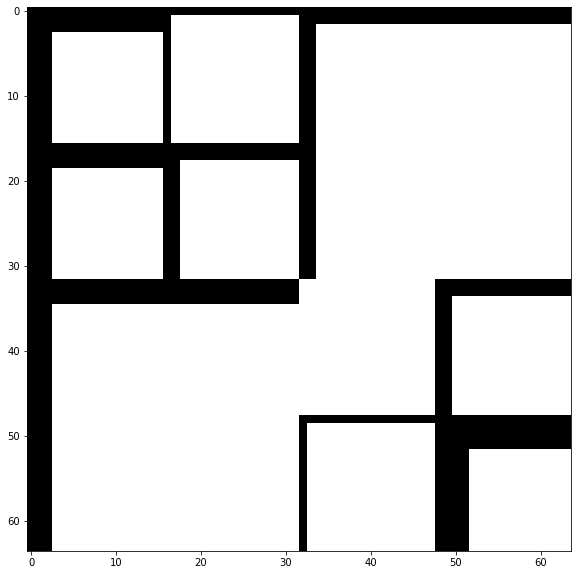

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


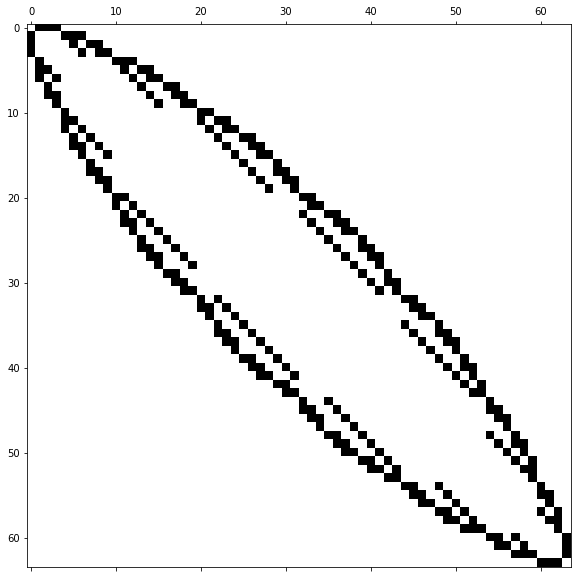

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	7440B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

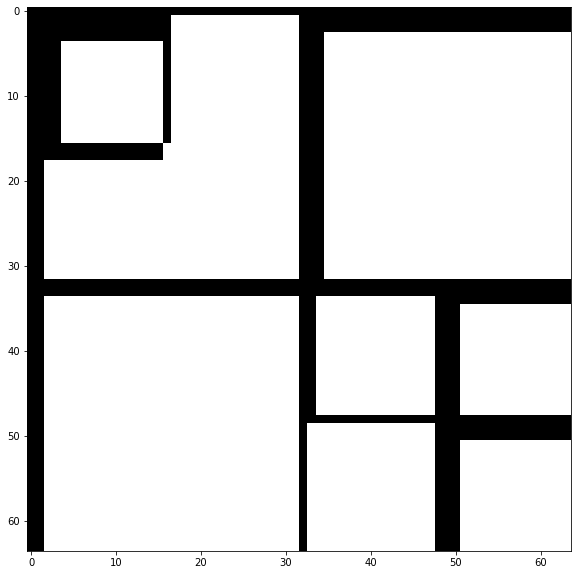

k =  3 

wzorzec gęstości macierzy przed kompresją:


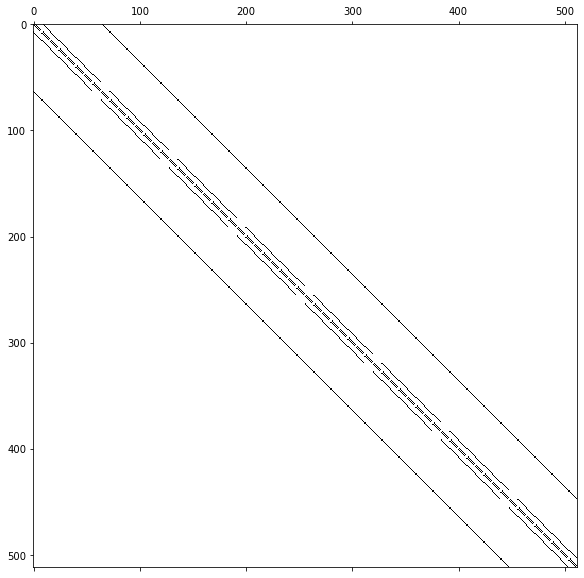

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	42568B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

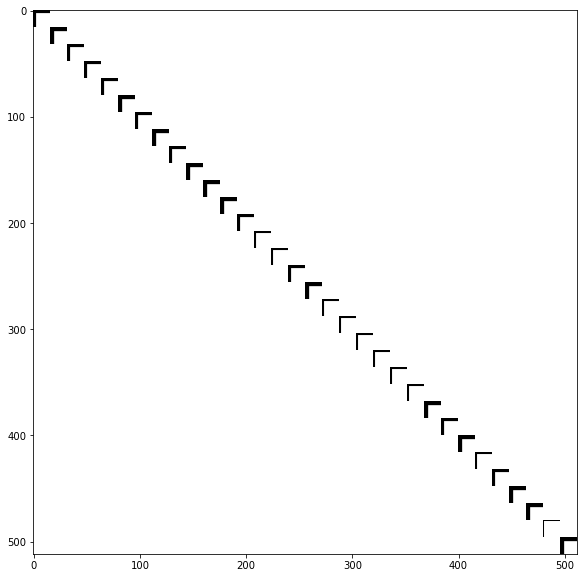

wzorzec gęstości macierzy po permutacji minimum_degree:


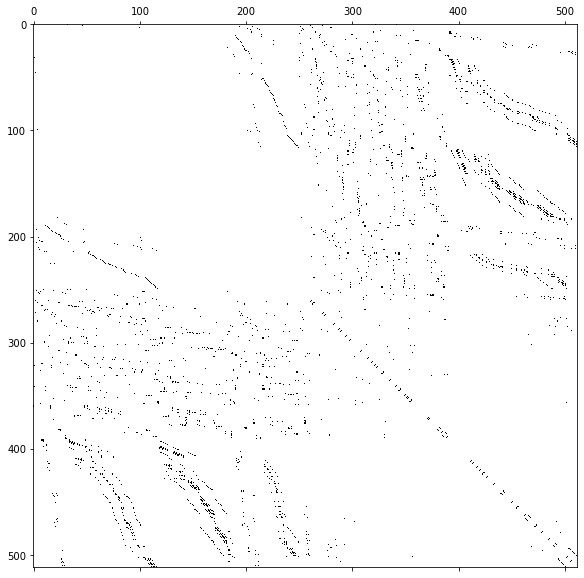

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	76224B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

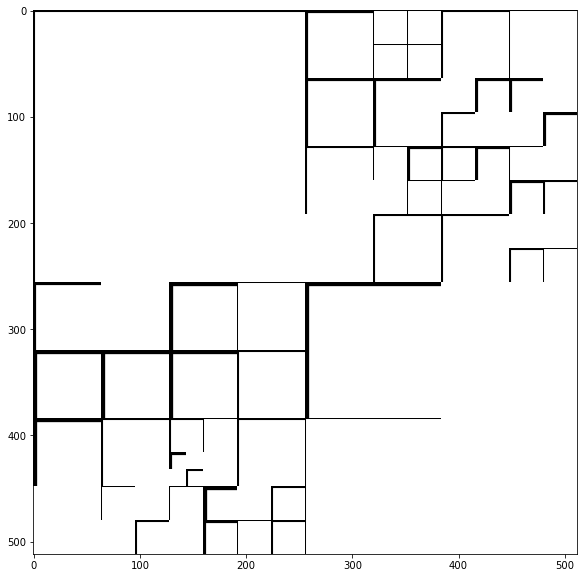

wzorzec gęstości macierzy po permutacji cuthill_mckee:


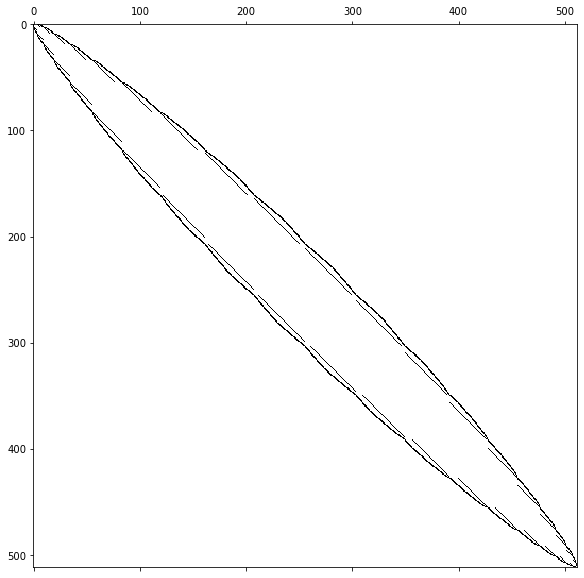

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	75264B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

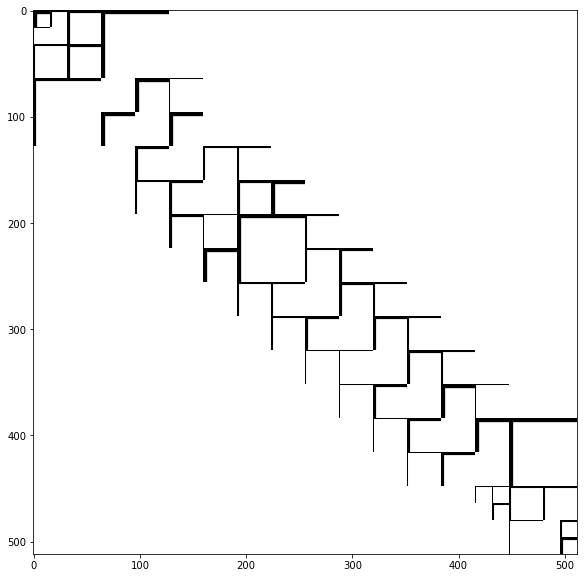

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


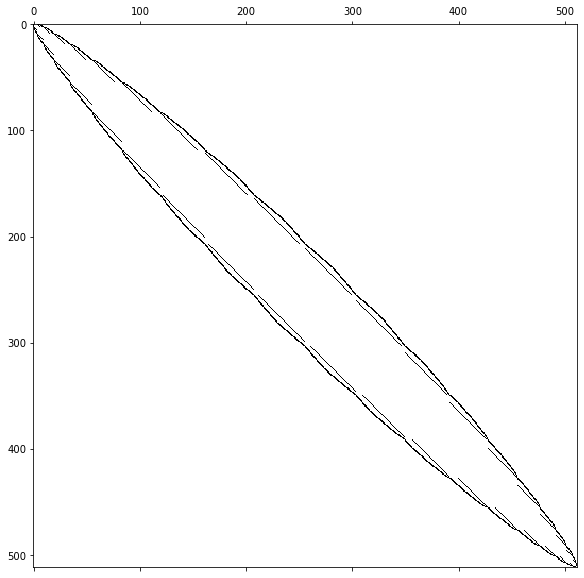

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	75264B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

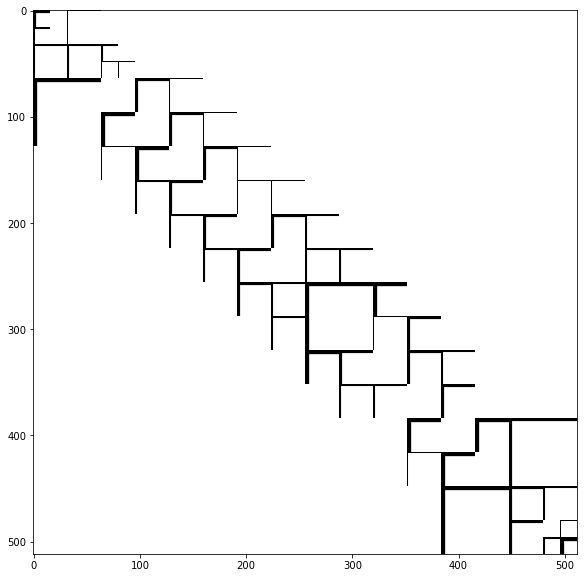

k =  4 

wzorzec gęstości macierzy przed kompresją:


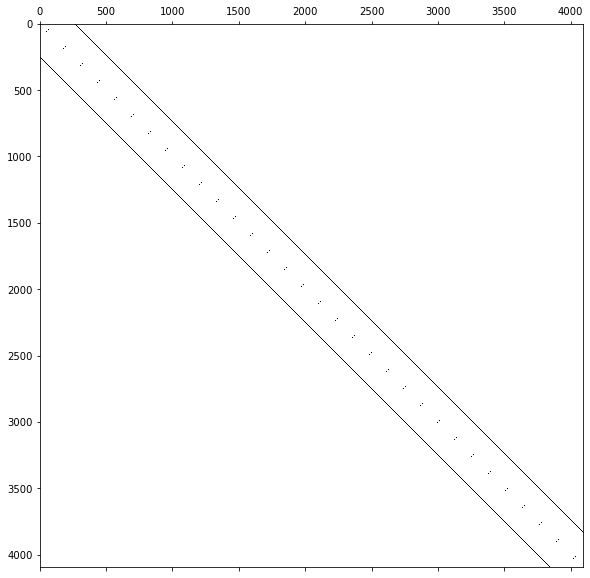

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	238576B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

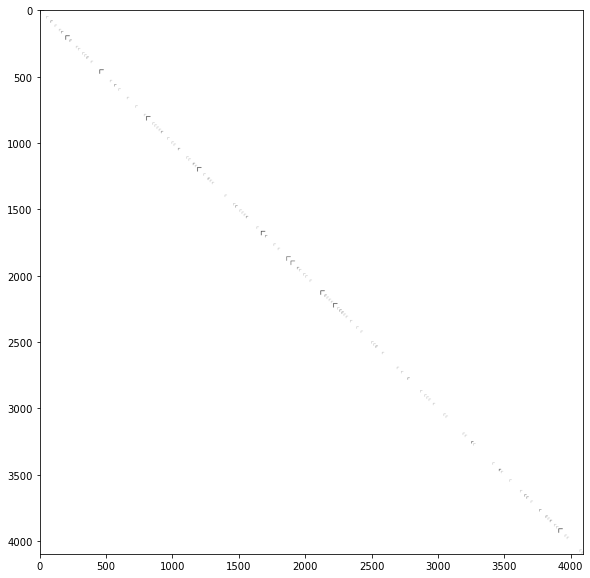

wzorzec gęstości macierzy po permutacji minimum_degree:


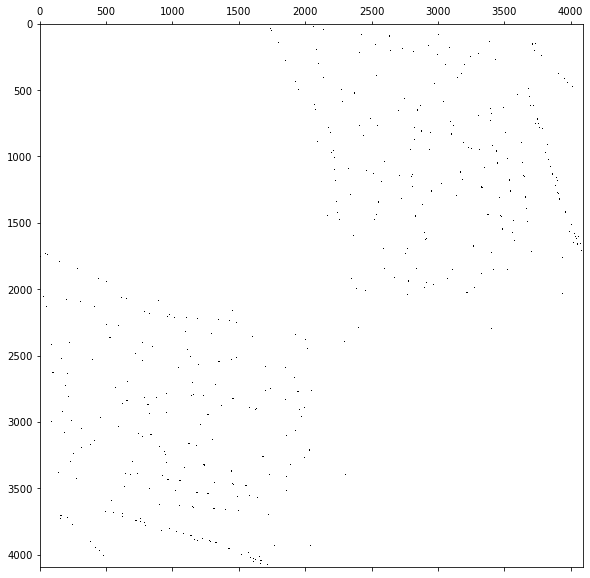

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	1113144B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

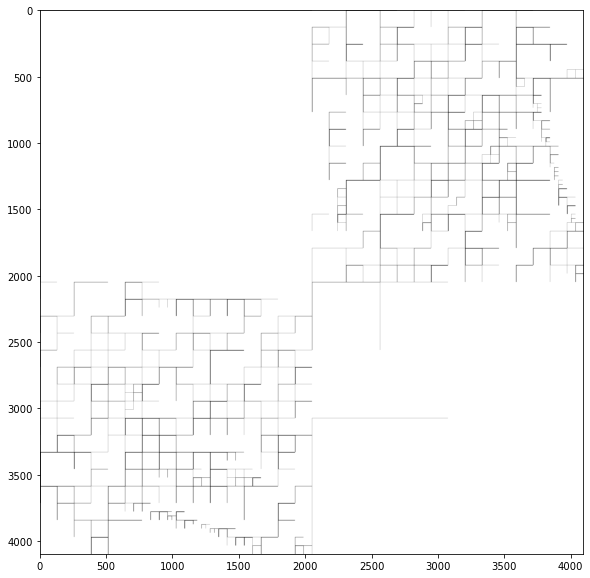

wzorzec gęstości macierzy po permutacji cuthill_mckee:


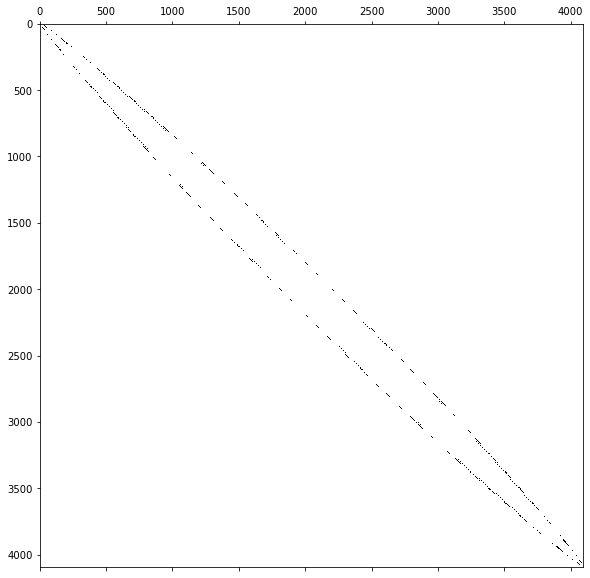

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	622264B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

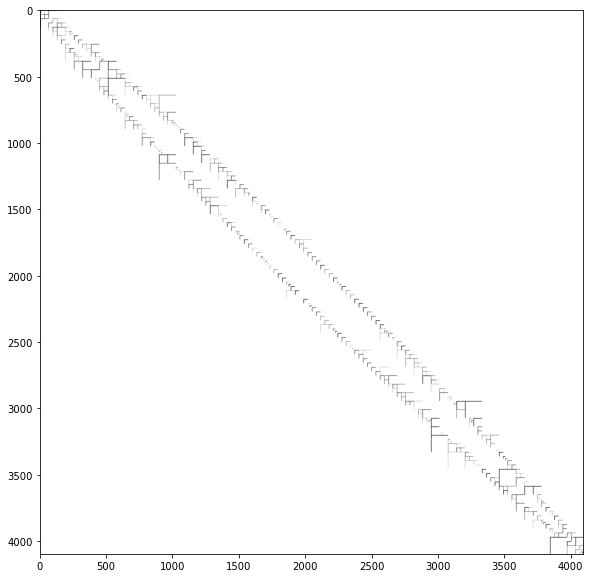

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


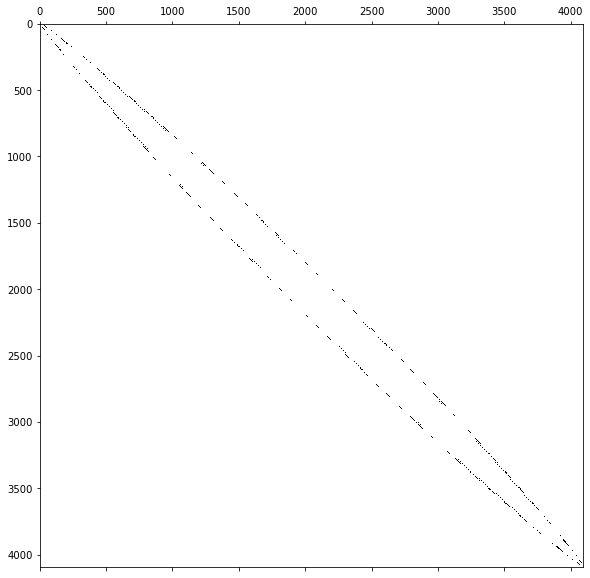

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	622264B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

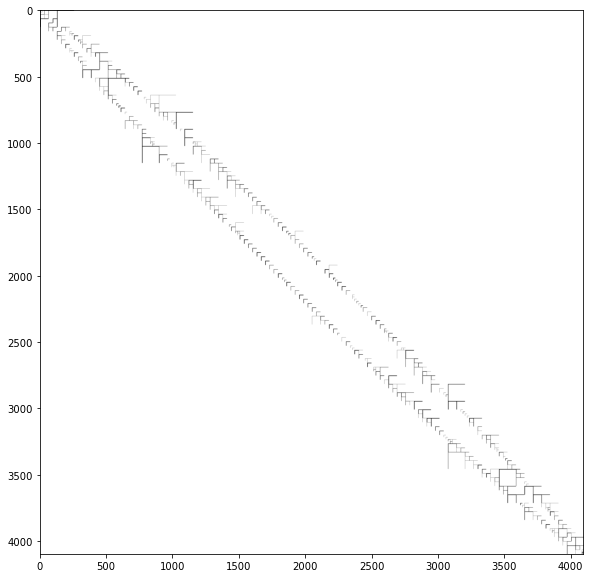

test for δ = size/3, b = 8
k =  2 

wzorzec gęstości macierzy przed kompresją:


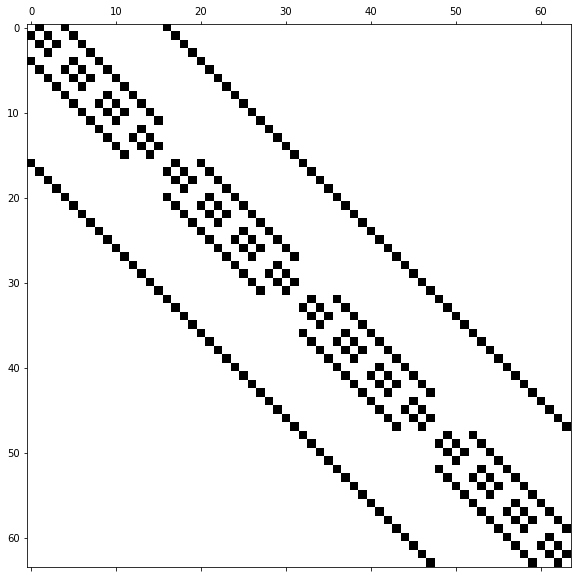

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	5320B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

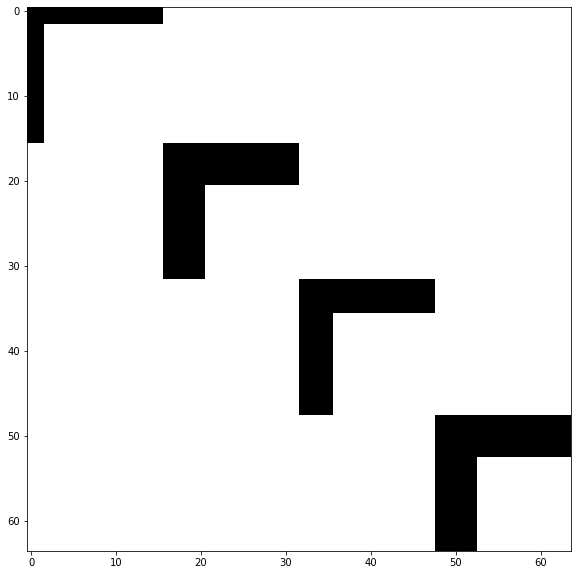

wzorzec gęstości macierzy po permutacji minimum_degree:


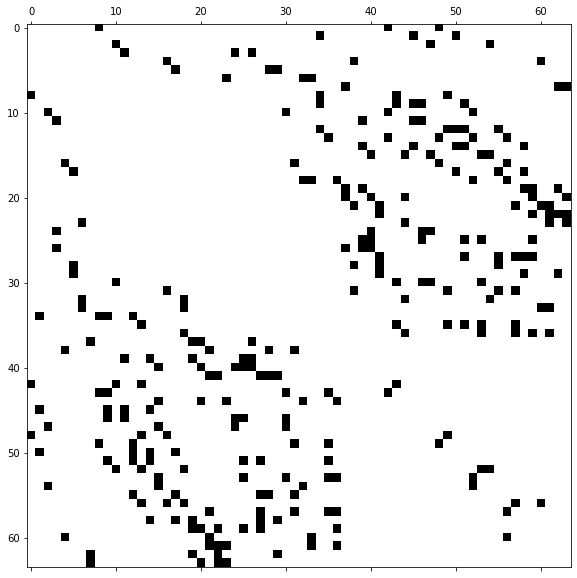

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	7608B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

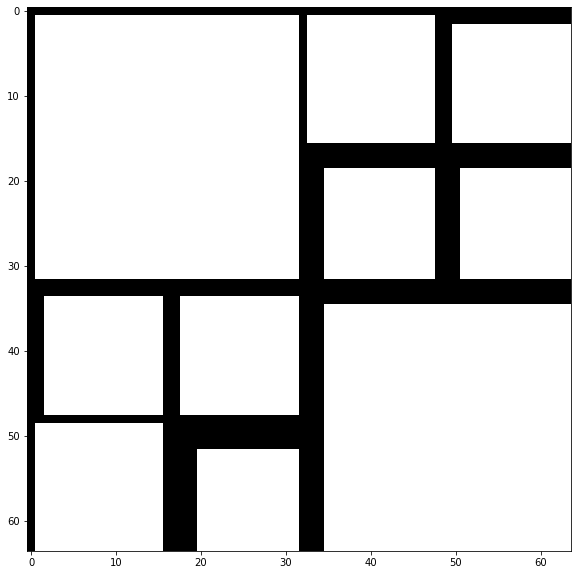

wzorzec gęstości macierzy po permutacji cuthill_mckee:


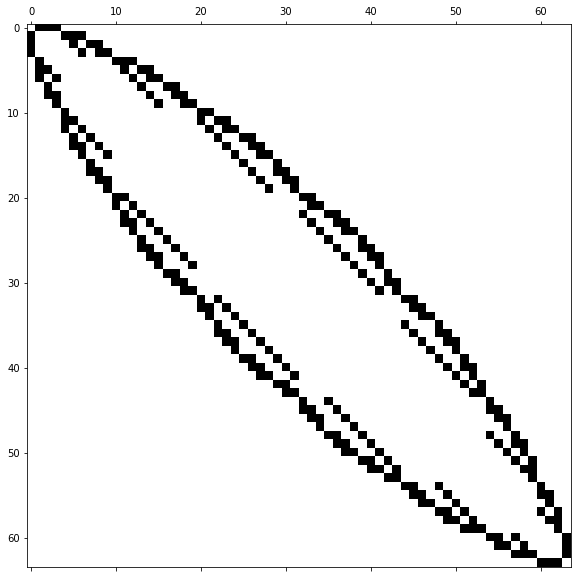

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	7976B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

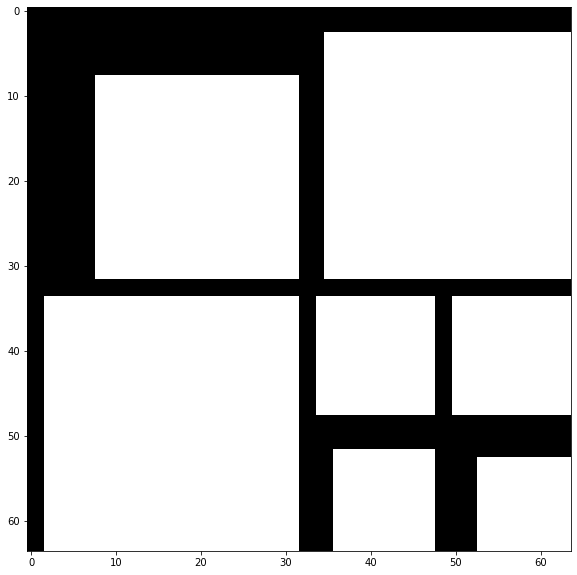

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


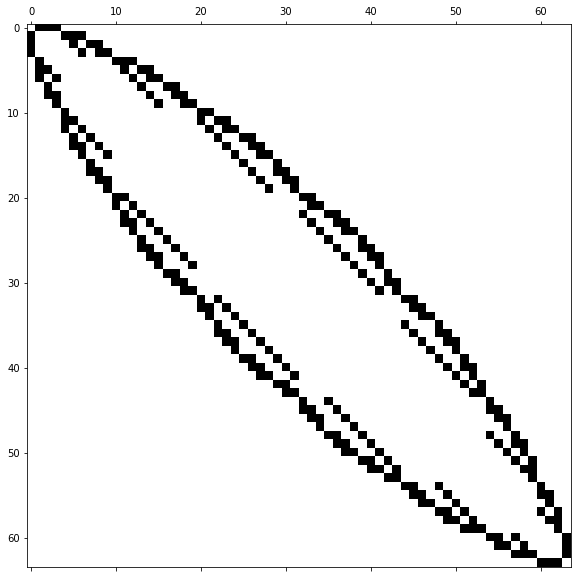

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	7976B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

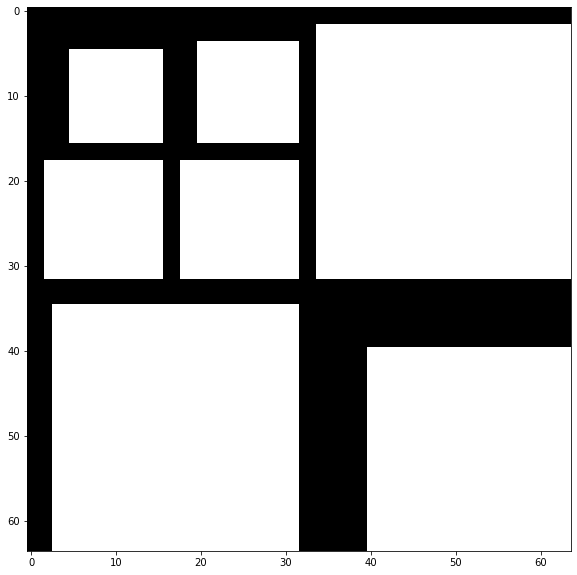

k =  3 

wzorzec gęstości macierzy przed kompresją:


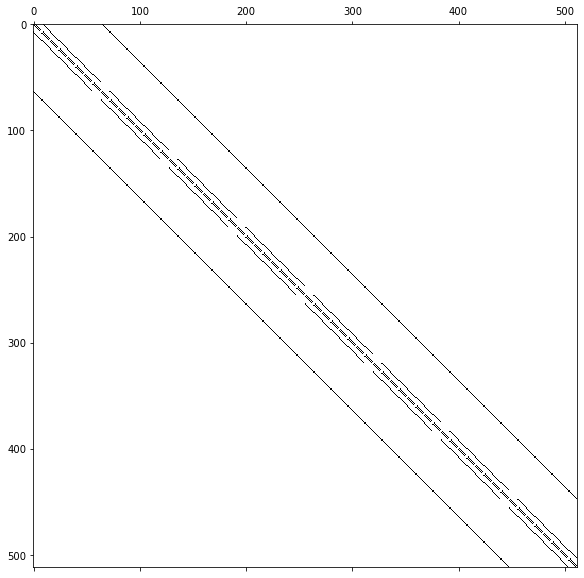

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	42504B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

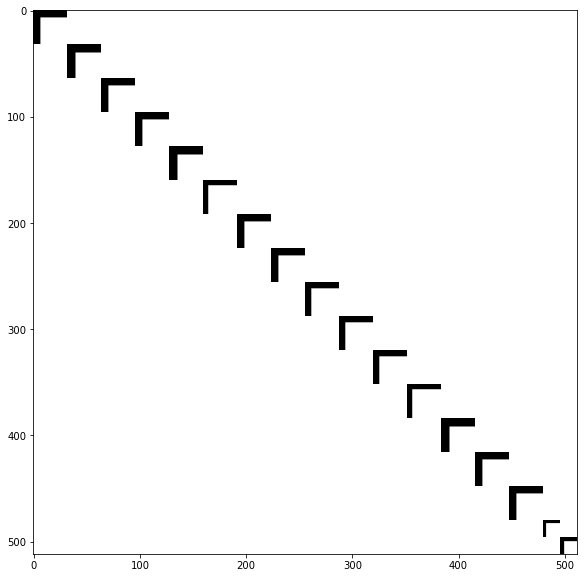

wzorzec gęstości macierzy po permutacji minimum_degree:


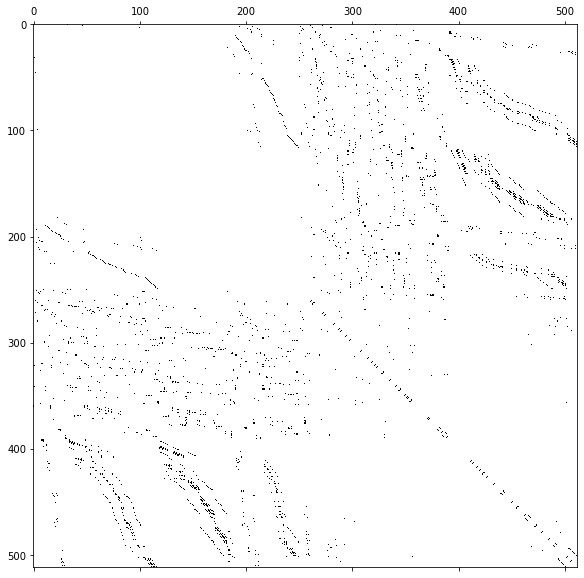

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	87016B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

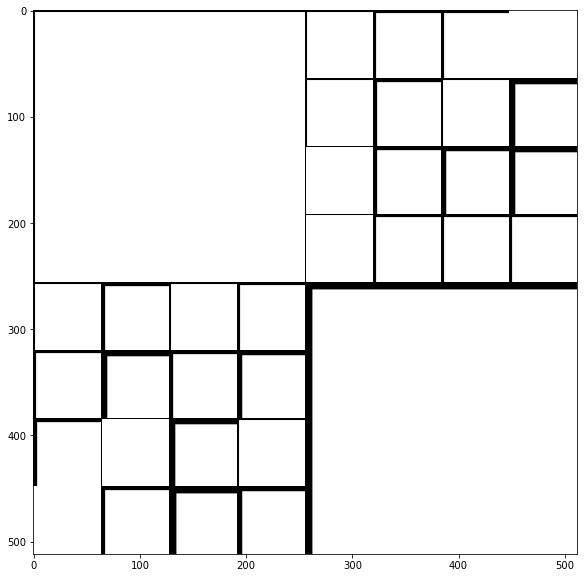

wzorzec gęstości macierzy po permutacji cuthill_mckee:


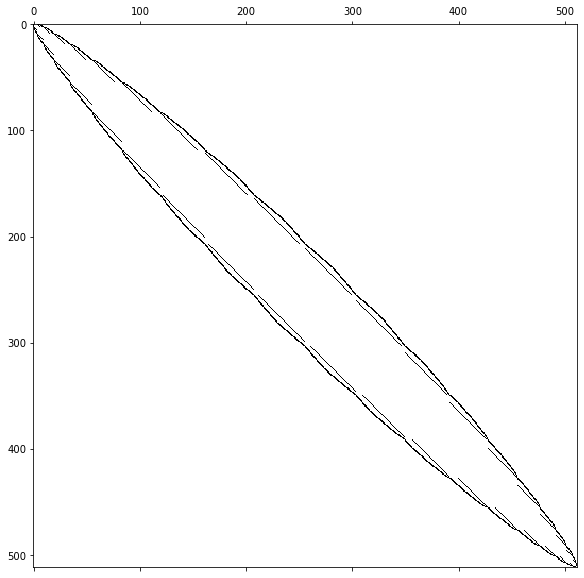

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	107544B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

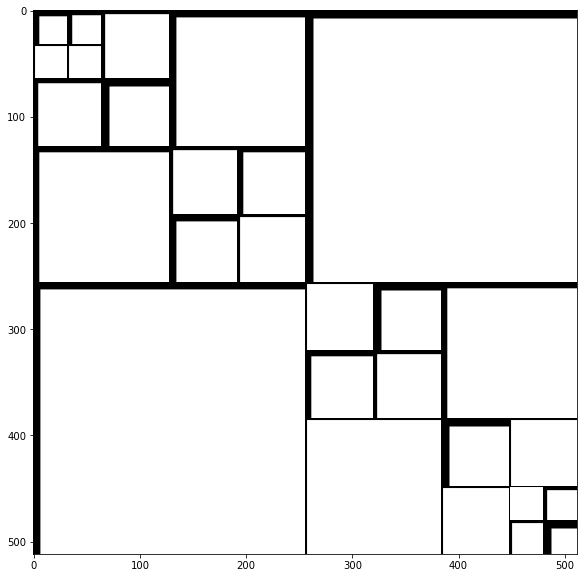

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


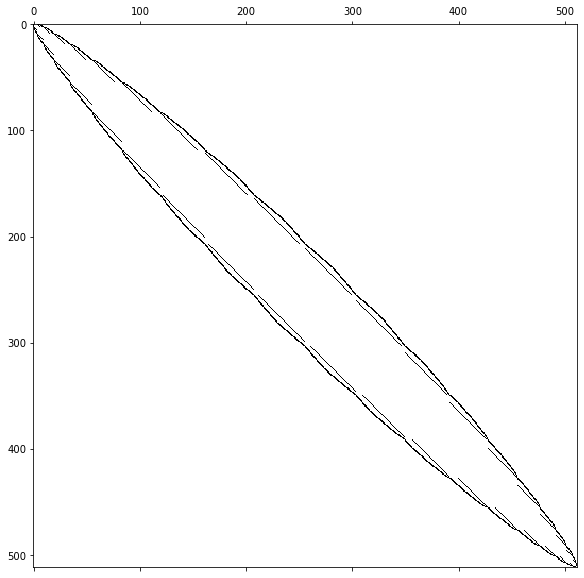

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	107544B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

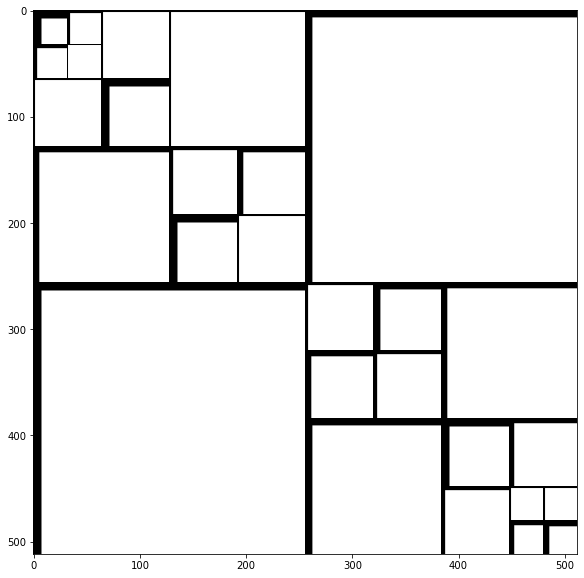

k =  4 

wzorzec gęstości macierzy przed kompresją:


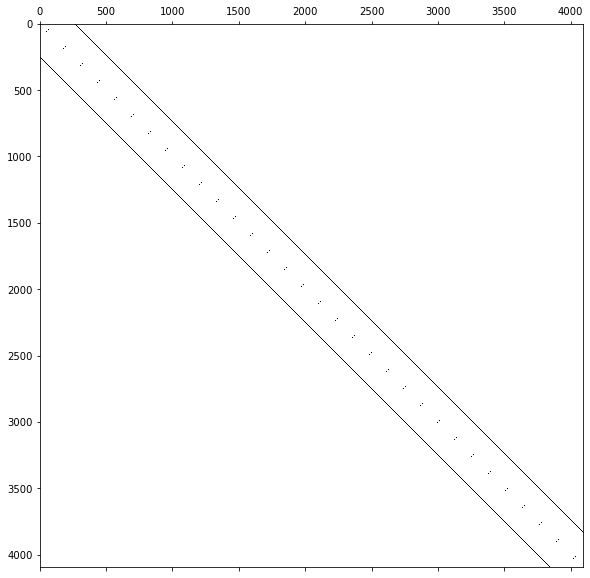

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	313408B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

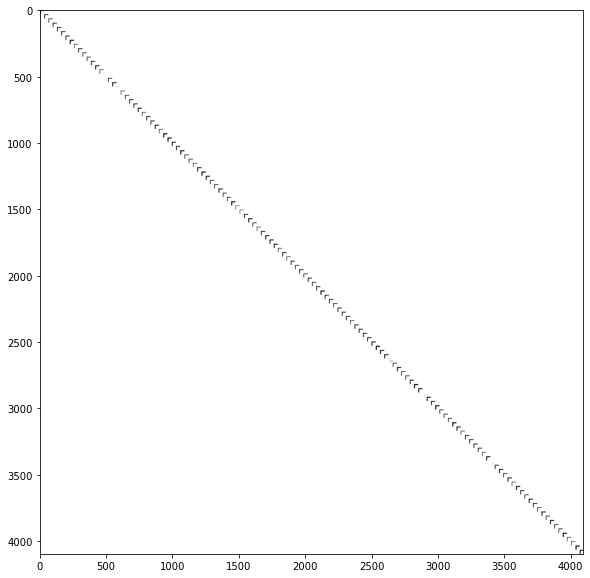

wzorzec gęstości macierzy po permutacji minimum_degree:


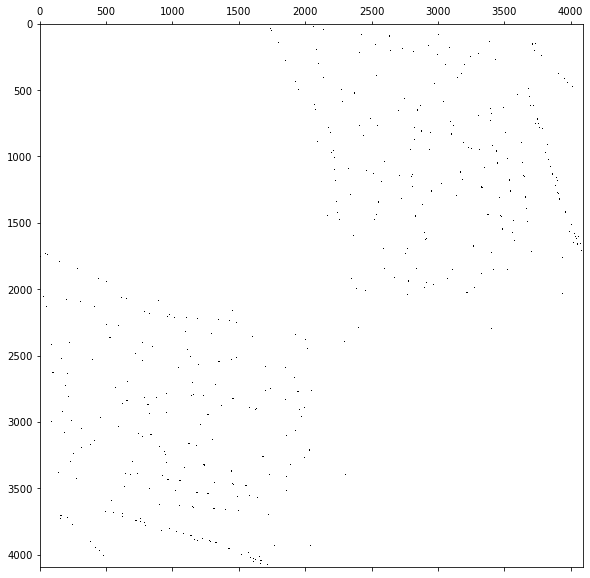

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	1540032B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

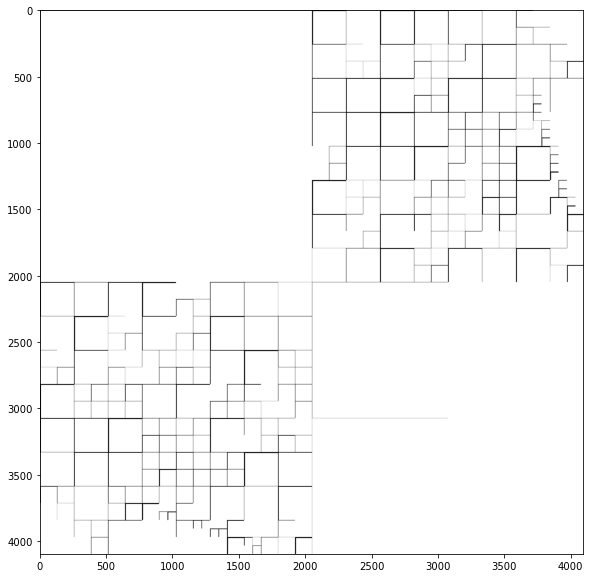

wzorzec gęstości macierzy po permutacji cuthill_mckee:


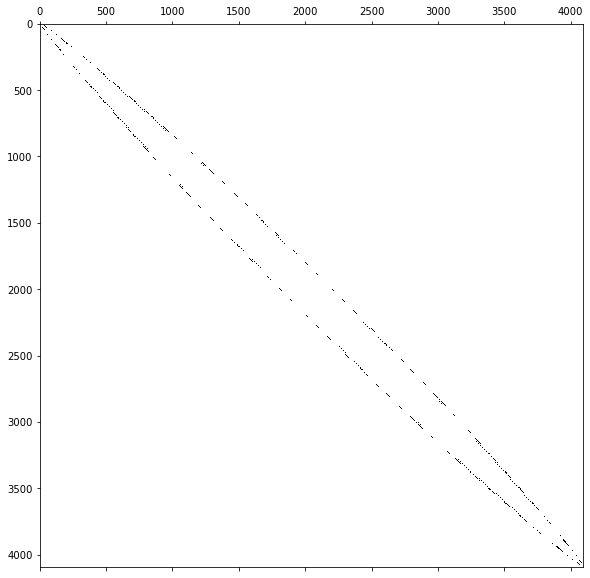

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	760080B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

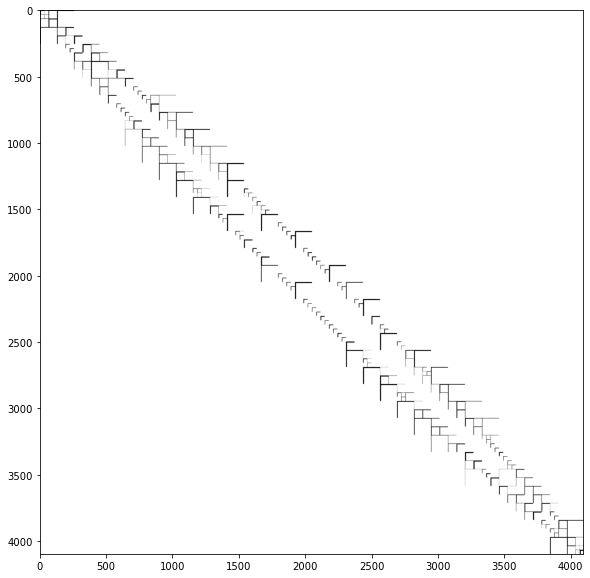

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


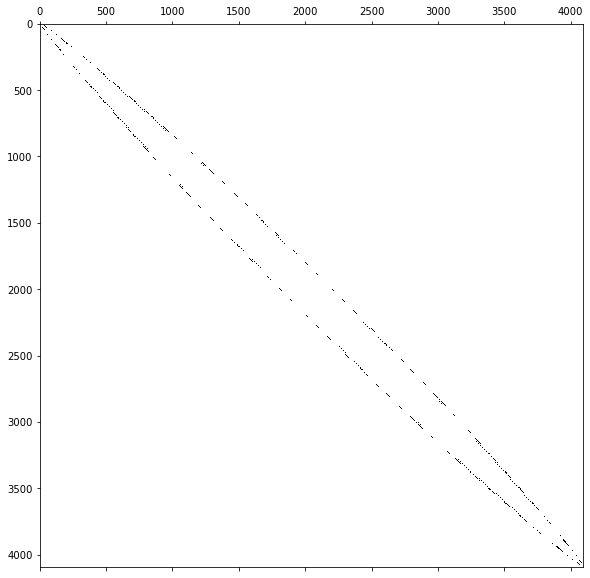

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	760080B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

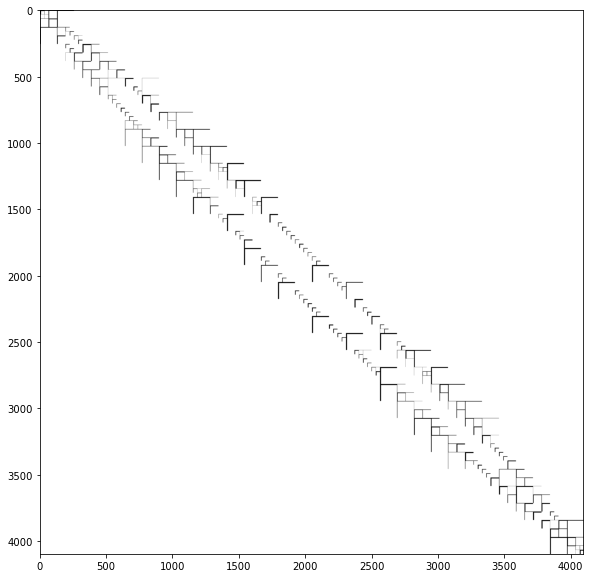

test for δ = size/4, b = 2
k =  2 

wzorzec gęstości macierzy przed kompresją:


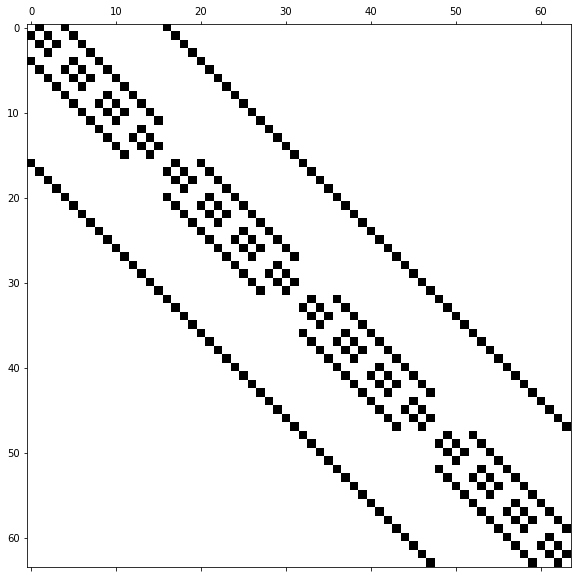

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	5256B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

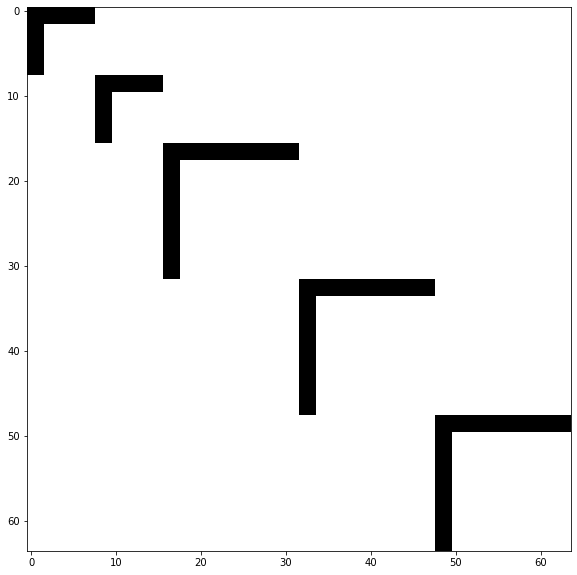

wzorzec gęstości macierzy po permutacji minimum_degree:


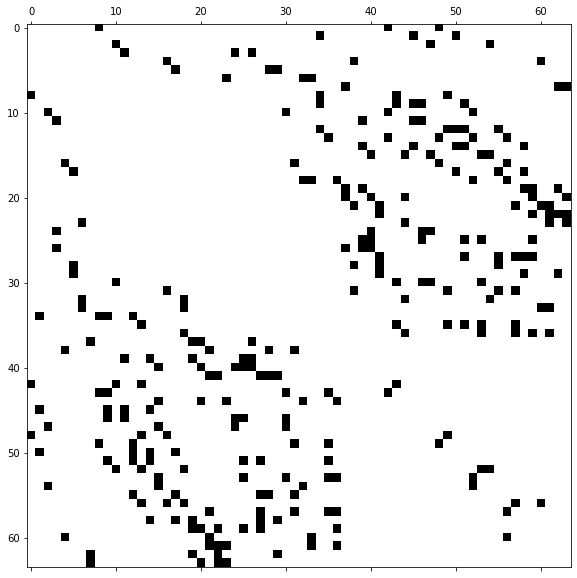

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	4464B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

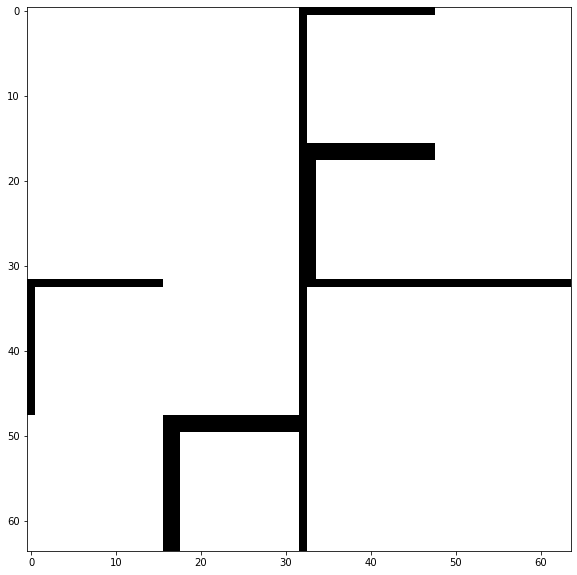

wzorzec gęstości macierzy po permutacji cuthill_mckee:


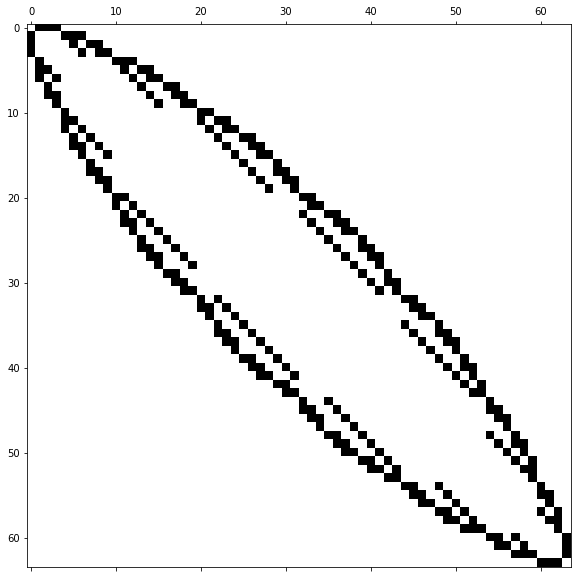

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	4336B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

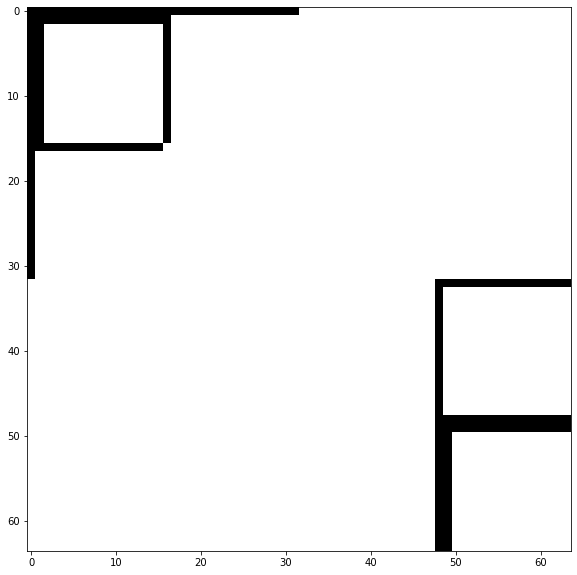

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


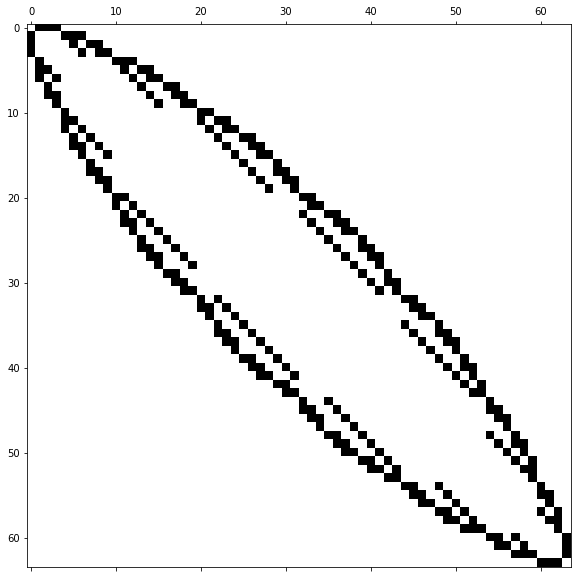

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	4336B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

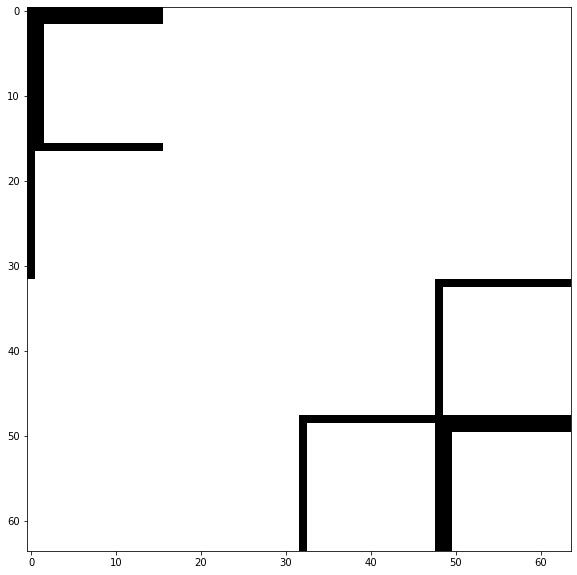

k =  3 

wzorzec gęstości macierzy przed kompresją:


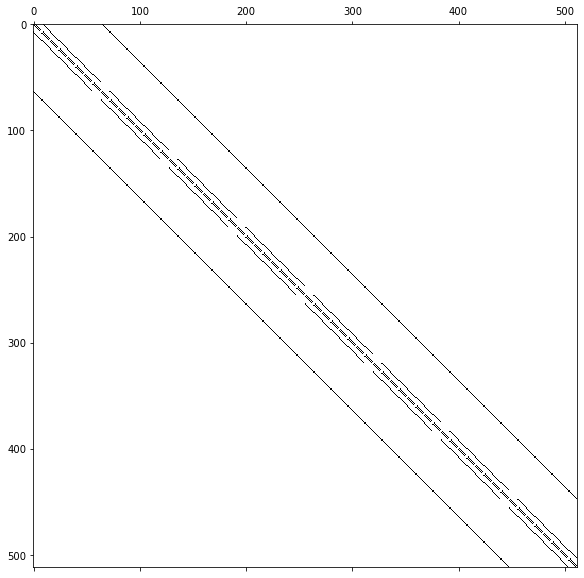

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	36384B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

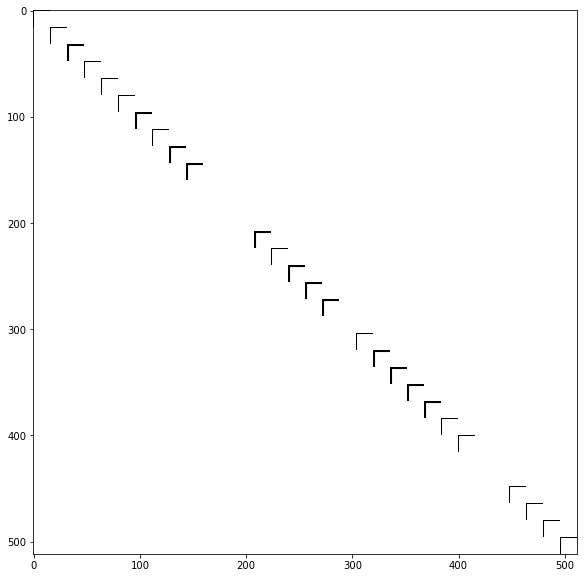

wzorzec gęstości macierzy po permutacji minimum_degree:


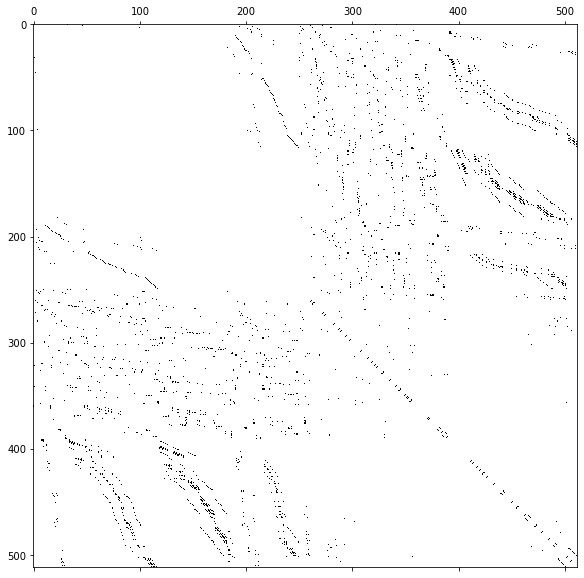

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	41096B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

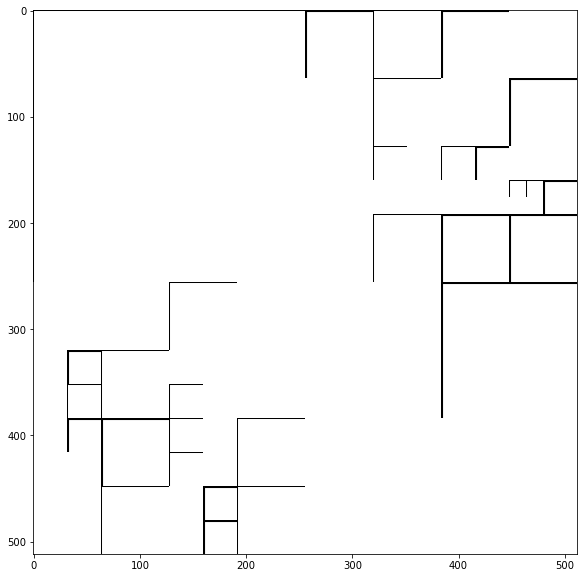

wzorzec gęstości macierzy po permutacji cuthill_mckee:


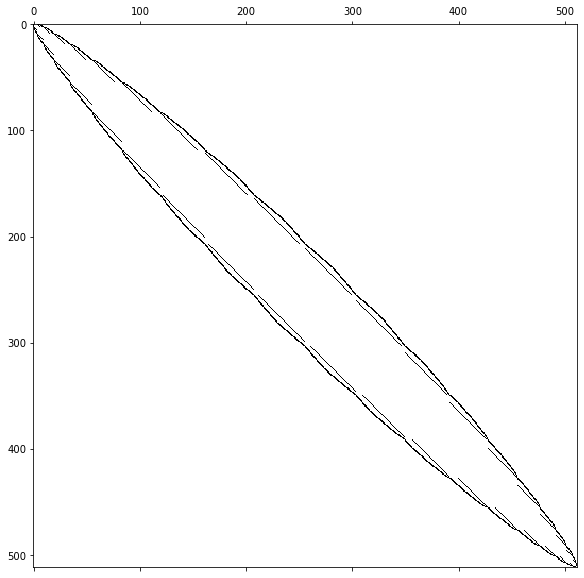

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	49632B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

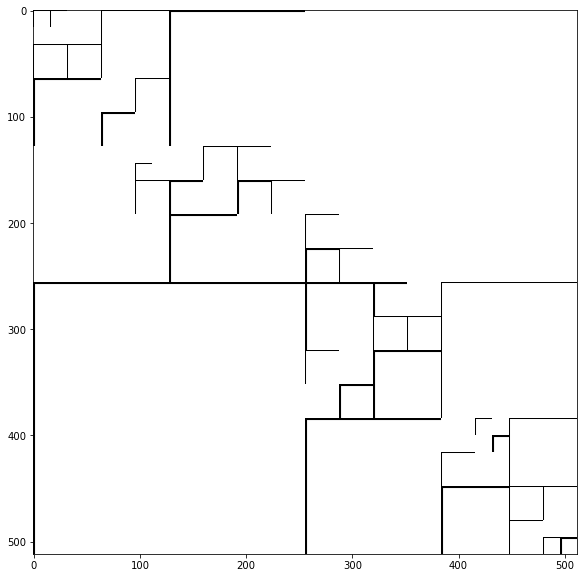

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


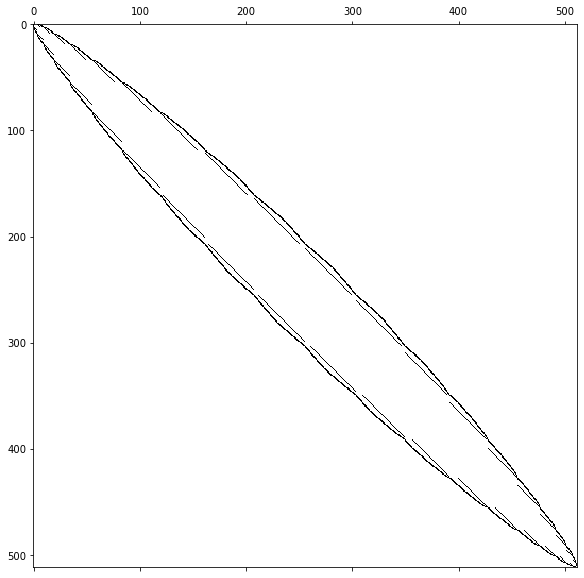

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	49632B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

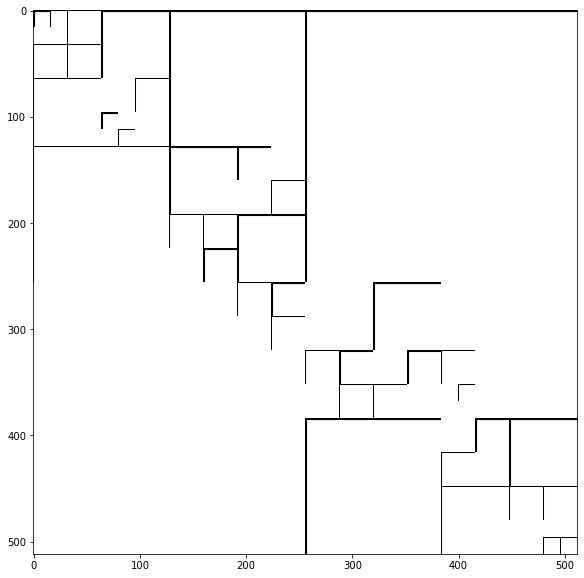

k =  4 

wzorzec gęstości macierzy przed kompresją:


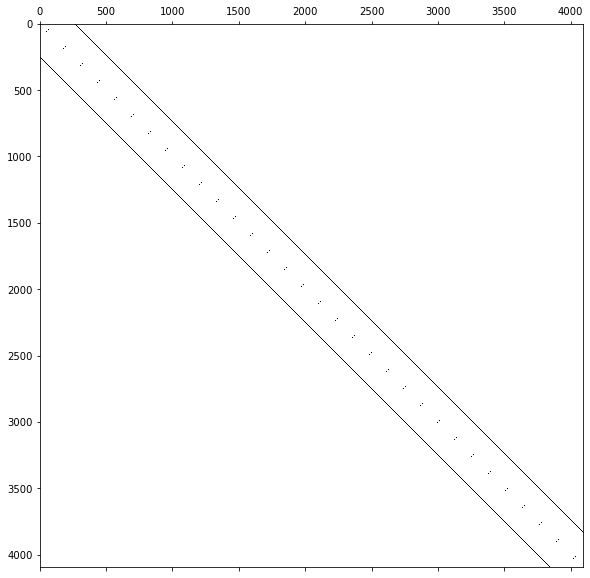

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	192232B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

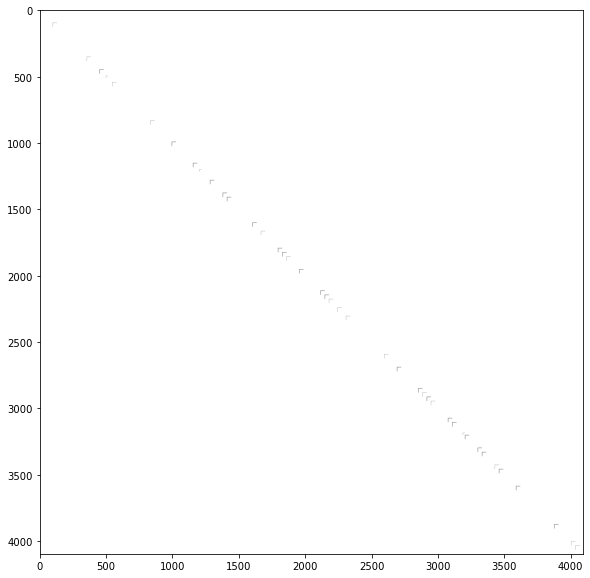

wzorzec gęstości macierzy po permutacji minimum_degree:


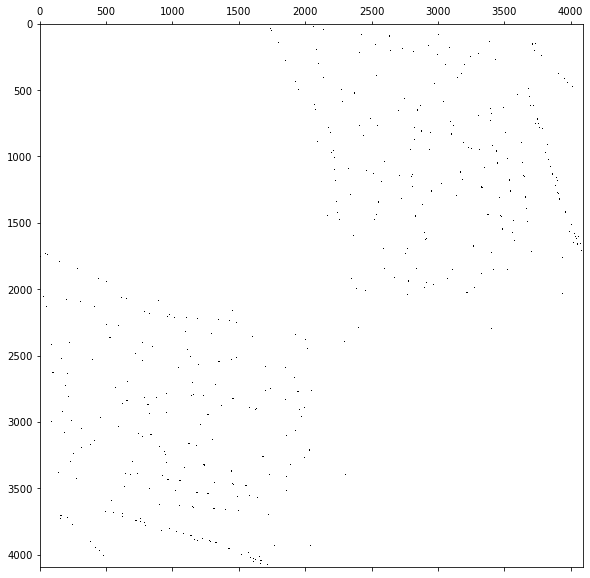

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	562304B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

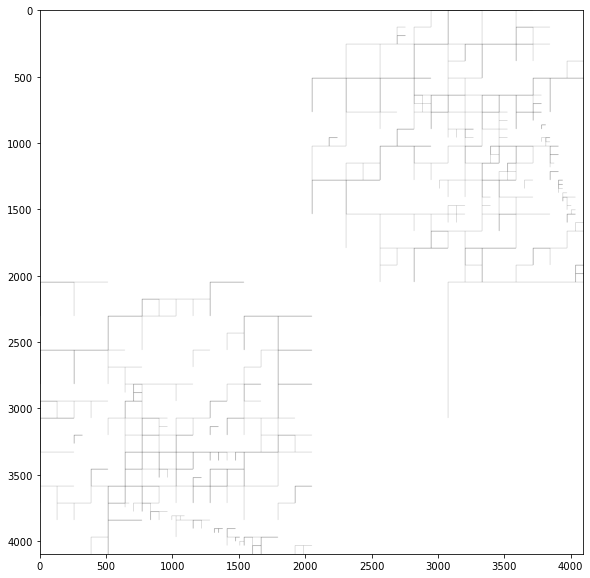

wzorzec gęstości macierzy po permutacji cuthill_mckee:


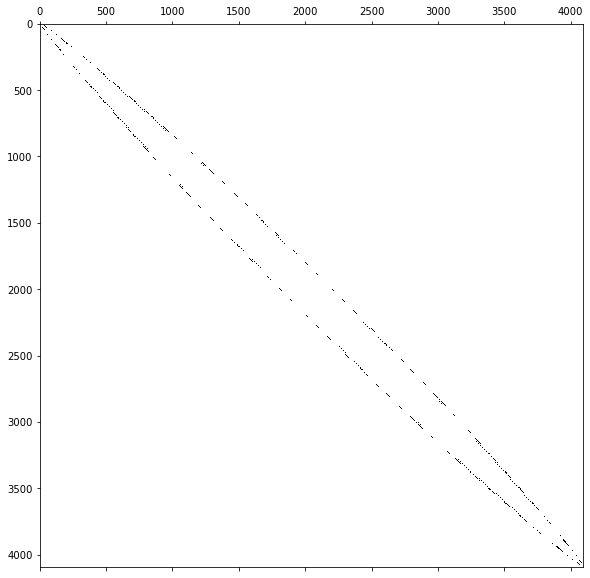

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	350096B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

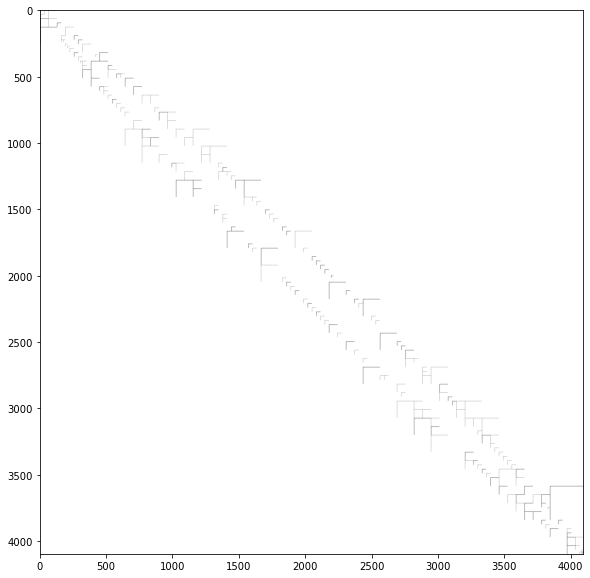

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


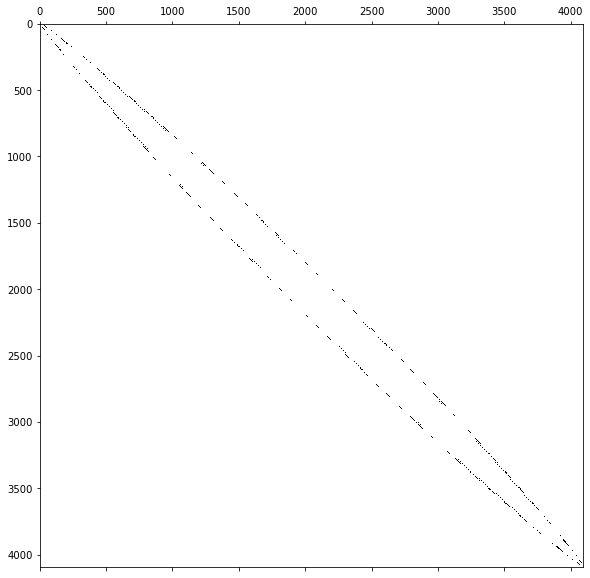

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	350096B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

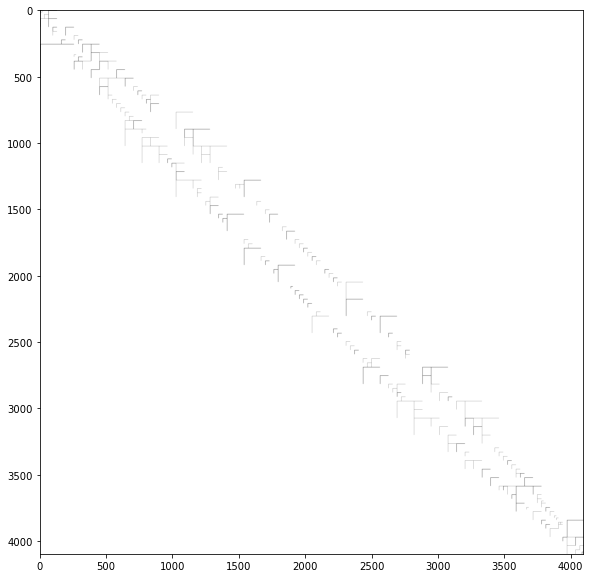

test for δ = size/4, b = 4
k =  2 

wzorzec gęstości macierzy przed kompresją:


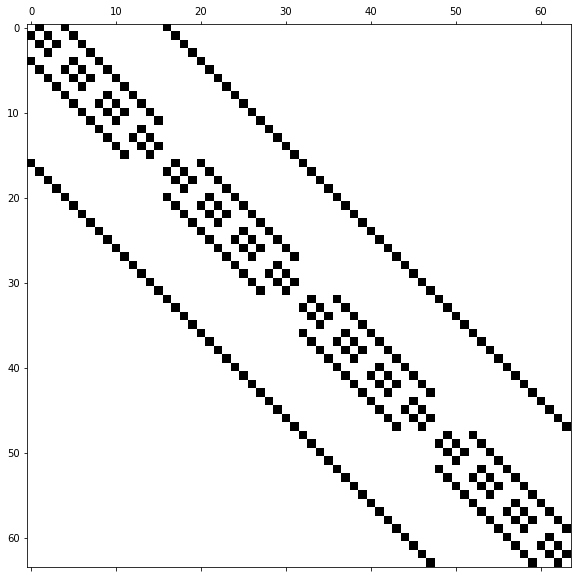

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	4680B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

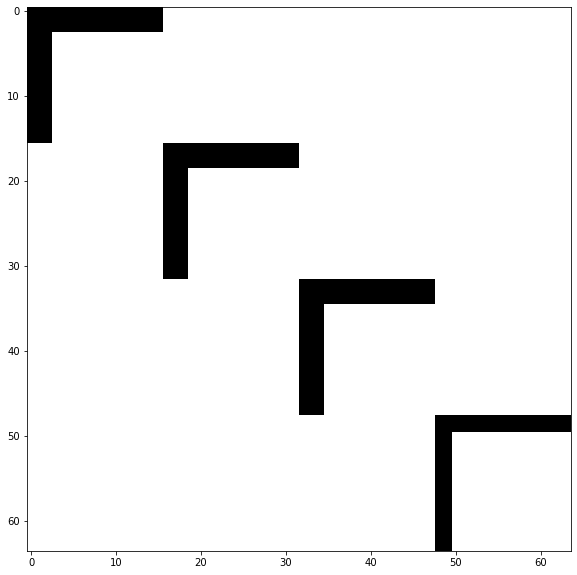

wzorzec gęstości macierzy po permutacji minimum_degree:


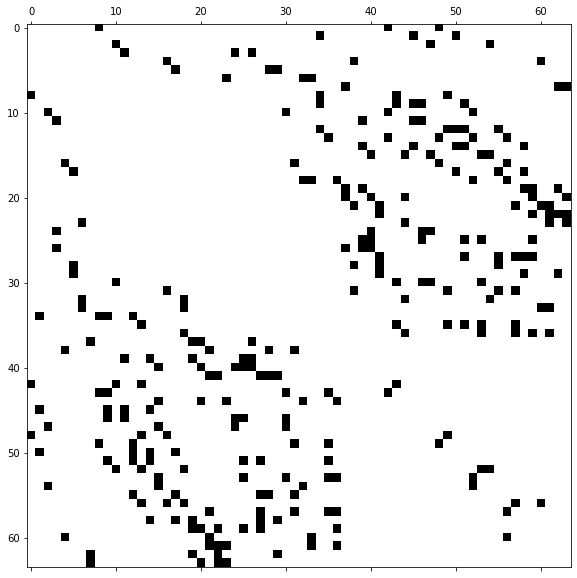

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	5312B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

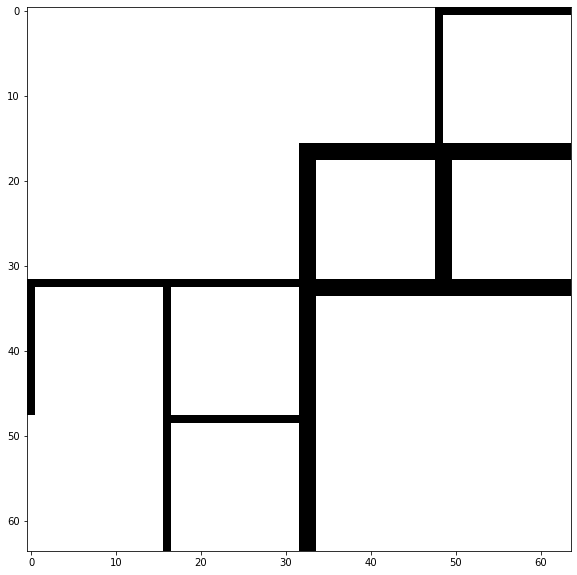

wzorzec gęstości macierzy po permutacji cuthill_mckee:


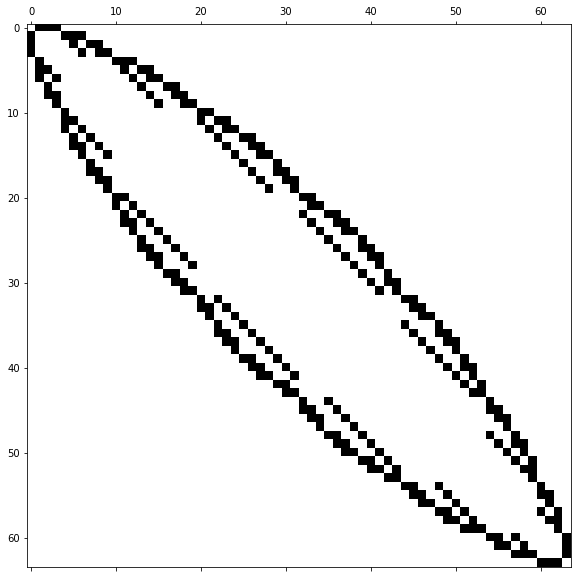

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	6208B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

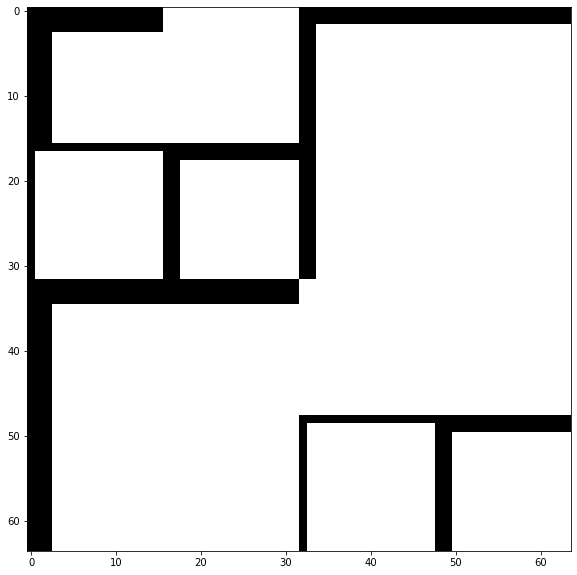

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


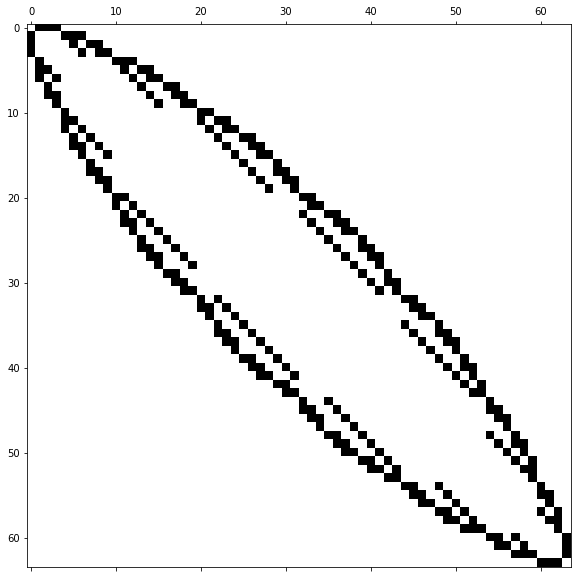

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	6208B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

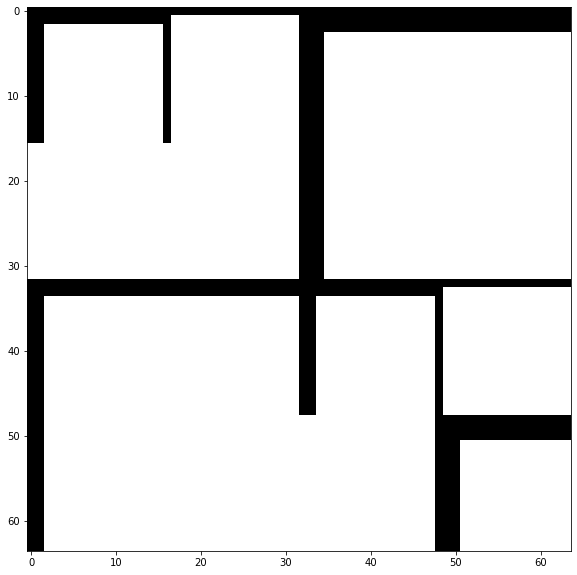

k =  3 

wzorzec gęstości macierzy przed kompresją:


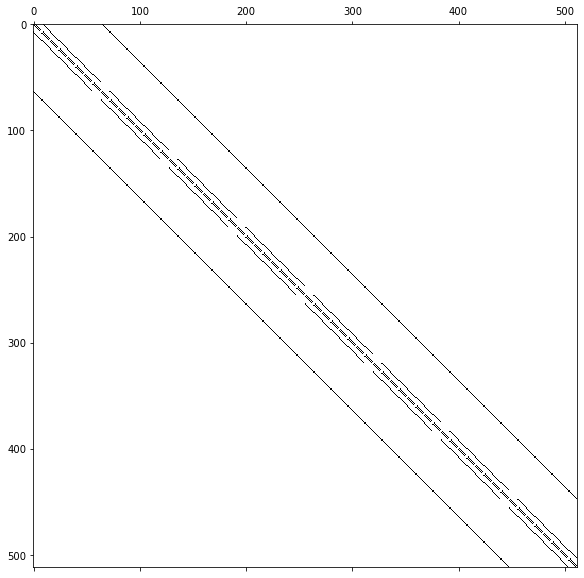

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	33120B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

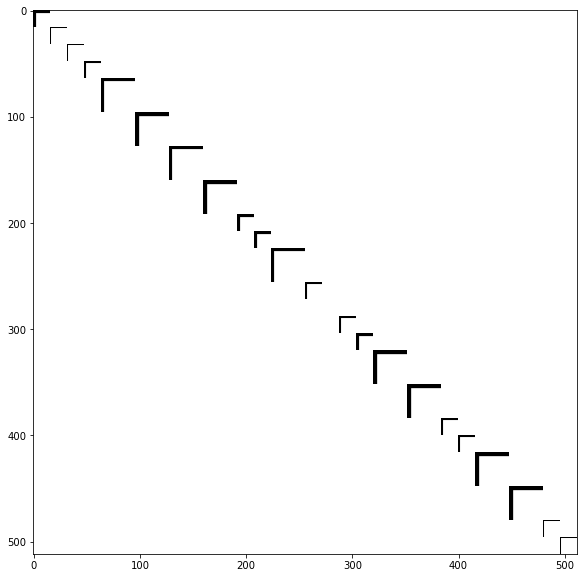

wzorzec gęstości macierzy po permutacji minimum_degree:


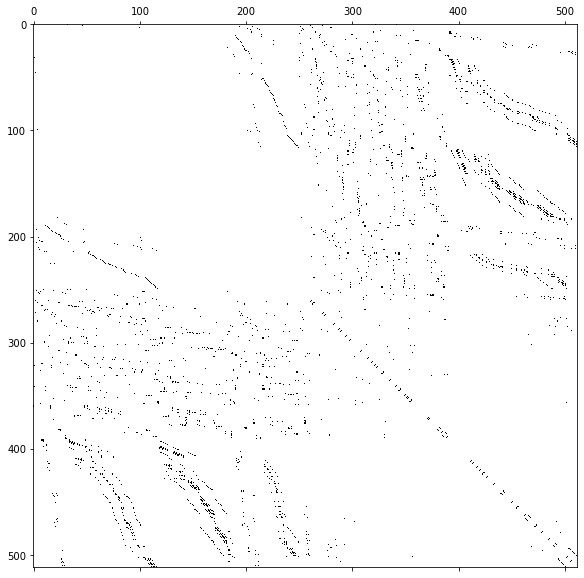

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	42328B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

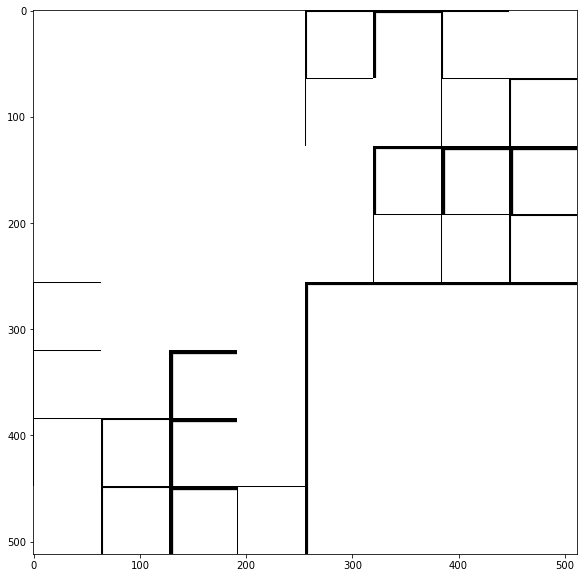

wzorzec gęstości macierzy po permutacji cuthill_mckee:


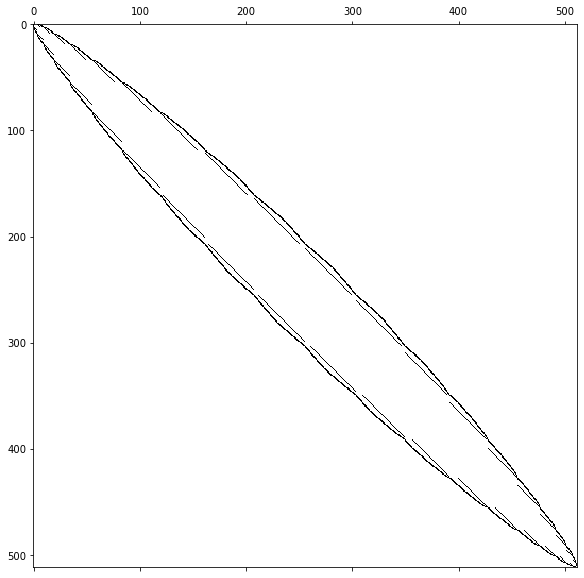

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	55760B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

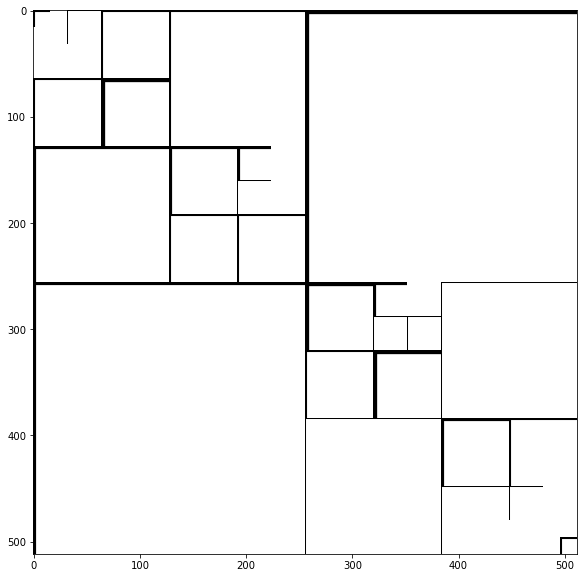

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


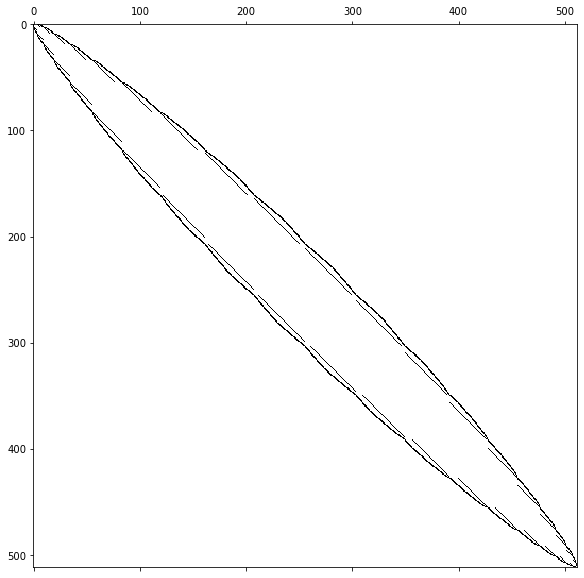

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	55760B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

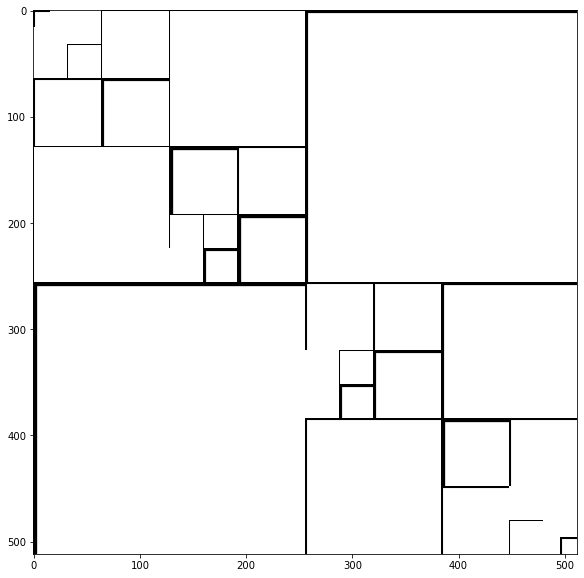

k =  4 

wzorzec gęstości macierzy przed kompresją:


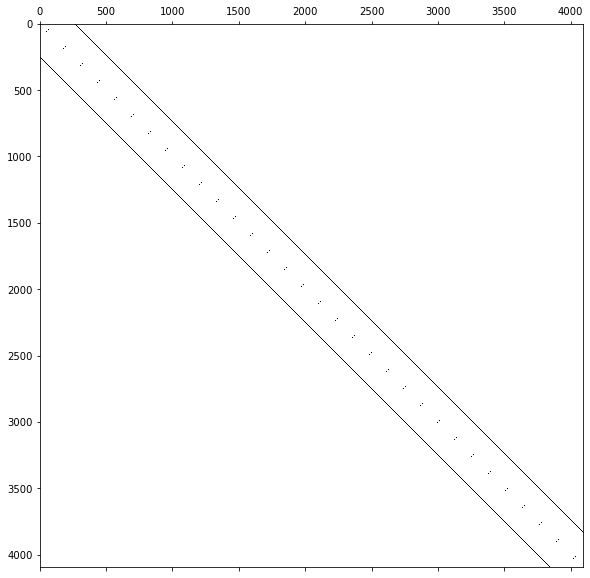

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	202960B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

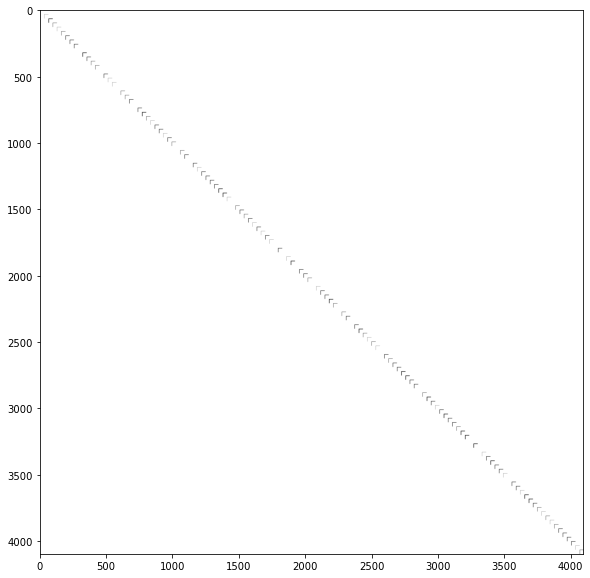

wzorzec gęstości macierzy po permutacji minimum_degree:


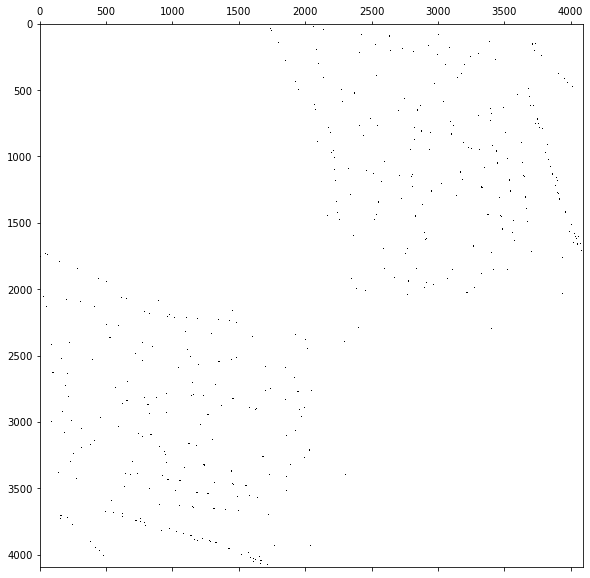

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	687816B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

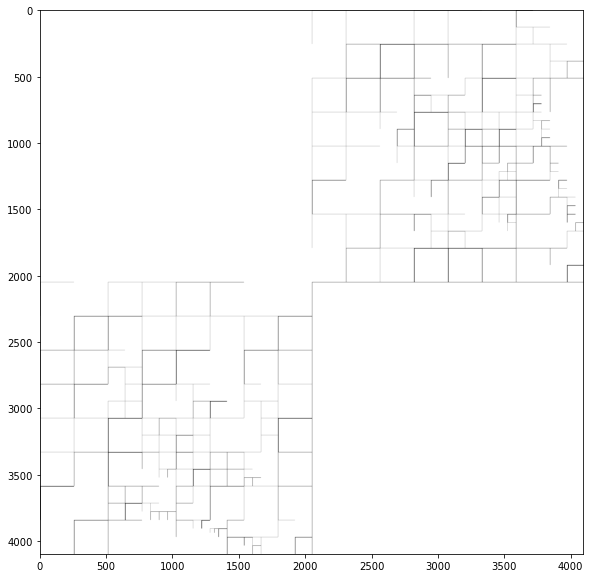

wzorzec gęstości macierzy po permutacji cuthill_mckee:


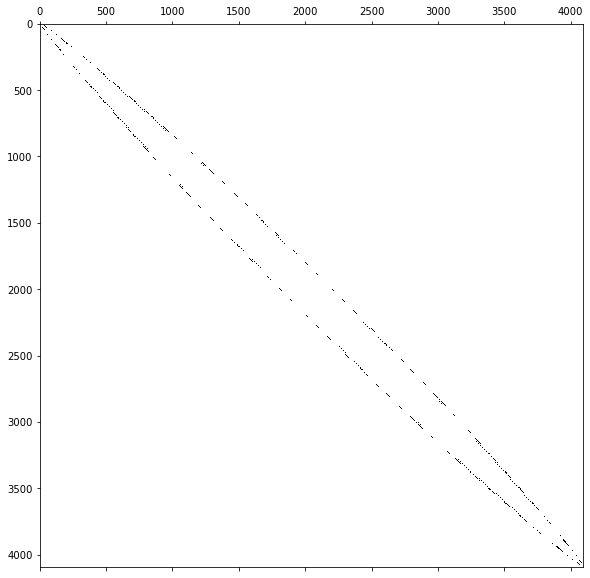

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	422096B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

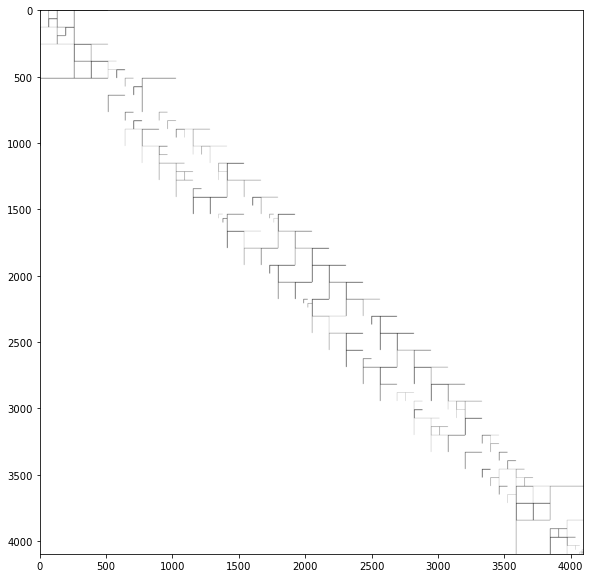

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


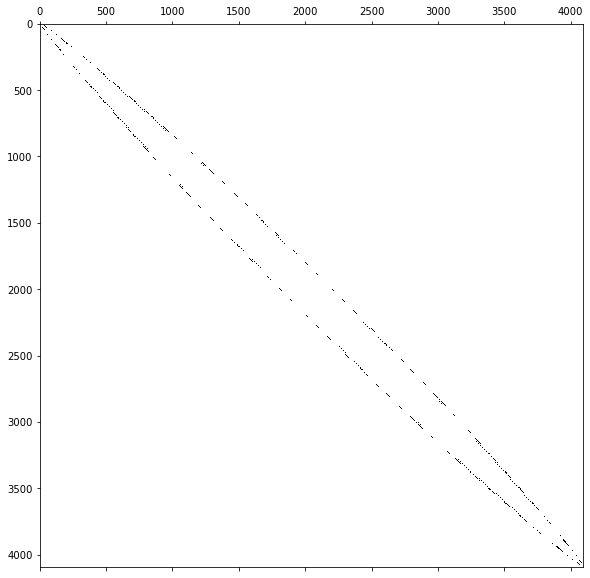

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	422096B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

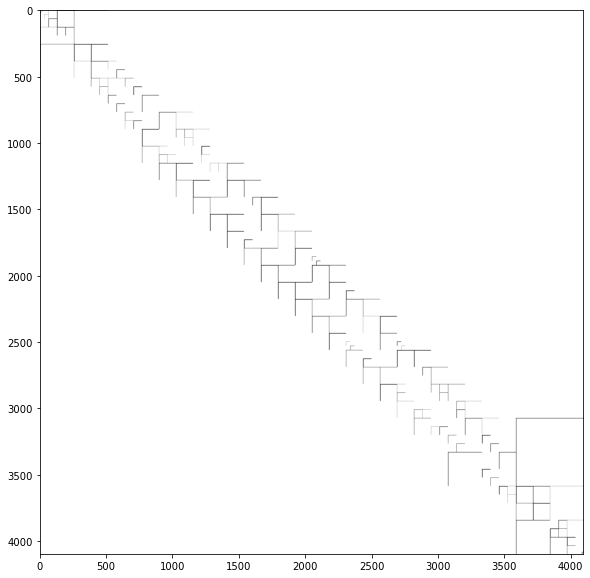

test for δ = size/4, b = 8
k =  2 

wzorzec gęstości macierzy przed kompresją:


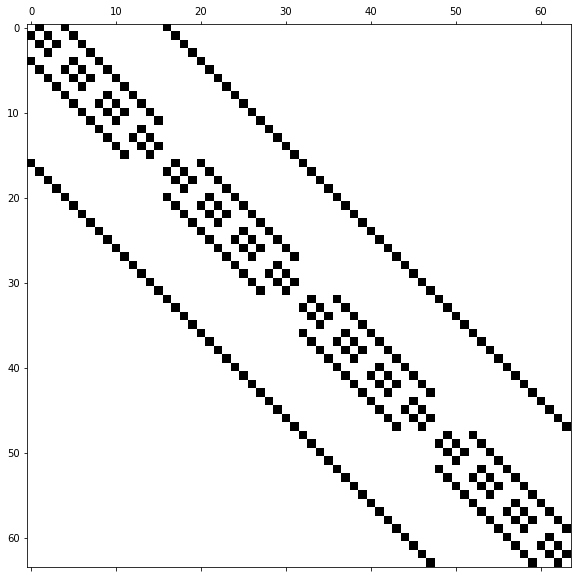

Rozmiar oryginalny:	32768B
Rozmiar macierzy rzadkiej:	3716B
Rozmiar macierzy hierarchicznej bez permutacji:	4936B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

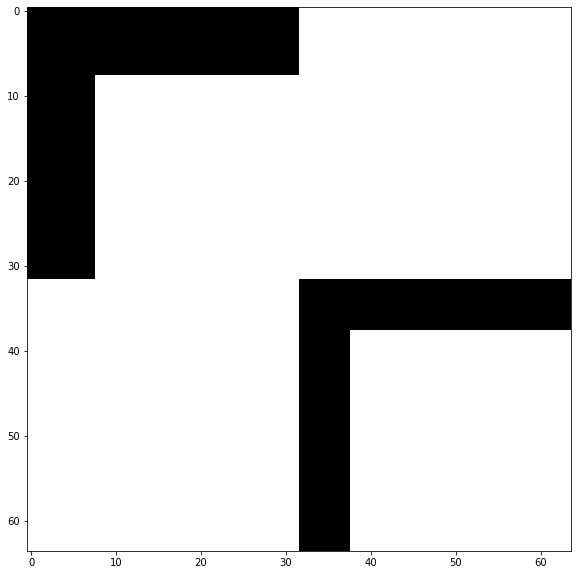

wzorzec gęstości macierzy po permutacji minimum_degree:


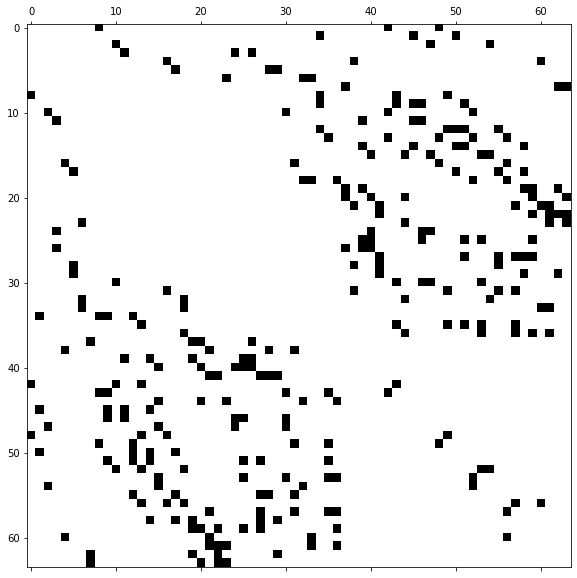

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	5360B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

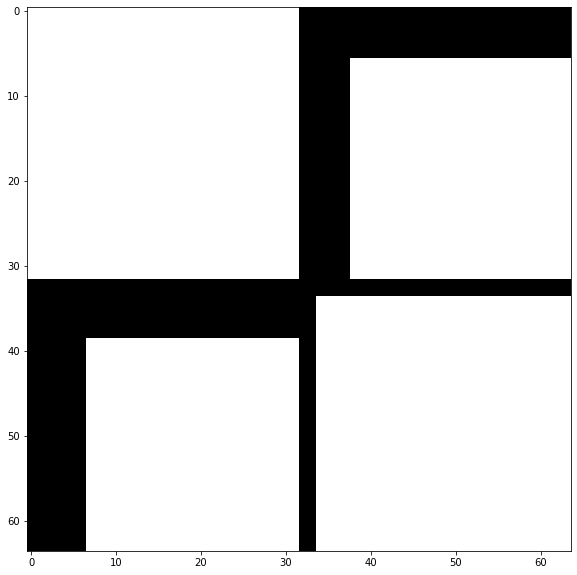

wzorzec gęstości macierzy po permutacji cuthill_mckee:


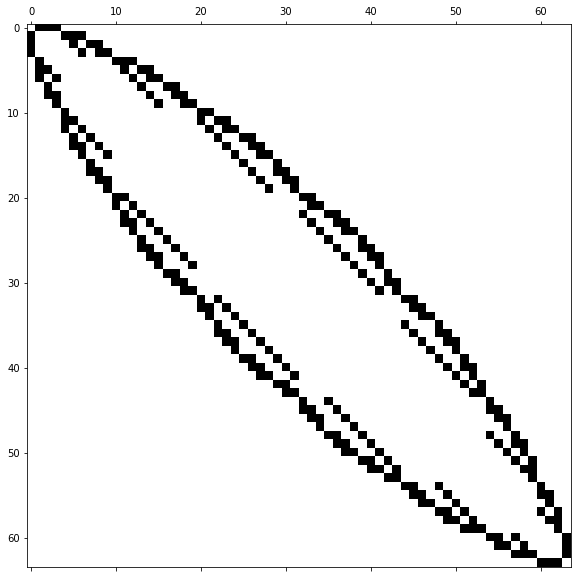

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	5016B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

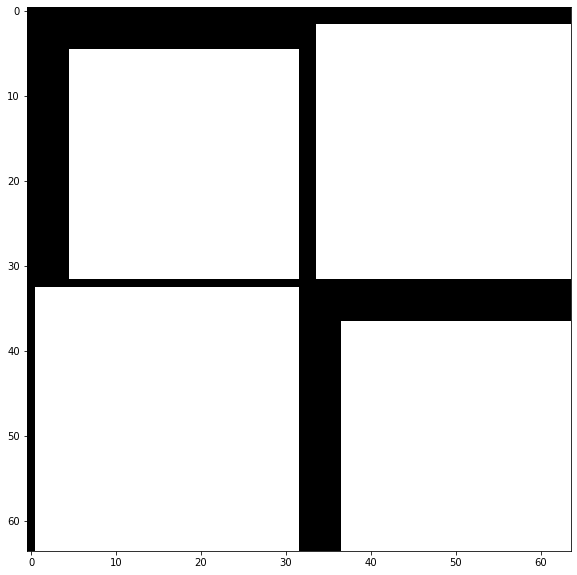

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


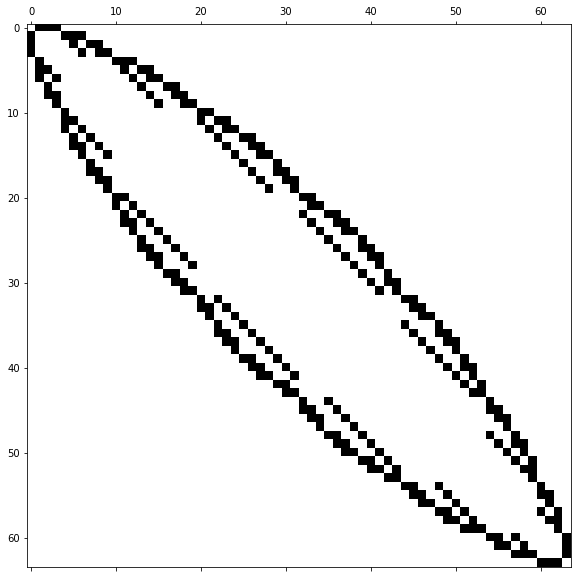

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	5016B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

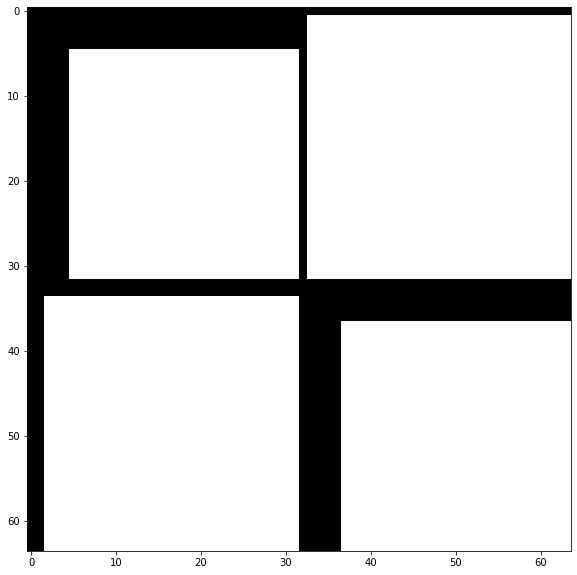

k =  3 

wzorzec gęstości macierzy przed kompresją:


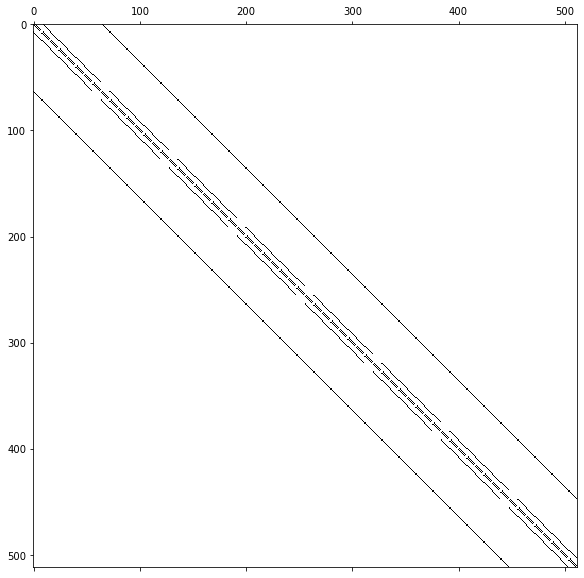

Rozmiar oryginalny:	2097152B
Rozmiar macierzy rzadkiej:	34308B
Rozmiar macierzy hierarchicznej bez permutacji:	35848B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

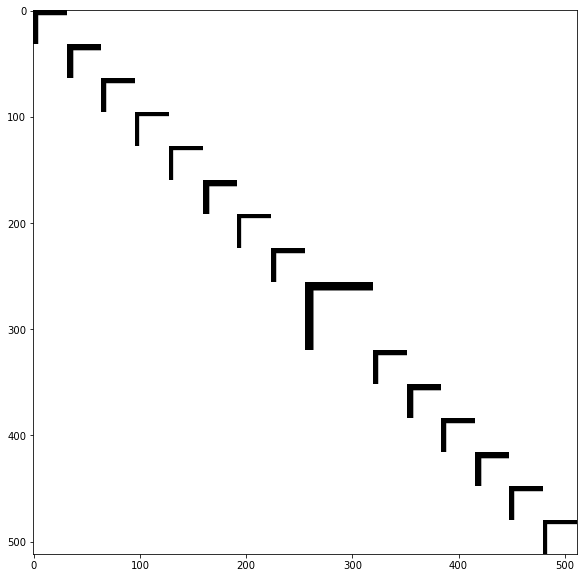

wzorzec gęstości macierzy po permutacji minimum_degree:


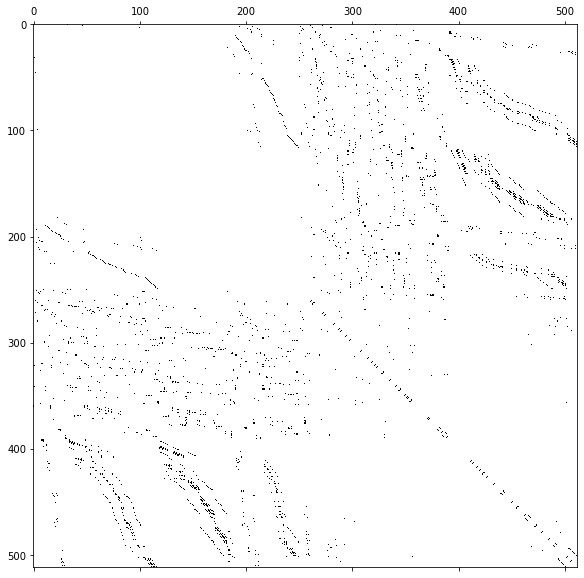

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	61504B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

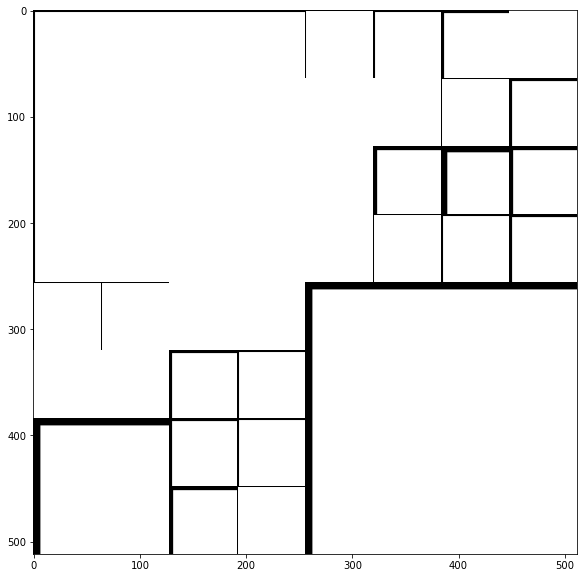

wzorzec gęstości macierzy po permutacji cuthill_mckee:


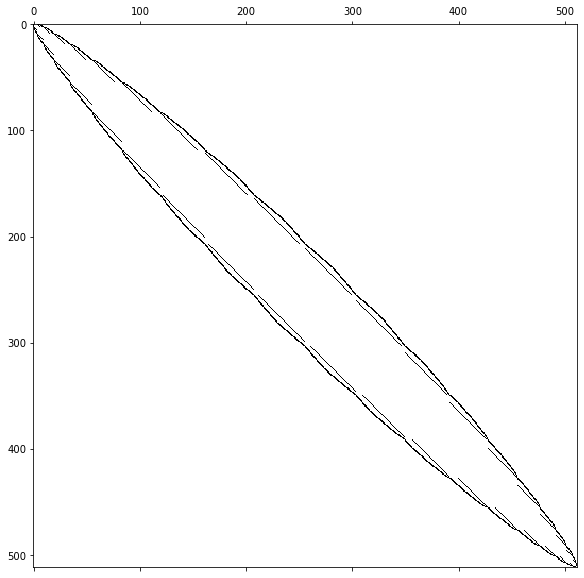

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	55480B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

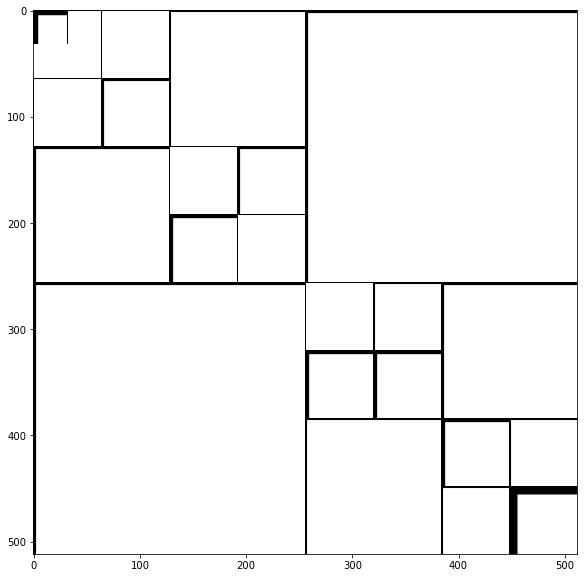

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


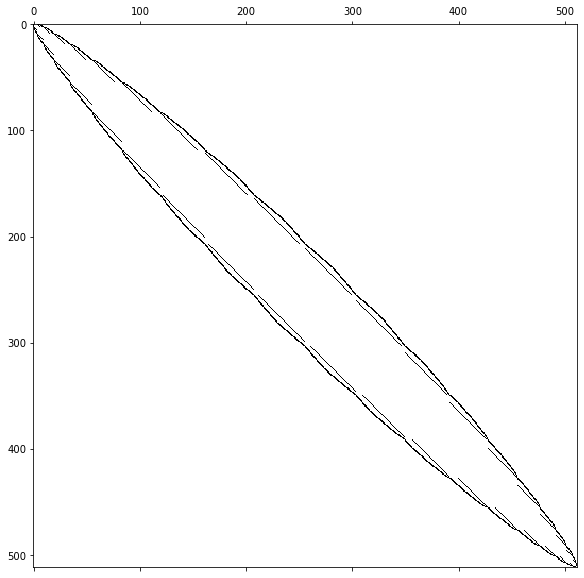

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	55480B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

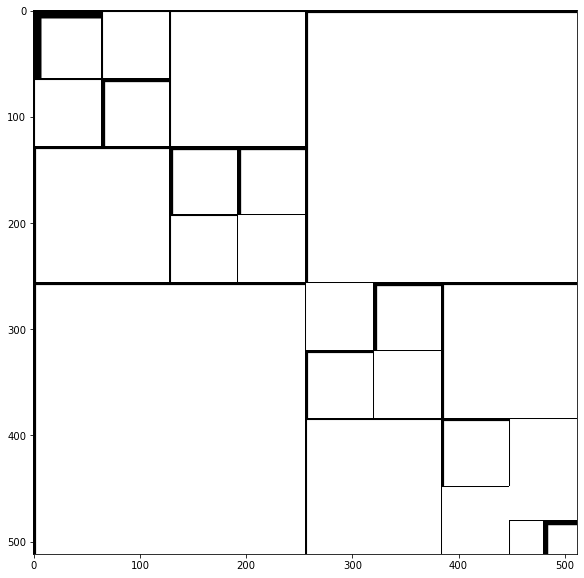

k =  4 

wzorzec gęstości macierzy przed kompresją:


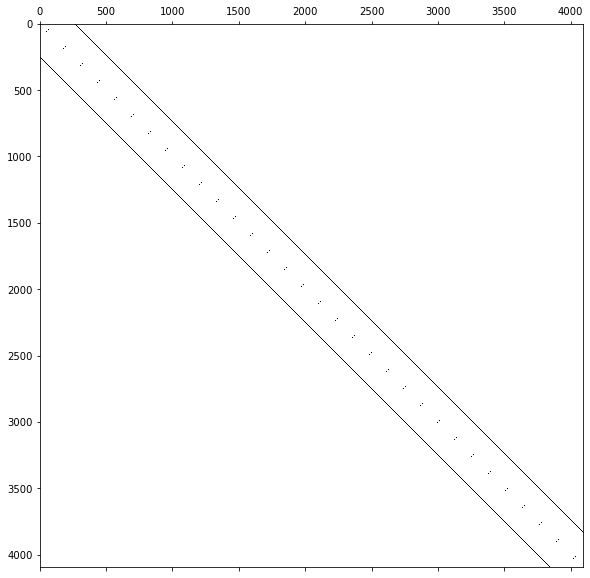

Rozmiar oryginalny:	134217728B
Rozmiar macierzy rzadkiej:	292868B
Rozmiar macierzy hierarchicznej bez permutacji:	269280B
wzorzec gęstości macierzy po kompresji bez permutacji:


<Figure size 432x288 with 0 Axes>

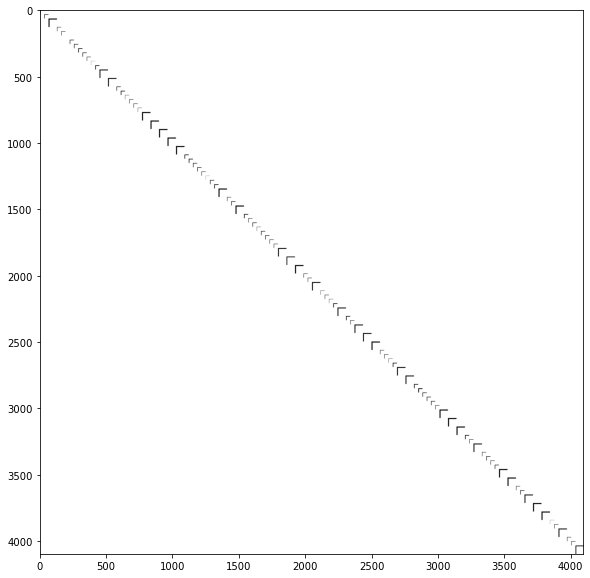

wzorzec gęstości macierzy po permutacji minimum_degree:


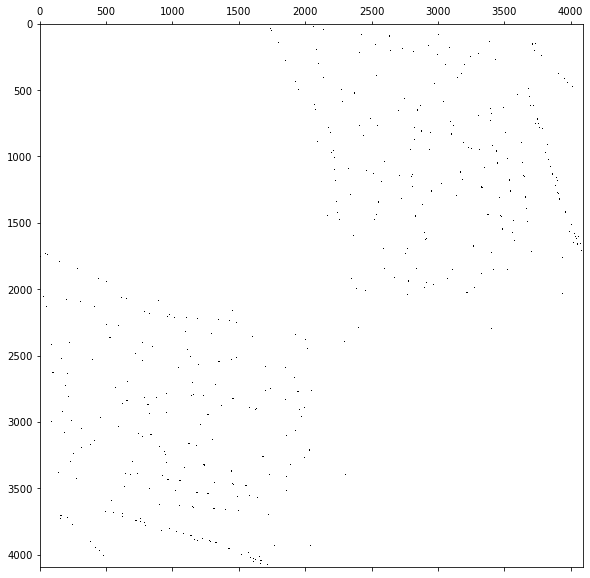

Rozmiar macierzy hierarchicznej z permutacją minimum_degree:	964192B
wzorzec gęstości macierzy po kompresji z permutacją minimum_degree:


<Figure size 432x288 with 0 Axes>

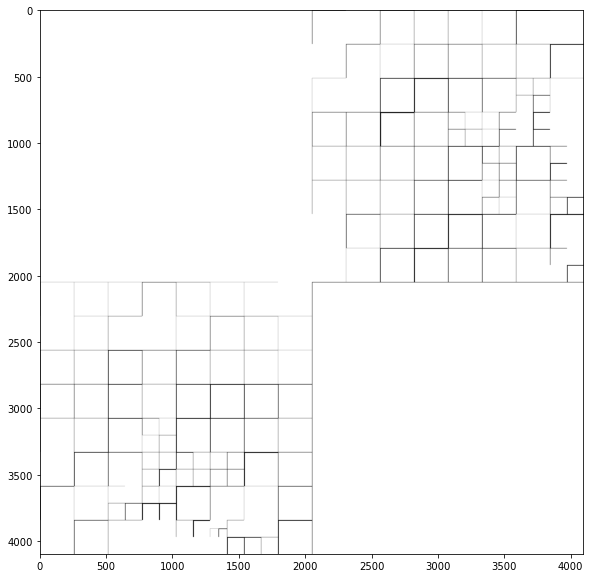

wzorzec gęstości macierzy po permutacji cuthill_mckee:


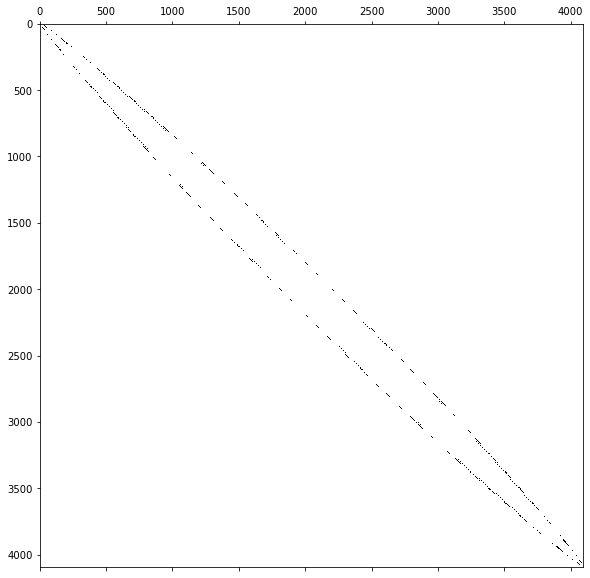

Rozmiar macierzy hierarchicznej z permutacją cuthill_mckee:	612064B
wzorzec gęstości macierzy po kompresji z permutacją cuthill_mckee:


<Figure size 432x288 with 0 Axes>

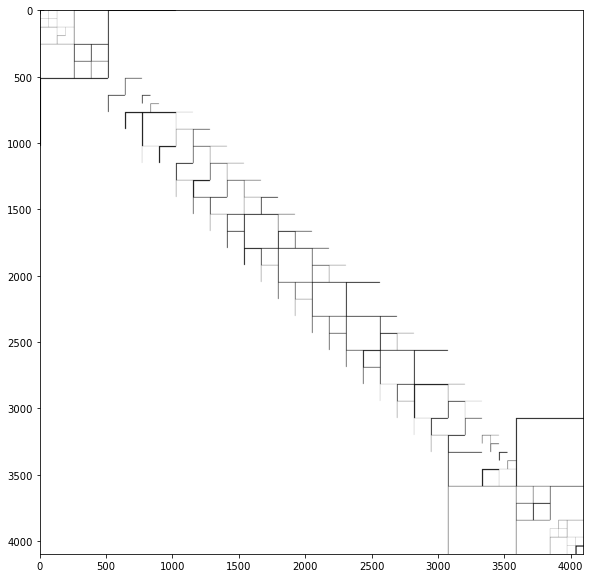

wzorzec gęstości macierzy po permutacji reversed_cuthill_mckee:


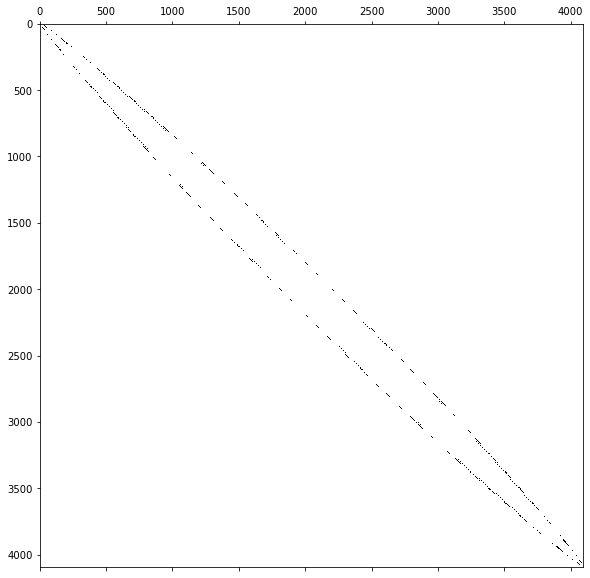

Rozmiar macierzy hierarchicznej z permutacją reversed_cuthill_mckee:	612064B
wzorzec gęstości macierzy po kompresji z permutacją reversed_cuthill_mckee:


<Figure size 432x288 with 0 Axes>

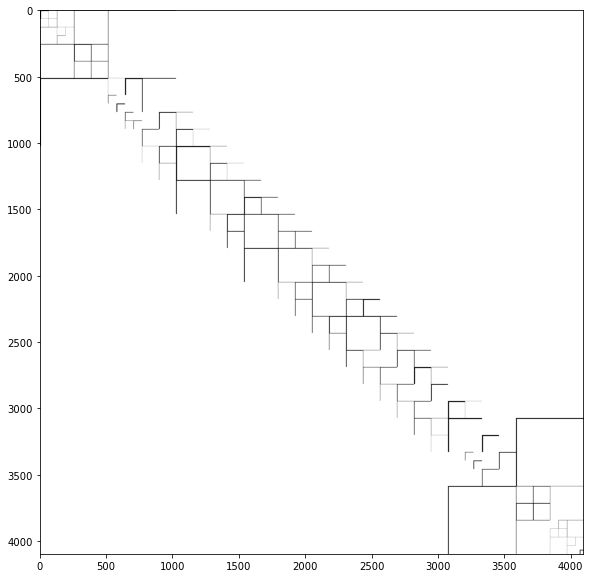

In [20]:
for sigma_div, b in product((2,3,4),(2,4,8)):
    print(f'test for \u03B4 = size/{sigma_div}, b = {b}')
    test(sigma_div, b)